# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

%matplotlib inline

from collections import Counter
import json
import math
import statistics
import datetime


import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Upload Datasets

In [2]:
df = pd.read_csv (r'Aspire_co2_left_people_stamp.csv')

In [3]:
df.head()

,Unnamed: 0,Unnamed: 0.1,time,deveui,temperature,humidity,light,motion,co2,battery,sound_avg,sound_peak,moisture,pressure,acceleration_x,acceleration_y,acceleration_z,people
0,204,4000204,1.630170e+12,a8-17-58-ff-fe-03-0f-de,22.1,44,9,0,407,3.676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,623,4000623,1.630170e+12,a8-17-58-ff-fe-03-0f-de,22.1,44,9,0,404,3.674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1033,4001033,1.630180e+12,a8-17-58-ff-fe-03-0f-de,22.0,44,9,0,412,3.676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1460,4001460,1.630180e+12,a8-17-58-ff-fe-03-0f-de,22.1,44,9,0,407,3.676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1884,4001884,1.630180e+12,a8-17-58-ff-fe-03-0f-de,22.1,44,9,0,413,3.676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(df['people'])

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
20121   NaN
20122   NaN
20123   NaN
20124   NaN
20125   NaN
Name: people, Length: 20126, dtype: float64


This data is in the time between September 2021 and April 2022 collected in a room in Tellus workspace, university of Oulu. Since the room can bee either empty or have a number of people, we extract the entries from the dataset that have a readings in terms of the number of people

In [5]:
df_people = df.dropna(subset=['people'])

In [6]:
df_people.head()

,Unnamed: 0,Unnamed: 0.1,time,deveui,temperature,humidity,light,motion,co2,battery,sound_avg,sound_peak,moisture,pressure,acceleration_x,acceleration_y,acceleration_z,people
2088,925415,4925415,1.632130e+12,a8-17-58-ff-fe-03-0f-de,20.1,33,217,0,452,3.676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2089,925857,4925857,1.632130e+12,a8-17-58-ff-fe-03-0f-de,20.1,33,214,0,443,3.676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2090,926309,4926309,1.632130e+12,a8-17-58-ff-fe-03-0f-de,20.1,33,214,0,448,3.676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2091,926752,4926752,1.632130e+12,a8-17-58-ff-fe-03-0f-de,20.2,33,214,0,456,3.676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2092,927205,4927205,1.632130e+12,a8-17-58-ff-fe-03-0f-de,20.3,33,214,1,459,3.676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [7]:
TIME = df_people['time']
TIME_np = TIME.to_numpy()


# Features and Labels

In [9]:
df_train_test = df_people[['time','temperature','motion','co2','people']]

In [10]:
df_train_test.head()

,time,temperature,motion,co2,people
2088,1.632130e+12,20.1,0,452,2.0
2089,1.632130e+12,20.1,0,443,2.0
2090,1.632130e+12,20.1,0,448,2.0
2091,1.632130e+12,20.2,0,456,2.0
2092,1.632130e+12,20.3,1,459,2.0


In [11]:
df_train_test['people'] = df_train_test['people'].replace([15],12)


<ipython-input-11-3d04b3856072>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test['people'] = df_train_test['people'].replace([15],12)


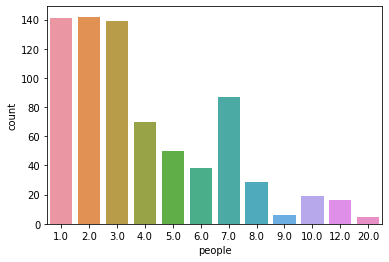

In [12]:
sns.countplot(x = 'people', data=df_train_test)


# Label the Outputs

In [13]:
class2idx = {
    1.0:0,
    2.0:1,
    3.0:2,
    4.0:3,
    5.0:4,
    6.0:5,
    7.0:6,
    8.0:7,
    9.0:8,
    10.0:9,
    12.0:10,
    20.0:11
}

idx2class = {v: k for k, v in class2idx.items()}

df_train_test['people'].replace(class2idx, inplace=True)

/homedir01/eeldeeb19/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


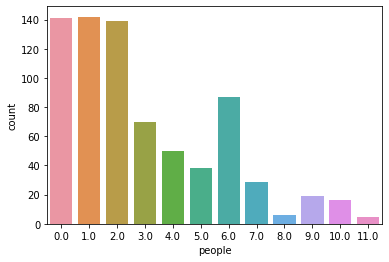

In [14]:
sns.countplot(x = 'people', data=df_train_test)


In the above cells, we define the features and the labels. In addition, we order the lables as arranged integers as the problem will be a multi-class classification.

# Preprocessing

Here, we normalize the data, split the data into train, test and validate. In addition, we explore whether the dataset is balanced among all the classes or not.

In [15]:
X = df_train_test.iloc[:, 0:-1]
y = df_train_test.iloc[:, -1]

In [16]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [17]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [18]:
def get_class_distribution(obj):
    count_dict = {
        "rating_1": 0,
        "rating_2": 0,
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
        "rating_9": 0,
        "rating_10": 0,
        "rating_12": 0,
        "rating_20": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_1'] += 1
        elif i == 1: 
            count_dict['rating_2'] += 1
        elif i == 2: 
            count_dict['rating_3'] += 1
        elif i == 3: 
            count_dict['rating_4'] += 1
        elif i == 4: 
            count_dict['rating_5'] += 1  
        elif i == 5: 
            count_dict['rating_6'] += 1
        elif i == 6: 
            count_dict['rating_7'] += 1
        elif i == 7: 
            count_dict['rating_8'] += 1
        elif i == 8: 
            count_dict['rating_9'] += 1
        elif i == 9: 
            count_dict['rating_10'] += 1  
        elif i == 10: 
            count_dict['rating_12'] += 1 
        elif i == 11: 
            count_dict['rating_20'] += 1
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

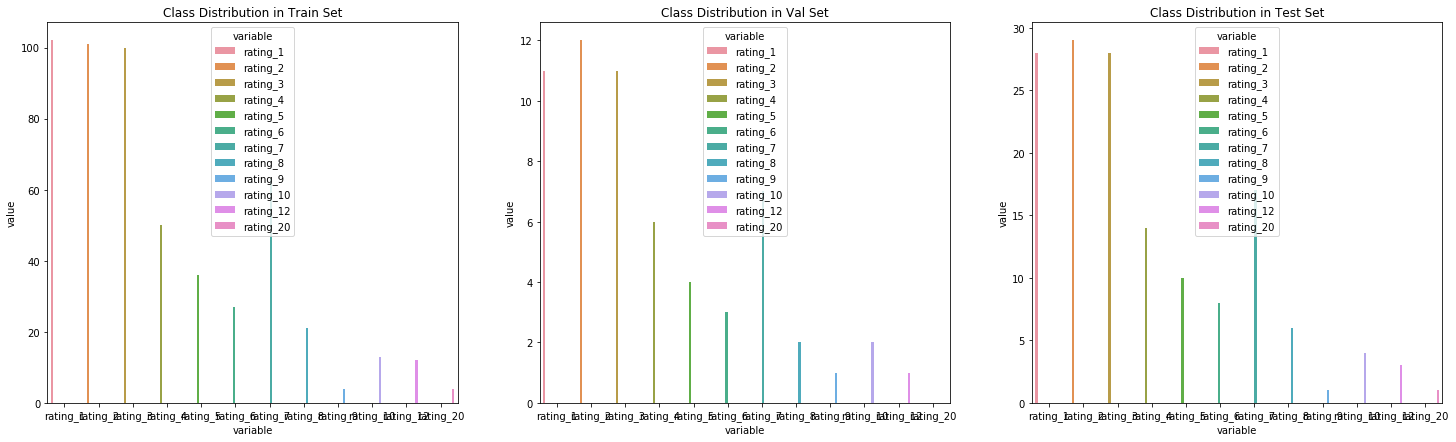

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [20]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

# Oversampling Imbalanced Classes

We need to balance the dataset by performing oversampling using WeightedRandomSampler.

In [21]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [22]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0098, 0.0099, 0.0100, 0.0200, 0.0278, 0.0370, 0.0159, 0.0476, 0.2500,
        0.0769, 0.0833, 0.2500])


In [23]:
class_weights_all = class_weights[target_list]


In [24]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

# Model Parameters and Loaders

In [25]:
EPOCHS = 15000
BATCH_SIZE = 64
LEARNING_RATE = 0.0008
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 12

In [26]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

# Neural Network

In [27]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 1024)
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_3 = nn.Linear(512, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=4, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=12, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [30]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [31]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [32]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 1.66645 | Val Loss: 2.48636 | Train Acc: 28.222| Val Acc: 16.667
Epoch 002: | Train Loss: 1.11668 | Val Loss: 2.45701 | Train Acc: 35.778| Val Acc: 11.667
Epoch 003: | Train Loss: 0.88135 | Val Loss: 2.39351 | Train Acc: 45.444| Val Acc: 25.000
Epoch 004: | Train Loss: 0.87029 | Val Loss: 2.36725 | Train Acc: 42.667| Val Acc: 28.333
Epoch 005: | Train Loss: 0.70575 | Val Loss: 2.32569 | Train Acc: 48.000| Val Acc: 33.333
Epoch 006: | Train Loss: 0.65978 | Val Loss: 2.31159 | Train Acc: 51.556| Val Acc: 28.333
Epoch 007: | Train Loss: 0.57911 | Val Loss: 2.31006 | Train Acc: 52.778| Val Acc: 28.333
Epoch 008: | Train Loss: 0.61853 | Val Loss: 2.26574 | Train Acc: 49.667| Val Acc: 28.333
Epoch 009: | Train Loss: 0.53129 | Val Loss: 2.25920 | Train Acc: 56.556| Val Acc: 28.333
Epoch 010: | Train Loss: 0.53569 | Val Loss: 2.23298 | Train Acc: 55.444| Val Acc: 30.000
Epoch 011: | Train Loss: 0.50408 | Val Loss: 2.23478 | Train Acc: 52.222| Val Acc: 31.667
Epoch 012:

Epoch 093: | Train Loss: 0.18720 | Val Loss: 1.19857 | Train Acc: 71.889| Val Acc: 48.333
Epoch 094: | Train Loss: 0.24039 | Val Loss: 1.24286 | Train Acc: 69.222| Val Acc: 43.333
Epoch 095: | Train Loss: 0.24520 | Val Loss: 1.21988 | Train Acc: 72.444| Val Acc: 46.667
Epoch 096: | Train Loss: 0.21811 | Val Loss: 1.19367 | Train Acc: 70.778| Val Acc: 51.667
Epoch 097: | Train Loss: 0.23068 | Val Loss: 1.17976 | Train Acc: 69.111| Val Acc: 51.667
Epoch 098: | Train Loss: 0.21996 | Val Loss: 1.14929 | Train Acc: 71.556| Val Acc: 45.000
Epoch 099: | Train Loss: 0.19290 | Val Loss: 1.17660 | Train Acc: 73.222| Val Acc: 50.000
Epoch 100: | Train Loss: 0.20018 | Val Loss: 1.17122 | Train Acc: 71.778| Val Acc: 48.333
Epoch 101: | Train Loss: 0.17325 | Val Loss: 1.16087 | Train Acc: 75.333| Val Acc: 48.333
Epoch 102: | Train Loss: 0.21086 | Val Loss: 1.23509 | Train Acc: 70.111| Val Acc: 50.000
Epoch 103: | Train Loss: 0.17645 | Val Loss: 1.16956 | Train Acc: 74.556| Val Acc: 50.000
Epoch 104:

Epoch 185: | Train Loss: 0.15424 | Val Loss: 1.04302 | Train Acc: 76.333| Val Acc: 55.000
Epoch 186: | Train Loss: 0.18782 | Val Loss: 0.99873 | Train Acc: 75.667| Val Acc: 56.667
Epoch 187: | Train Loss: 0.16376 | Val Loss: 1.04272 | Train Acc: 77.111| Val Acc: 56.667
Epoch 188: | Train Loss: 0.21982 | Val Loss: 1.09547 | Train Acc: 73.778| Val Acc: 58.333
Epoch 189: | Train Loss: 0.15619 | Val Loss: 1.17621 | Train Acc: 74.667| Val Acc: 58.333
Epoch 190: | Train Loss: 0.22027 | Val Loss: 1.01114 | Train Acc: 75.444| Val Acc: 60.000
Epoch 191: | Train Loss: 0.18564 | Val Loss: 1.02910 | Train Acc: 74.333| Val Acc: 56.667
Epoch 192: | Train Loss: 0.18974 | Val Loss: 1.04231 | Train Acc: 74.111| Val Acc: 53.333
Epoch 193: | Train Loss: 0.17730 | Val Loss: 1.03416 | Train Acc: 73.667| Val Acc: 55.000
Epoch 194: | Train Loss: 0.20880 | Val Loss: 0.98824 | Train Acc: 72.444| Val Acc: 63.333
Epoch 195: | Train Loss: 0.20380 | Val Loss: 0.98897 | Train Acc: 75.667| Val Acc: 61.667
Epoch 196:

Epoch 277: | Train Loss: 0.16928 | Val Loss: 1.02836 | Train Acc: 80.111| Val Acc: 65.000
Epoch 278: | Train Loss: 0.15778 | Val Loss: 1.00281 | Train Acc: 78.444| Val Acc: 61.667
Epoch 279: | Train Loss: 0.15420 | Val Loss: 1.04545 | Train Acc: 76.889| Val Acc: 56.667
Epoch 280: | Train Loss: 0.15092 | Val Loss: 0.91503 | Train Acc: 77.667| Val Acc: 61.667
Epoch 281: | Train Loss: 0.16705 | Val Loss: 0.86547 | Train Acc: 79.556| Val Acc: 68.333
Epoch 282: | Train Loss: 0.13752 | Val Loss: 1.01424 | Train Acc: 79.000| Val Acc: 65.000
Epoch 283: | Train Loss: 0.12504 | Val Loss: 0.97330 | Train Acc: 80.111| Val Acc: 65.000
Epoch 284: | Train Loss: 0.11909 | Val Loss: 0.94652 | Train Acc: 76.111| Val Acc: 65.000
Epoch 285: | Train Loss: 0.12028 | Val Loss: 0.86736 | Train Acc: 80.111| Val Acc: 68.333
Epoch 286: | Train Loss: 0.12460 | Val Loss: 0.82401 | Train Acc: 79.222| Val Acc: 68.333
Epoch 287: | Train Loss: 0.14802 | Val Loss: 0.87966 | Train Acc: 81.556| Val Acc: 68.333
Epoch 288:

Epoch 369: | Train Loss: 0.09801 | Val Loss: 0.87728 | Train Acc: 83.778| Val Acc: 73.333
Epoch 370: | Train Loss: 0.15316 | Val Loss: 0.83934 | Train Acc: 80.000| Val Acc: 70.000
Epoch 371: | Train Loss: 0.12361 | Val Loss: 0.87428 | Train Acc: 79.667| Val Acc: 73.333
Epoch 372: | Train Loss: 0.11891 | Val Loss: 0.85510 | Train Acc: 80.556| Val Acc: 76.667
Epoch 373: | Train Loss: 0.11716 | Val Loss: 0.79117 | Train Acc: 81.000| Val Acc: 71.667
Epoch 374: | Train Loss: 0.12116 | Val Loss: 0.78747 | Train Acc: 79.778| Val Acc: 71.667
Epoch 375: | Train Loss: 0.15610 | Val Loss: 0.76000 | Train Acc: 78.333| Val Acc: 76.667
Epoch 376: | Train Loss: 0.10289 | Val Loss: 0.81540 | Train Acc: 81.000| Val Acc: 70.000
Epoch 377: | Train Loss: 0.10154 | Val Loss: 0.80388 | Train Acc: 83.333| Val Acc: 71.667
Epoch 378: | Train Loss: 0.12838 | Val Loss: 0.80168 | Train Acc: 79.000| Val Acc: 73.333
Epoch 379: | Train Loss: 0.09988 | Val Loss: 0.79231 | Train Acc: 82.556| Val Acc: 71.667
Epoch 380:

Epoch 461: | Train Loss: 0.11232 | Val Loss: 0.77750 | Train Acc: 80.889| Val Acc: 80.000
Epoch 462: | Train Loss: 0.12109 | Val Loss: 0.80271 | Train Acc: 82.333| Val Acc: 76.667
Epoch 463: | Train Loss: 0.13804 | Val Loss: 0.77713 | Train Acc: 79.333| Val Acc: 71.667
Epoch 464: | Train Loss: 0.10351 | Val Loss: 0.75470 | Train Acc: 82.778| Val Acc: 71.667
Epoch 465: | Train Loss: 0.11816 | Val Loss: 0.74962 | Train Acc: 81.667| Val Acc: 76.667
Epoch 466: | Train Loss: 0.12859 | Val Loss: 0.77347 | Train Acc: 84.222| Val Acc: 70.000
Epoch 467: | Train Loss: 0.11284 | Val Loss: 0.83706 | Train Acc: 81.778| Val Acc: 73.333
Epoch 468: | Train Loss: 0.13232 | Val Loss: 0.82676 | Train Acc: 81.667| Val Acc: 71.667
Epoch 469: | Train Loss: 0.10070 | Val Loss: 0.81962 | Train Acc: 81.222| Val Acc: 66.667
Epoch 470: | Train Loss: 0.10737 | Val Loss: 0.74546 | Train Acc: 81.778| Val Acc: 73.333
Epoch 471: | Train Loss: 0.11464 | Val Loss: 0.73208 | Train Acc: 81.333| Val Acc: 78.333
Epoch 472:

Epoch 553: | Train Loss: 0.12149 | Val Loss: 0.77069 | Train Acc: 81.222| Val Acc: 73.333
Epoch 554: | Train Loss: 0.13111 | Val Loss: 0.73965 | Train Acc: 80.000| Val Acc: 75.000
Epoch 555: | Train Loss: 0.10188 | Val Loss: 0.69880 | Train Acc: 81.444| Val Acc: 76.667
Epoch 556: | Train Loss: 0.18603 | Val Loss: 0.68892 | Train Acc: 76.333| Val Acc: 80.000
Epoch 557: | Train Loss: 0.09916 | Val Loss: 0.75826 | Train Acc: 84.778| Val Acc: 78.333
Epoch 558: | Train Loss: 0.18750 | Val Loss: 0.75705 | Train Acc: 79.222| Val Acc: 73.333
Epoch 559: | Train Loss: 0.13425 | Val Loss: 0.78205 | Train Acc: 82.667| Val Acc: 71.667
Epoch 560: | Train Loss: 0.09364 | Val Loss: 0.80947 | Train Acc: 83.667| Val Acc: 66.667
Epoch 561: | Train Loss: 0.09798 | Val Loss: 0.81097 | Train Acc: 85.444| Val Acc: 66.667
Epoch 562: | Train Loss: 0.11851 | Val Loss: 0.88308 | Train Acc: 83.111| Val Acc: 68.333
Epoch 563: | Train Loss: 0.12154 | Val Loss: 0.79122 | Train Acc: 82.889| Val Acc: 70.000
Epoch 564:

Epoch 645: | Train Loss: 0.12812 | Val Loss: 0.68882 | Train Acc: 81.222| Val Acc: 78.333
Epoch 646: | Train Loss: 0.13132 | Val Loss: 0.70322 | Train Acc: 80.000| Val Acc: 73.333
Epoch 647: | Train Loss: 0.07562 | Val Loss: 0.78831 | Train Acc: 84.111| Val Acc: 73.333
Epoch 648: | Train Loss: 0.10880 | Val Loss: 0.85237 | Train Acc: 81.667| Val Acc: 75.000
Epoch 649: | Train Loss: 0.09705 | Val Loss: 0.81880 | Train Acc: 82.000| Val Acc: 75.000
Epoch 650: | Train Loss: 0.12622 | Val Loss: 0.72436 | Train Acc: 81.556| Val Acc: 81.667
Epoch 651: | Train Loss: 0.12894 | Val Loss: 0.75443 | Train Acc: 82.556| Val Acc: 76.667
Epoch 652: | Train Loss: 0.09472 | Val Loss: 0.70750 | Train Acc: 86.000| Val Acc: 80.000
Epoch 653: | Train Loss: 0.11048 | Val Loss: 0.75009 | Train Acc: 82.778| Val Acc: 80.000
Epoch 654: | Train Loss: 0.13511 | Val Loss: 0.70057 | Train Acc: 83.000| Val Acc: 78.333
Epoch 655: | Train Loss: 0.09108 | Val Loss: 0.73300 | Train Acc: 86.556| Val Acc: 71.667
Epoch 656:

Epoch 737: | Train Loss: 0.08085 | Val Loss: 0.76278 | Train Acc: 83.222| Val Acc: 75.000
Epoch 738: | Train Loss: 0.08100 | Val Loss: 0.72634 | Train Acc: 85.333| Val Acc: 73.333
Epoch 739: | Train Loss: 0.12404 | Val Loss: 0.73760 | Train Acc: 82.889| Val Acc: 70.000
Epoch 740: | Train Loss: 0.12230 | Val Loss: 0.76112 | Train Acc: 84.889| Val Acc: 71.667
Epoch 741: | Train Loss: 0.09316 | Val Loss: 0.73123 | Train Acc: 83.556| Val Acc: 71.667
Epoch 742: | Train Loss: 0.12036 | Val Loss: 0.72825 | Train Acc: 83.000| Val Acc: 73.333
Epoch 743: | Train Loss: 0.13118 | Val Loss: 0.76213 | Train Acc: 83.111| Val Acc: 73.333
Epoch 744: | Train Loss: 0.09498 | Val Loss: 0.80472 | Train Acc: 85.000| Val Acc: 73.333
Epoch 745: | Train Loss: 0.08184 | Val Loss: 0.78293 | Train Acc: 84.444| Val Acc: 75.000
Epoch 746: | Train Loss: 0.10879 | Val Loss: 0.75609 | Train Acc: 83.111| Val Acc: 76.667
Epoch 747: | Train Loss: 0.06736 | Val Loss: 0.69013 | Train Acc: 88.222| Val Acc: 76.667
Epoch 748:

Epoch 829: | Train Loss: 0.06849 | Val Loss: 0.71906 | Train Acc: 89.000| Val Acc: 75.000
Epoch 830: | Train Loss: 0.12364 | Val Loss: 0.67373 | Train Acc: 83.111| Val Acc: 76.667
Epoch 831: | Train Loss: 0.07897 | Val Loss: 0.67684 | Train Acc: 87.000| Val Acc: 80.000
Epoch 832: | Train Loss: 0.11537 | Val Loss: 0.63485 | Train Acc: 81.889| Val Acc: 80.000
Epoch 833: | Train Loss: 0.14172 | Val Loss: 0.62159 | Train Acc: 84.222| Val Acc: 83.333
Epoch 834: | Train Loss: 0.08556 | Val Loss: 0.62790 | Train Acc: 88.000| Val Acc: 83.333
Epoch 835: | Train Loss: 0.09820 | Val Loss: 0.66748 | Train Acc: 86.556| Val Acc: 81.667
Epoch 836: | Train Loss: 0.07686 | Val Loss: 0.70644 | Train Acc: 85.444| Val Acc: 80.000
Epoch 837: | Train Loss: 0.10896 | Val Loss: 0.72625 | Train Acc: 82.000| Val Acc: 78.333
Epoch 838: | Train Loss: 0.08924 | Val Loss: 0.67066 | Train Acc: 87.000| Val Acc: 81.667
Epoch 839: | Train Loss: 0.06655 | Val Loss: 0.69598 | Train Acc: 88.000| Val Acc: 78.333
Epoch 840:

Epoch 921: | Train Loss: 0.07296 | Val Loss: 0.73851 | Train Acc: 87.222| Val Acc: 80.000
Epoch 922: | Train Loss: 0.14184 | Val Loss: 0.71235 | Train Acc: 83.333| Val Acc: 76.667
Epoch 923: | Train Loss: 0.10432 | Val Loss: 0.70281 | Train Acc: 85.778| Val Acc: 75.000
Epoch 924: | Train Loss: 0.06574 | Val Loss: 0.82822 | Train Acc: 88.778| Val Acc: 68.333
Epoch 925: | Train Loss: 0.09411 | Val Loss: 0.80440 | Train Acc: 84.667| Val Acc: 70.000
Epoch 926: | Train Loss: 0.12432 | Val Loss: 0.70789 | Train Acc: 83.333| Val Acc: 76.667
Epoch 927: | Train Loss: 0.07237 | Val Loss: 0.72457 | Train Acc: 84.889| Val Acc: 76.667
Epoch 928: | Train Loss: 0.08279 | Val Loss: 0.66641 | Train Acc: 86.000| Val Acc: 78.333
Epoch 929: | Train Loss: 0.10173 | Val Loss: 0.66455 | Train Acc: 83.778| Val Acc: 81.667
Epoch 930: | Train Loss: 0.08422 | Val Loss: 0.65156 | Train Acc: 84.000| Val Acc: 81.667
Epoch 931: | Train Loss: 0.06779 | Val Loss: 0.66970 | Train Acc: 88.556| Val Acc: 81.667
Epoch 932:

Epoch 1013: | Train Loss: 0.13585 | Val Loss: 0.69431 | Train Acc: 84.444| Val Acc: 83.333
Epoch 1014: | Train Loss: 0.12089 | Val Loss: 0.78466 | Train Acc: 82.000| Val Acc: 81.667
Epoch 1015: | Train Loss: 0.10434 | Val Loss: 0.83719 | Train Acc: 84.444| Val Acc: 80.000
Epoch 1016: | Train Loss: 0.06663 | Val Loss: 0.81243 | Train Acc: 89.222| Val Acc: 78.333
Epoch 1017: | Train Loss: 0.08895 | Val Loss: 0.79332 | Train Acc: 86.000| Val Acc: 81.667
Epoch 1018: | Train Loss: 0.10193 | Val Loss: 0.78093 | Train Acc: 86.222| Val Acc: 81.667
Epoch 1019: | Train Loss: 0.10085 | Val Loss: 0.81711 | Train Acc: 85.556| Val Acc: 76.667
Epoch 1020: | Train Loss: 0.09890 | Val Loss: 0.78976 | Train Acc: 85.667| Val Acc: 83.333
Epoch 1021: | Train Loss: 0.07421 | Val Loss: 0.86390 | Train Acc: 88.333| Val Acc: 80.000
Epoch 1022: | Train Loss: 0.08491 | Val Loss: 0.88581 | Train Acc: 87.222| Val Acc: 75.000
Epoch 1023: | Train Loss: 0.06636 | Val Loss: 0.83476 | Train Acc: 85.889| Val Acc: 78.333

Epoch 1105: | Train Loss: 0.08917 | Val Loss: 0.83216 | Train Acc: 87.111| Val Acc: 68.333
Epoch 1106: | Train Loss: 0.06312 | Val Loss: 0.73973 | Train Acc: 87.556| Val Acc: 73.333
Epoch 1107: | Train Loss: 0.07404 | Val Loss: 0.70610 | Train Acc: 87.000| Val Acc: 76.667
Epoch 1108: | Train Loss: 0.07943 | Val Loss: 0.66400 | Train Acc: 87.222| Val Acc: 80.000
Epoch 1109: | Train Loss: 0.10496 | Val Loss: 0.68681 | Train Acc: 85.333| Val Acc: 76.667
Epoch 1110: | Train Loss: 0.10671 | Val Loss: 0.64965 | Train Acc: 84.222| Val Acc: 76.667
Epoch 1111: | Train Loss: 0.06660 | Val Loss: 0.59945 | Train Acc: 86.222| Val Acc: 81.667
Epoch 1112: | Train Loss: 0.07335 | Val Loss: 0.58570 | Train Acc: 87.111| Val Acc: 80.000
Epoch 1113: | Train Loss: 0.13213 | Val Loss: 0.69275 | Train Acc: 83.889| Val Acc: 81.667
Epoch 1114: | Train Loss: 0.06293 | Val Loss: 0.75042 | Train Acc: 88.000| Val Acc: 78.333
Epoch 1115: | Train Loss: 0.17178 | Val Loss: 0.77784 | Train Acc: 82.000| Val Acc: 76.667

Epoch 1197: | Train Loss: 0.08087 | Val Loss: 0.67784 | Train Acc: 86.667| Val Acc: 81.667
Epoch 1198: | Train Loss: 0.07120 | Val Loss: 0.63749 | Train Acc: 86.333| Val Acc: 81.667
Epoch 1199: | Train Loss: 0.07396 | Val Loss: 0.63680 | Train Acc: 87.556| Val Acc: 80.000
Epoch 1200: | Train Loss: 0.11091 | Val Loss: 0.68726 | Train Acc: 83.556| Val Acc: 73.333
Epoch 1201: | Train Loss: 0.08740 | Val Loss: 0.73210 | Train Acc: 84.889| Val Acc: 81.667
Epoch 1202: | Train Loss: 0.08423 | Val Loss: 0.71110 | Train Acc: 85.444| Val Acc: 81.667
Epoch 1203: | Train Loss: 0.07652 | Val Loss: 0.67246 | Train Acc: 84.667| Val Acc: 78.333
Epoch 1204: | Train Loss: 0.09561 | Val Loss: 0.67678 | Train Acc: 86.556| Val Acc: 80.000
Epoch 1205: | Train Loss: 0.06722 | Val Loss: 0.69588 | Train Acc: 84.111| Val Acc: 83.333
Epoch 1206: | Train Loss: 0.07421 | Val Loss: 0.67978 | Train Acc: 86.667| Val Acc: 83.333
Epoch 1207: | Train Loss: 0.06579 | Val Loss: 0.71213 | Train Acc: 88.889| Val Acc: 81.667

Epoch 1289: | Train Loss: 0.10472 | Val Loss: 0.74874 | Train Acc: 84.889| Val Acc: 75.000
Epoch 1290: | Train Loss: 0.07177 | Val Loss: 0.67138 | Train Acc: 90.111| Val Acc: 80.000
Epoch 1291: | Train Loss: 0.08774 | Val Loss: 0.67049 | Train Acc: 85.444| Val Acc: 75.000
Epoch 1292: | Train Loss: 0.06421 | Val Loss: 0.69438 | Train Acc: 86.444| Val Acc: 78.333
Epoch 1293: | Train Loss: 0.13860 | Val Loss: 0.70741 | Train Acc: 82.889| Val Acc: 78.333
Epoch 1294: | Train Loss: 0.08263 | Val Loss: 0.67123 | Train Acc: 88.444| Val Acc: 80.000
Epoch 1295: | Train Loss: 0.11660 | Val Loss: 0.66753 | Train Acc: 84.667| Val Acc: 83.333
Epoch 1296: | Train Loss: 0.07916 | Val Loss: 0.73190 | Train Acc: 87.333| Val Acc: 80.000
Epoch 1297: | Train Loss: 0.09138 | Val Loss: 0.64478 | Train Acc: 84.111| Val Acc: 81.667
Epoch 1298: | Train Loss: 0.06474 | Val Loss: 0.63370 | Train Acc: 85.222| Val Acc: 81.667
Epoch 1299: | Train Loss: 0.07627 | Val Loss: 0.64252 | Train Acc: 88.222| Val Acc: 76.667

Epoch 1381: | Train Loss: 0.06986 | Val Loss: 0.62813 | Train Acc: 89.111| Val Acc: 80.000
Epoch 1382: | Train Loss: 0.10784 | Val Loss: 0.65346 | Train Acc: 87.444| Val Acc: 78.333
Epoch 1383: | Train Loss: 0.10029 | Val Loss: 0.62110 | Train Acc: 87.222| Val Acc: 83.333
Epoch 1384: | Train Loss: 0.10597 | Val Loss: 0.59159 | Train Acc: 83.222| Val Acc: 81.667
Epoch 1385: | Train Loss: 0.07795 | Val Loss: 0.54813 | Train Acc: 87.000| Val Acc: 85.000
Epoch 1386: | Train Loss: 0.08207 | Val Loss: 0.57261 | Train Acc: 85.111| Val Acc: 85.000
Epoch 1387: | Train Loss: 0.06694 | Val Loss: 0.59972 | Train Acc: 89.111| Val Acc: 81.667
Epoch 1388: | Train Loss: 0.05829 | Val Loss: 0.61432 | Train Acc: 89.000| Val Acc: 83.333
Epoch 1389: | Train Loss: 0.06315 | Val Loss: 0.60766 | Train Acc: 89.444| Val Acc: 81.667
Epoch 1390: | Train Loss: 0.05929 | Val Loss: 0.67231 | Train Acc: 90.111| Val Acc: 78.333
Epoch 1391: | Train Loss: 0.04920 | Val Loss: 0.59875 | Train Acc: 92.444| Val Acc: 83.333

Epoch 1473: | Train Loss: 0.08582 | Val Loss: 0.61428 | Train Acc: 86.222| Val Acc: 78.333
Epoch 1474: | Train Loss: 0.06786 | Val Loss: 0.69881 | Train Acc: 84.667| Val Acc: 78.333
Epoch 1475: | Train Loss: 0.10838 | Val Loss: 0.70851 | Train Acc: 85.667| Val Acc: 80.000
Epoch 1476: | Train Loss: 0.12393 | Val Loss: 0.67309 | Train Acc: 84.111| Val Acc: 80.000
Epoch 1477: | Train Loss: 0.08062 | Val Loss: 0.59323 | Train Acc: 86.111| Val Acc: 81.667
Epoch 1478: | Train Loss: 0.09461 | Val Loss: 0.59958 | Train Acc: 87.333| Val Acc: 78.333
Epoch 1479: | Train Loss: 0.06580 | Val Loss: 0.61255 | Train Acc: 88.333| Val Acc: 80.000
Epoch 1480: | Train Loss: 0.10009 | Val Loss: 0.61847 | Train Acc: 87.556| Val Acc: 81.667
Epoch 1481: | Train Loss: 0.06351 | Val Loss: 0.62582 | Train Acc: 87.778| Val Acc: 81.667
Epoch 1482: | Train Loss: 0.10308 | Val Loss: 0.60367 | Train Acc: 85.556| Val Acc: 80.000
Epoch 1483: | Train Loss: 0.08943 | Val Loss: 0.57581 | Train Acc: 84.556| Val Acc: 81.667

Epoch 1565: | Train Loss: 0.08064 | Val Loss: 0.61964 | Train Acc: 87.667| Val Acc: 81.667
Epoch 1566: | Train Loss: 0.06855 | Val Loss: 0.66933 | Train Acc: 88.333| Val Acc: 83.333
Epoch 1567: | Train Loss: 0.09255 | Val Loss: 0.63670 | Train Acc: 83.000| Val Acc: 86.667
Epoch 1568: | Train Loss: 0.08114 | Val Loss: 0.60998 | Train Acc: 87.667| Val Acc: 83.333
Epoch 1569: | Train Loss: 0.06669 | Val Loss: 0.64347 | Train Acc: 88.667| Val Acc: 78.333
Epoch 1570: | Train Loss: 0.12275 | Val Loss: 0.64416 | Train Acc: 84.667| Val Acc: 80.000
Epoch 1571: | Train Loss: 0.08523 | Val Loss: 0.74312 | Train Acc: 89.667| Val Acc: 78.333
Epoch 1572: | Train Loss: 0.07361 | Val Loss: 0.64388 | Train Acc: 84.667| Val Acc: 80.000
Epoch 1573: | Train Loss: 0.05432 | Val Loss: 0.64618 | Train Acc: 89.556| Val Acc: 83.333
Epoch 1574: | Train Loss: 0.07635 | Val Loss: 0.66101 | Train Acc: 86.222| Val Acc: 81.667
Epoch 1575: | Train Loss: 0.06127 | Val Loss: 0.66904 | Train Acc: 88.778| Val Acc: 83.333

Epoch 1657: | Train Loss: 0.06889 | Val Loss: 0.77193 | Train Acc: 87.333| Val Acc: 70.000
Epoch 1658: | Train Loss: 0.06243 | Val Loss: 0.63944 | Train Acc: 88.667| Val Acc: 76.667
Epoch 1659: | Train Loss: 0.07920 | Val Loss: 0.65797 | Train Acc: 87.889| Val Acc: 78.333
Epoch 1660: | Train Loss: 0.08080 | Val Loss: 0.64816 | Train Acc: 88.889| Val Acc: 78.333
Epoch 1661: | Train Loss: 0.07938 | Val Loss: 0.64860 | Train Acc: 86.222| Val Acc: 78.333
Epoch 1662: | Train Loss: 0.05437 | Val Loss: 0.65416 | Train Acc: 89.667| Val Acc: 76.667
Epoch 1663: | Train Loss: 0.05632 | Val Loss: 0.62159 | Train Acc: 91.444| Val Acc: 80.000
Epoch 1664: | Train Loss: 0.06210 | Val Loss: 0.65452 | Train Acc: 90.333| Val Acc: 78.333
Epoch 1665: | Train Loss: 0.10806 | Val Loss: 0.63995 | Train Acc: 85.667| Val Acc: 80.000
Epoch 1666: | Train Loss: 0.04786 | Val Loss: 0.67943 | Train Acc: 90.111| Val Acc: 81.667
Epoch 1667: | Train Loss: 0.06775 | Val Loss: 0.67165 | Train Acc: 87.667| Val Acc: 80.000

Epoch 1749: | Train Loss: 0.05323 | Val Loss: 0.57325 | Train Acc: 90.667| Val Acc: 81.667
Epoch 1750: | Train Loss: 0.10453 | Val Loss: 0.55507 | Train Acc: 84.444| Val Acc: 83.333
Epoch 1751: | Train Loss: 0.06558 | Val Loss: 0.53103 | Train Acc: 88.556| Val Acc: 81.667
Epoch 1752: | Train Loss: 0.04775 | Val Loss: 0.51131 | Train Acc: 89.111| Val Acc: 83.333
Epoch 1753: | Train Loss: 0.06385 | Val Loss: 0.50771 | Train Acc: 86.778| Val Acc: 83.333
Epoch 1754: | Train Loss: 0.08408 | Val Loss: 0.54061 | Train Acc: 86.667| Val Acc: 83.333
Epoch 1755: | Train Loss: 0.07664 | Val Loss: 0.64533 | Train Acc: 88.000| Val Acc: 81.667
Epoch 1756: | Train Loss: 0.07179 | Val Loss: 0.69234 | Train Acc: 89.556| Val Acc: 86.667
Epoch 1757: | Train Loss: 0.05932 | Val Loss: 0.68588 | Train Acc: 89.333| Val Acc: 85.000
Epoch 1758: | Train Loss: 0.06404 | Val Loss: 0.67044 | Train Acc: 89.667| Val Acc: 83.333
Epoch 1759: | Train Loss: 0.15160 | Val Loss: 0.72510 | Train Acc: 87.222| Val Acc: 85.000

Epoch 1841: | Train Loss: 0.07594 | Val Loss: 0.59482 | Train Acc: 86.444| Val Acc: 80.000
Epoch 1842: | Train Loss: 0.07255 | Val Loss: 0.58064 | Train Acc: 86.667| Val Acc: 81.667
Epoch 1843: | Train Loss: 0.05936 | Val Loss: 0.58834 | Train Acc: 90.111| Val Acc: 80.000
Epoch 1844: | Train Loss: 0.06393 | Val Loss: 0.54904 | Train Acc: 91.111| Val Acc: 80.000
Epoch 1845: | Train Loss: 0.06027 | Val Loss: 0.51274 | Train Acc: 89.000| Val Acc: 83.333
Epoch 1846: | Train Loss: 0.05670 | Val Loss: 0.54201 | Train Acc: 89.000| Val Acc: 81.667
Epoch 1847: | Train Loss: 0.05431 | Val Loss: 0.58026 | Train Acc: 88.222| Val Acc: 78.333
Epoch 1848: | Train Loss: 0.08450 | Val Loss: 0.62367 | Train Acc: 90.778| Val Acc: 80.000
Epoch 1849: | Train Loss: 0.07409 | Val Loss: 0.64075 | Train Acc: 86.000| Val Acc: 83.333
Epoch 1850: | Train Loss: 0.06791 | Val Loss: 0.62126 | Train Acc: 86.667| Val Acc: 80.000
Epoch 1851: | Train Loss: 0.07884 | Val Loss: 0.65795 | Train Acc: 86.111| Val Acc: 75.000

Epoch 1933: | Train Loss: 0.05548 | Val Loss: 0.59733 | Train Acc: 88.889| Val Acc: 85.000
Epoch 1934: | Train Loss: 0.05613 | Val Loss: 0.61424 | Train Acc: 90.111| Val Acc: 83.333
Epoch 1935: | Train Loss: 0.05919 | Val Loss: 0.64647 | Train Acc: 91.000| Val Acc: 81.667
Epoch 1936: | Train Loss: 0.05709 | Val Loss: 0.66260 | Train Acc: 89.889| Val Acc: 81.667
Epoch 1937: | Train Loss: 0.06041 | Val Loss: 0.62019 | Train Acc: 88.889| Val Acc: 85.000
Epoch 1938: | Train Loss: 0.08506 | Val Loss: 0.68524 | Train Acc: 87.111| Val Acc: 83.333
Epoch 1939: | Train Loss: 0.05562 | Val Loss: 0.65220 | Train Acc: 90.778| Val Acc: 83.333
Epoch 1940: | Train Loss: 0.08383 | Val Loss: 0.68364 | Train Acc: 86.333| Val Acc: 81.667
Epoch 1941: | Train Loss: 0.12004 | Val Loss: 0.63367 | Train Acc: 85.444| Val Acc: 85.000
Epoch 1942: | Train Loss: 0.06036 | Val Loss: 0.66369 | Train Acc: 88.556| Val Acc: 83.333
Epoch 1943: | Train Loss: 0.08666 | Val Loss: 0.68994 | Train Acc: 87.000| Val Acc: 83.333

Epoch 2025: | Train Loss: 0.04863 | Val Loss: 0.57256 | Train Acc: 89.778| Val Acc: 81.667
Epoch 2026: | Train Loss: 0.09427 | Val Loss: 0.58920 | Train Acc: 86.000| Val Acc: 81.667
Epoch 2027: | Train Loss: 0.05405 | Val Loss: 0.75449 | Train Acc: 91.222| Val Acc: 75.000
Epoch 2028: | Train Loss: 0.05777 | Val Loss: 0.75640 | Train Acc: 88.444| Val Acc: 73.333
Epoch 2029: | Train Loss: 0.05793 | Val Loss: 0.65922 | Train Acc: 88.556| Val Acc: 76.667
Epoch 2030: | Train Loss: 0.10989 | Val Loss: 0.71412 | Train Acc: 87.222| Val Acc: 76.667
Epoch 2031: | Train Loss: 0.05670 | Val Loss: 0.80098 | Train Acc: 91.000| Val Acc: 75.000
Epoch 2032: | Train Loss: 0.05197 | Val Loss: 0.85315 | Train Acc: 88.556| Val Acc: 73.333
Epoch 2033: | Train Loss: 0.05957 | Val Loss: 0.79999 | Train Acc: 88.556| Val Acc: 73.333
Epoch 2034: | Train Loss: 0.08418 | Val Loss: 0.68954 | Train Acc: 88.778| Val Acc: 76.667
Epoch 2035: | Train Loss: 0.06162 | Val Loss: 0.62693 | Train Acc: 85.556| Val Acc: 75.000

Epoch 2117: | Train Loss: 0.12162 | Val Loss: 0.72081 | Train Acc: 86.667| Val Acc: 81.667
Epoch 2118: | Train Loss: 0.05829 | Val Loss: 0.69592 | Train Acc: 89.778| Val Acc: 81.667
Epoch 2119: | Train Loss: 0.10859 | Val Loss: 0.71206 | Train Acc: 82.667| Val Acc: 80.000
Epoch 2120: | Train Loss: 0.28883 | Val Loss: 0.80164 | Train Acc: 82.333| Val Acc: 75.000
Epoch 2121: | Train Loss: 0.09523 | Val Loss: 0.73241 | Train Acc: 87.000| Val Acc: 75.000
Epoch 2122: | Train Loss: 0.07546 | Val Loss: 0.69823 | Train Acc: 89.889| Val Acc: 75.000
Epoch 2123: | Train Loss: 0.09001 | Val Loss: 0.69215 | Train Acc: 88.111| Val Acc: 78.333
Epoch 2124: | Train Loss: 0.07289 | Val Loss: 0.72376 | Train Acc: 87.778| Val Acc: 81.667
Epoch 2125: | Train Loss: 0.07447 | Val Loss: 0.72308 | Train Acc: 89.556| Val Acc: 83.333
Epoch 2126: | Train Loss: 0.07241 | Val Loss: 0.75622 | Train Acc: 88.000| Val Acc: 80.000
Epoch 2127: | Train Loss: 0.06966 | Val Loss: 0.68164 | Train Acc: 88.333| Val Acc: 83.333

Epoch 2209: | Train Loss: 0.07773 | Val Loss: 0.62004 | Train Acc: 89.000| Val Acc: 81.667
Epoch 2210: | Train Loss: 0.04661 | Val Loss: 0.62503 | Train Acc: 92.111| Val Acc: 81.667
Epoch 2211: | Train Loss: 0.05708 | Val Loss: 0.56828 | Train Acc: 91.000| Val Acc: 83.333
Epoch 2212: | Train Loss: 0.11370 | Val Loss: 0.64757 | Train Acc: 87.444| Val Acc: 80.000
Epoch 2213: | Train Loss: 0.05530 | Val Loss: 0.83588 | Train Acc: 88.667| Val Acc: 73.333
Epoch 2214: | Train Loss: 0.08951 | Val Loss: 0.81099 | Train Acc: 84.000| Val Acc: 75.000
Epoch 2215: | Train Loss: 0.08063 | Val Loss: 0.68654 | Train Acc: 86.444| Val Acc: 81.667
Epoch 2216: | Train Loss: 0.06057 | Val Loss: 0.61066 | Train Acc: 88.444| Val Acc: 81.667
Epoch 2217: | Train Loss: 0.06489 | Val Loss: 0.58710 | Train Acc: 91.667| Val Acc: 83.333
Epoch 2218: | Train Loss: 0.08460 | Val Loss: 0.57889 | Train Acc: 85.000| Val Acc: 83.333
Epoch 2219: | Train Loss: 0.05699 | Val Loss: 0.61460 | Train Acc: 88.444| Val Acc: 83.333

Epoch 2301: | Train Loss: 0.06127 | Val Loss: 0.51288 | Train Acc: 89.111| Val Acc: 81.667
Epoch 2302: | Train Loss: 0.06004 | Val Loss: 0.51971 | Train Acc: 91.778| Val Acc: 83.333
Epoch 2303: | Train Loss: 0.04725 | Val Loss: 0.54697 | Train Acc: 90.778| Val Acc: 85.000
Epoch 2304: | Train Loss: 0.07986 | Val Loss: 0.63042 | Train Acc: 88.889| Val Acc: 80.000
Epoch 2305: | Train Loss: 0.05117 | Val Loss: 0.62511 | Train Acc: 90.222| Val Acc: 81.667
Epoch 2306: | Train Loss: 0.06440 | Val Loss: 0.64543 | Train Acc: 90.667| Val Acc: 78.333
Epoch 2307: | Train Loss: 0.04624 | Val Loss: 0.66234 | Train Acc: 90.222| Val Acc: 80.000
Epoch 2308: | Train Loss: 0.13402 | Val Loss: 0.76671 | Train Acc: 86.667| Val Acc: 76.667
Epoch 2309: | Train Loss: 0.13865 | Val Loss: 0.71167 | Train Acc: 84.556| Val Acc: 78.333
Epoch 2310: | Train Loss: 0.09349 | Val Loss: 0.65377 | Train Acc: 85.222| Val Acc: 78.333
Epoch 2311: | Train Loss: 0.05977 | Val Loss: 0.62472 | Train Acc: 90.222| Val Acc: 78.333

Epoch 2393: | Train Loss: 0.05989 | Val Loss: 0.60471 | Train Acc: 89.333| Val Acc: 85.000
Epoch 2394: | Train Loss: 0.10280 | Val Loss: 0.67234 | Train Acc: 88.778| Val Acc: 81.667
Epoch 2395: | Train Loss: 0.07931 | Val Loss: 0.74631 | Train Acc: 88.889| Val Acc: 80.000
Epoch 2396: | Train Loss: 0.06309 | Val Loss: 0.70166 | Train Acc: 88.778| Val Acc: 81.667
Epoch 2397: | Train Loss: 0.04572 | Val Loss: 0.68881 | Train Acc: 91.111| Val Acc: 85.000
Epoch 2398: | Train Loss: 0.06717 | Val Loss: 0.68458 | Train Acc: 86.000| Val Acc: 85.000
Epoch 2399: | Train Loss: 0.07539 | Val Loss: 0.65654 | Train Acc: 84.556| Val Acc: 80.000
Epoch 2400: | Train Loss: 0.06074 | Val Loss: 0.54410 | Train Acc: 88.222| Val Acc: 83.333
Epoch 2401: | Train Loss: 0.08134 | Val Loss: 0.52791 | Train Acc: 88.222| Val Acc: 83.333
Epoch 2402: | Train Loss: 0.06983 | Val Loss: 0.55762 | Train Acc: 90.889| Val Acc: 81.667
Epoch 2403: | Train Loss: 0.05248 | Val Loss: 0.61418 | Train Acc: 90.222| Val Acc: 83.333

Epoch 2485: | Train Loss: 0.05583 | Val Loss: 0.60857 | Train Acc: 91.667| Val Acc: 83.333
Epoch 2486: | Train Loss: 0.06492 | Val Loss: 0.59240 | Train Acc: 87.778| Val Acc: 85.000
Epoch 2487: | Train Loss: 0.04364 | Val Loss: 0.60746 | Train Acc: 90.889| Val Acc: 81.667
Epoch 2488: | Train Loss: 0.04722 | Val Loss: 0.59895 | Train Acc: 92.556| Val Acc: 83.333
Epoch 2489: | Train Loss: 0.04587 | Val Loss: 0.60055 | Train Acc: 92.222| Val Acc: 81.667
Epoch 2490: | Train Loss: 0.05111 | Val Loss: 0.56613 | Train Acc: 89.111| Val Acc: 81.667
Epoch 2491: | Train Loss: 0.07814 | Val Loss: 0.55283 | Train Acc: 90.889| Val Acc: 85.000
Epoch 2492: | Train Loss: 0.05388 | Val Loss: 0.58231 | Train Acc: 92.111| Val Acc: 83.333
Epoch 2493: | Train Loss: 0.07592 | Val Loss: 0.55925 | Train Acc: 89.556| Val Acc: 85.000
Epoch 2494: | Train Loss: 0.04811 | Val Loss: 0.50501 | Train Acc: 89.444| Val Acc: 85.000
Epoch 2495: | Train Loss: 0.05667 | Val Loss: 0.52005 | Train Acc: 90.222| Val Acc: 86.667

Epoch 2577: | Train Loss: 0.05813 | Val Loss: 0.58793 | Train Acc: 89.556| Val Acc: 86.667
Epoch 2578: | Train Loss: 0.05894 | Val Loss: 0.60941 | Train Acc: 90.222| Val Acc: 85.000
Epoch 2579: | Train Loss: 0.05294 | Val Loss: 0.63938 | Train Acc: 90.667| Val Acc: 83.333
Epoch 2580: | Train Loss: 0.06180 | Val Loss: 0.73862 | Train Acc: 87.333| Val Acc: 80.000
Epoch 2581: | Train Loss: 0.05053 | Val Loss: 0.67923 | Train Acc: 91.556| Val Acc: 80.000
Epoch 2582: | Train Loss: 0.15640 | Val Loss: 0.67552 | Train Acc: 87.000| Val Acc: 85.000
Epoch 2583: | Train Loss: 0.05102 | Val Loss: 0.63615 | Train Acc: 91.889| Val Acc: 81.667
Epoch 2584: | Train Loss: 0.06657 | Val Loss: 0.63111 | Train Acc: 89.889| Val Acc: 80.000
Epoch 2585: | Train Loss: 0.05785 | Val Loss: 0.65802 | Train Acc: 89.444| Val Acc: 83.333
Epoch 2586: | Train Loss: 0.05332 | Val Loss: 0.65545 | Train Acc: 89.778| Val Acc: 85.000
Epoch 2587: | Train Loss: 0.06967 | Val Loss: 0.64028 | Train Acc: 89.667| Val Acc: 83.333

Epoch 2669: | Train Loss: 0.04313 | Val Loss: 0.55395 | Train Acc: 93.000| Val Acc: 81.667
Epoch 2670: | Train Loss: 0.08480 | Val Loss: 0.61831 | Train Acc: 87.889| Val Acc: 78.333
Epoch 2671: | Train Loss: 0.06616 | Val Loss: 0.62078 | Train Acc: 88.889| Val Acc: 81.667
Epoch 2672: | Train Loss: 0.04708 | Val Loss: 0.63977 | Train Acc: 90.444| Val Acc: 80.000
Epoch 2673: | Train Loss: 0.09034 | Val Loss: 0.66553 | Train Acc: 89.889| Val Acc: 76.667
Epoch 2674: | Train Loss: 0.08158 | Val Loss: 0.58420 | Train Acc: 88.556| Val Acc: 78.333
Epoch 2675: | Train Loss: 0.04697 | Val Loss: 0.63400 | Train Acc: 92.444| Val Acc: 78.333
Epoch 2676: | Train Loss: 0.05947 | Val Loss: 0.61534 | Train Acc: 89.222| Val Acc: 80.000
Epoch 2677: | Train Loss: 0.04104 | Val Loss: 0.59386 | Train Acc: 91.111| Val Acc: 80.000
Epoch 2678: | Train Loss: 0.05120 | Val Loss: 0.54875 | Train Acc: 89.444| Val Acc: 80.000
Epoch 2679: | Train Loss: 0.04686 | Val Loss: 0.55375 | Train Acc: 91.000| Val Acc: 80.000

Epoch 2761: | Train Loss: 0.05151 | Val Loss: 0.58622 | Train Acc: 90.889| Val Acc: 83.333
Epoch 2762: | Train Loss: 0.05918 | Val Loss: 0.63652 | Train Acc: 90.889| Val Acc: 81.667
Epoch 2763: | Train Loss: 0.05996 | Val Loss: 0.59705 | Train Acc: 91.556| Val Acc: 86.667
Epoch 2764: | Train Loss: 0.04319 | Val Loss: 0.63662 | Train Acc: 92.000| Val Acc: 85.000
Epoch 2765: | Train Loss: 0.04565 | Val Loss: 0.61873 | Train Acc: 92.333| Val Acc: 85.000
Epoch 2766: | Train Loss: 0.09481 | Val Loss: 0.61006 | Train Acc: 88.111| Val Acc: 80.000
Epoch 2767: | Train Loss: 0.05498 | Val Loss: 0.64136 | Train Acc: 90.111| Val Acc: 75.000
Epoch 2768: | Train Loss: 0.05305 | Val Loss: 0.65012 | Train Acc: 91.000| Val Acc: 80.000
Epoch 2769: | Train Loss: 0.06791 | Val Loss: 0.58079 | Train Acc: 88.556| Val Acc: 81.667
Epoch 2770: | Train Loss: 0.05430 | Val Loss: 0.54797 | Train Acc: 89.222| Val Acc: 83.333
Epoch 2771: | Train Loss: 0.07438 | Val Loss: 0.58171 | Train Acc: 89.333| Val Acc: 83.333

Epoch 2853: | Train Loss: 0.04111 | Val Loss: 0.69269 | Train Acc: 92.778| Val Acc: 78.333
Epoch 2854: | Train Loss: 0.07838 | Val Loss: 0.63227 | Train Acc: 89.444| Val Acc: 81.667
Epoch 2855: | Train Loss: 0.06046 | Val Loss: 0.59923 | Train Acc: 89.667| Val Acc: 81.667
Epoch 2856: | Train Loss: 0.04638 | Val Loss: 0.60924 | Train Acc: 90.889| Val Acc: 83.333
Epoch 2857: | Train Loss: 0.16569 | Val Loss: 0.64072 | Train Acc: 83.667| Val Acc: 80.000
Epoch 2858: | Train Loss: 0.05976 | Val Loss: 0.62794 | Train Acc: 90.556| Val Acc: 80.000
Epoch 2859: | Train Loss: 0.08921 | Val Loss: 0.68435 | Train Acc: 88.333| Val Acc: 78.333
Epoch 2860: | Train Loss: 0.04658 | Val Loss: 0.70103 | Train Acc: 93.222| Val Acc: 76.667
Epoch 2861: | Train Loss: 0.06240 | Val Loss: 0.69737 | Train Acc: 87.222| Val Acc: 76.667
Epoch 2862: | Train Loss: 0.20220 | Val Loss: 0.75163 | Train Acc: 88.556| Val Acc: 75.000
Epoch 2863: | Train Loss: 0.09961 | Val Loss: 0.75487 | Train Acc: 87.667| Val Acc: 75.000

Epoch 2945: | Train Loss: 0.06580 | Val Loss: 0.69387 | Train Acc: 90.889| Val Acc: 81.667
Epoch 2946: | Train Loss: 0.06089 | Val Loss: 0.76244 | Train Acc: 90.222| Val Acc: 78.333
Epoch 2947: | Train Loss: 0.06935 | Val Loss: 0.70737 | Train Acc: 89.889| Val Acc: 78.333
Epoch 2948: | Train Loss: 0.19631 | Val Loss: 0.66604 | Train Acc: 84.889| Val Acc: 83.333
Epoch 2949: | Train Loss: 0.05297 | Val Loss: 0.72819 | Train Acc: 89.889| Val Acc: 78.333
Epoch 2950: | Train Loss: 0.06717 | Val Loss: 0.72359 | Train Acc: 88.000| Val Acc: 80.000
Epoch 2951: | Train Loss: 0.05541 | Val Loss: 0.69709 | Train Acc: 90.667| Val Acc: 83.333
Epoch 2952: | Train Loss: 0.06853 | Val Loss: 0.65726 | Train Acc: 88.889| Val Acc: 81.667
Epoch 2953: | Train Loss: 0.06249 | Val Loss: 0.65993 | Train Acc: 89.000| Val Acc: 85.000
Epoch 2954: | Train Loss: 0.04244 | Val Loss: 0.61747 | Train Acc: 90.778| Val Acc: 83.333
Epoch 2955: | Train Loss: 0.06698 | Val Loss: 0.59457 | Train Acc: 90.222| Val Acc: 85.000

Epoch 3037: | Train Loss: 0.06328 | Val Loss: 0.54949 | Train Acc: 89.444| Val Acc: 81.667
Epoch 3038: | Train Loss: 0.05195 | Val Loss: 0.50210 | Train Acc: 91.444| Val Acc: 83.333
Epoch 3039: | Train Loss: 0.05394 | Val Loss: 0.52367 | Train Acc: 90.333| Val Acc: 83.333
Epoch 3040: | Train Loss: 0.07510 | Val Loss: 0.53189 | Train Acc: 87.889| Val Acc: 83.333
Epoch 3041: | Train Loss: 0.05275 | Val Loss: 0.48431 | Train Acc: 92.222| Val Acc: 86.667
Epoch 3042: | Train Loss: 0.07325 | Val Loss: 0.51407 | Train Acc: 87.667| Val Acc: 86.667
Epoch 3043: | Train Loss: 0.04189 | Val Loss: 0.53871 | Train Acc: 89.778| Val Acc: 85.000
Epoch 3044: | Train Loss: 0.05312 | Val Loss: 0.52346 | Train Acc: 90.556| Val Acc: 85.000
Epoch 3045: | Train Loss: 0.13094 | Val Loss: 0.50971 | Train Acc: 89.333| Val Acc: 85.000
Epoch 3046: | Train Loss: 0.05893 | Val Loss: 0.56651 | Train Acc: 88.667| Val Acc: 85.000
Epoch 3047: | Train Loss: 0.05584 | Val Loss: 0.64534 | Train Acc: 89.889| Val Acc: 81.667

Epoch 3129: | Train Loss: 0.03789 | Val Loss: 0.60226 | Train Acc: 90.667| Val Acc: 83.333
Epoch 3130: | Train Loss: 0.05228 | Val Loss: 0.59334 | Train Acc: 92.111| Val Acc: 83.333
Epoch 3131: | Train Loss: 0.05581 | Val Loss: 0.60367 | Train Acc: 92.111| Val Acc: 78.333
Epoch 3132: | Train Loss: 0.04603 | Val Loss: 0.62247 | Train Acc: 90.000| Val Acc: 80.000
Epoch 3133: | Train Loss: 0.04894 | Val Loss: 0.67894 | Train Acc: 91.111| Val Acc: 78.333
Epoch 3134: | Train Loss: 0.05726 | Val Loss: 0.65107 | Train Acc: 89.111| Val Acc: 80.000
Epoch 3135: | Train Loss: 0.05428 | Val Loss: 0.59905 | Train Acc: 89.667| Val Acc: 80.000
Epoch 3136: | Train Loss: 0.06857 | Val Loss: 0.59498 | Train Acc: 88.778| Val Acc: 80.000
Epoch 3137: | Train Loss: 0.04261 | Val Loss: 0.57323 | Train Acc: 91.000| Val Acc: 81.667
Epoch 3138: | Train Loss: 0.09147 | Val Loss: 0.59085 | Train Acc: 89.889| Val Acc: 81.667
Epoch 3139: | Train Loss: 0.04475 | Val Loss: 0.54717 | Train Acc: 91.667| Val Acc: 83.333

Epoch 3221: | Train Loss: 0.14803 | Val Loss: 0.65319 | Train Acc: 87.667| Val Acc: 83.333
Epoch 3222: | Train Loss: 0.04711 | Val Loss: 0.62512 | Train Acc: 91.000| Val Acc: 81.667
Epoch 3223: | Train Loss: 0.10888 | Val Loss: 0.71157 | Train Acc: 89.222| Val Acc: 78.333
Epoch 3224: | Train Loss: 0.05819 | Val Loss: 0.71222 | Train Acc: 89.111| Val Acc: 78.333
Epoch 3225: | Train Loss: 0.07105 | Val Loss: 0.64139 | Train Acc: 92.444| Val Acc: 78.333
Epoch 3226: | Train Loss: 0.10716 | Val Loss: 0.70445 | Train Acc: 86.667| Val Acc: 78.333
Epoch 3227: | Train Loss: 0.08110 | Val Loss: 0.70008 | Train Acc: 89.444| Val Acc: 76.667
Epoch 3228: | Train Loss: 0.34738 | Val Loss: 0.59329 | Train Acc: 87.000| Val Acc: 78.333
Epoch 3229: | Train Loss: 0.09753 | Val Loss: 0.61915 | Train Acc: 88.444| Val Acc: 80.000
Epoch 3230: | Train Loss: 0.07103 | Val Loss: 0.63449 | Train Acc: 89.333| Val Acc: 81.667
Epoch 3231: | Train Loss: 0.07872 | Val Loss: 0.60019 | Train Acc: 89.000| Val Acc: 81.667

Epoch 3312: | Train Loss: 0.08018 | Val Loss: 0.77612 | Train Acc: 88.222| Val Acc: 80.000
Epoch 3313: | Train Loss: 0.08133 | Val Loss: 0.70181 | Train Acc: 87.889| Val Acc: 83.333
Epoch 3314: | Train Loss: 0.08435 | Val Loss: 0.64740 | Train Acc: 88.111| Val Acc: 83.333
Epoch 3315: | Train Loss: 0.06327 | Val Loss: 0.65951 | Train Acc: 89.556| Val Acc: 78.333
Epoch 3316: | Train Loss: 0.04220 | Val Loss: 0.57663 | Train Acc: 92.444| Val Acc: 83.333
Epoch 3317: | Train Loss: 0.04406 | Val Loss: 0.69754 | Train Acc: 93.778| Val Acc: 81.667
Epoch 3318: | Train Loss: 0.06169 | Val Loss: 0.58933 | Train Acc: 90.889| Val Acc: 85.000
Epoch 3319: | Train Loss: 0.06761 | Val Loss: 0.64384 | Train Acc: 90.000| Val Acc: 81.667
Epoch 3320: | Train Loss: 0.05139 | Val Loss: 0.64064 | Train Acc: 90.778| Val Acc: 81.667
Epoch 3321: | Train Loss: 0.05899 | Val Loss: 0.58884 | Train Acc: 88.222| Val Acc: 83.333
Epoch 3322: | Train Loss: 0.11999 | Val Loss: 0.60110 | Train Acc: 87.889| Val Acc: 81.667

Epoch 3404: | Train Loss: 0.05479 | Val Loss: 0.55304 | Train Acc: 91.000| Val Acc: 83.333
Epoch 3405: | Train Loss: 0.04885 | Val Loss: 0.57412 | Train Acc: 91.778| Val Acc: 83.333
Epoch 3406: | Train Loss: 0.04782 | Val Loss: 0.60933 | Train Acc: 91.111| Val Acc: 81.667
Epoch 3407: | Train Loss: 0.04873 | Val Loss: 0.59114 | Train Acc: 91.778| Val Acc: 81.667
Epoch 3408: | Train Loss: 0.06011 | Val Loss: 0.57909 | Train Acc: 90.667| Val Acc: 81.667
Epoch 3409: | Train Loss: 0.05417 | Val Loss: 0.61986 | Train Acc: 90.556| Val Acc: 80.000
Epoch 3410: | Train Loss: 0.15836 | Val Loss: 0.59535 | Train Acc: 87.444| Val Acc: 80.000
Epoch 3411: | Train Loss: 0.13804 | Val Loss: 0.58544 | Train Acc: 90.222| Val Acc: 80.000
Epoch 3412: | Train Loss: 0.06038 | Val Loss: 0.60518 | Train Acc: 89.000| Val Acc: 78.333
Epoch 3413: | Train Loss: 0.05294 | Val Loss: 0.57301 | Train Acc: 90.667| Val Acc: 83.333
Epoch 3414: | Train Loss: 0.07549 | Val Loss: 0.61600 | Train Acc: 88.556| Val Acc: 80.000

Epoch 3496: | Train Loss: 0.04697 | Val Loss: 0.64162 | Train Acc: 92.556| Val Acc: 81.667
Epoch 3497: | Train Loss: 0.07085 | Val Loss: 0.71343 | Train Acc: 91.889| Val Acc: 81.667
Epoch 3498: | Train Loss: 0.06575 | Val Loss: 0.71710 | Train Acc: 88.444| Val Acc: 78.333
Epoch 3499: | Train Loss: 0.04295 | Val Loss: 0.64483 | Train Acc: 91.444| Val Acc: 81.667
Epoch 3500: | Train Loss: 0.04555 | Val Loss: 0.57944 | Train Acc: 89.889| Val Acc: 83.333
Epoch 3501: | Train Loss: 0.03141 | Val Loss: 0.54790 | Train Acc: 93.111| Val Acc: 81.667
Epoch 3502: | Train Loss: 0.07237 | Val Loss: 0.62392 | Train Acc: 89.333| Val Acc: 81.667
Epoch 3503: | Train Loss: 0.05697 | Val Loss: 0.71505 | Train Acc: 90.000| Val Acc: 78.333
Epoch 3504: | Train Loss: 0.03678 | Val Loss: 0.60159 | Train Acc: 94.000| Val Acc: 81.667
Epoch 3505: | Train Loss: 0.04464 | Val Loss: 0.52615 | Train Acc: 92.444| Val Acc: 85.000
Epoch 3506: | Train Loss: 0.04647 | Val Loss: 0.58345 | Train Acc: 93.333| Val Acc: 83.333

Epoch 3588: | Train Loss: 0.03891 | Val Loss: 0.53007 | Train Acc: 91.889| Val Acc: 85.000
Epoch 3589: | Train Loss: 0.05354 | Val Loss: 0.53750 | Train Acc: 92.333| Val Acc: 83.333
Epoch 3590: | Train Loss: 0.04691 | Val Loss: 0.52900 | Train Acc: 89.667| Val Acc: 85.000
Epoch 3591: | Train Loss: 0.04499 | Val Loss: 0.54050 | Train Acc: 89.889| Val Acc: 83.333
Epoch 3592: | Train Loss: 0.04816 | Val Loss: 0.65884 | Train Acc: 90.444| Val Acc: 76.667
Epoch 3593: | Train Loss: 0.03916 | Val Loss: 0.63941 | Train Acc: 92.778| Val Acc: 83.333
Epoch 3594: | Train Loss: 0.07759 | Val Loss: 0.64567 | Train Acc: 88.556| Val Acc: 83.333
Epoch 3595: | Train Loss: 0.05639 | Val Loss: 0.67942 | Train Acc: 89.444| Val Acc: 83.333
Epoch 3596: | Train Loss: 0.03246 | Val Loss: 0.62601 | Train Acc: 93.556| Val Acc: 83.333
Epoch 3597: | Train Loss: 0.05755 | Val Loss: 0.60012 | Train Acc: 89.333| Val Acc: 81.667
Epoch 3598: | Train Loss: 0.05318 | Val Loss: 0.55984 | Train Acc: 91.000| Val Acc: 83.333

Epoch 3680: | Train Loss: 0.05735 | Val Loss: 0.58697 | Train Acc: 90.778| Val Acc: 85.000
Epoch 3681: | Train Loss: 0.05130 | Val Loss: 0.59618 | Train Acc: 90.111| Val Acc: 83.333
Epoch 3682: | Train Loss: 0.04348 | Val Loss: 0.57411 | Train Acc: 92.222| Val Acc: 83.333
Epoch 3683: | Train Loss: 0.03904 | Val Loss: 0.56005 | Train Acc: 92.000| Val Acc: 85.000
Epoch 3684: | Train Loss: 0.05576 | Val Loss: 0.58523 | Train Acc: 92.222| Val Acc: 85.000
Epoch 3685: | Train Loss: 0.03313 | Val Loss: 0.58096 | Train Acc: 93.889| Val Acc: 83.333
Epoch 3686: | Train Loss: 0.05406 | Val Loss: 0.55853 | Train Acc: 88.667| Val Acc: 83.333
Epoch 3687: | Train Loss: 0.03640 | Val Loss: 0.55495 | Train Acc: 92.444| Val Acc: 85.000
Epoch 3688: | Train Loss: 0.09148 | Val Loss: 0.58920 | Train Acc: 88.889| Val Acc: 83.333
Epoch 3689: | Train Loss: 0.06389 | Val Loss: 0.60977 | Train Acc: 89.889| Val Acc: 81.667
Epoch 3690: | Train Loss: 0.05546 | Val Loss: 0.59434 | Train Acc: 90.556| Val Acc: 86.667

Epoch 3772: | Train Loss: 0.07368 | Val Loss: 0.65430 | Train Acc: 89.889| Val Acc: 81.667
Epoch 3773: | Train Loss: 0.04075 | Val Loss: 0.67144 | Train Acc: 90.556| Val Acc: 80.000
Epoch 3774: | Train Loss: 0.04622 | Val Loss: 0.67085 | Train Acc: 90.667| Val Acc: 80.000
Epoch 3775: | Train Loss: 0.04324 | Val Loss: 0.67028 | Train Acc: 91.889| Val Acc: 80.000
Epoch 3776: | Train Loss: 0.04893 | Val Loss: 0.64726 | Train Acc: 92.000| Val Acc: 81.667
Epoch 3777: | Train Loss: 0.04101 | Val Loss: 0.60832 | Train Acc: 92.111| Val Acc: 81.667
Epoch 3778: | Train Loss: 0.06146 | Val Loss: 0.58129 | Train Acc: 89.778| Val Acc: 85.000
Epoch 3779: | Train Loss: 0.03939 | Val Loss: 0.60534 | Train Acc: 92.889| Val Acc: 85.000
Epoch 3780: | Train Loss: 0.04658 | Val Loss: 0.67853 | Train Acc: 90.556| Val Acc: 83.333
Epoch 3781: | Train Loss: 0.04565 | Val Loss: 0.64056 | Train Acc: 93.000| Val Acc: 85.000
Epoch 3782: | Train Loss: 0.04710 | Val Loss: 0.74204 | Train Acc: 91.889| Val Acc: 81.667

Epoch 3864: | Train Loss: 0.03141 | Val Loss: 0.45581 | Train Acc: 93.889| Val Acc: 86.667
Epoch 3865: | Train Loss: 0.04914 | Val Loss: 0.46080 | Train Acc: 93.000| Val Acc: 86.667
Epoch 3866: | Train Loss: 0.04644 | Val Loss: 0.46098 | Train Acc: 91.333| Val Acc: 83.333
Epoch 3867: | Train Loss: 0.05059 | Val Loss: 0.53356 | Train Acc: 91.444| Val Acc: 83.333
Epoch 3868: | Train Loss: 0.07347 | Val Loss: 0.56149 | Train Acc: 89.778| Val Acc: 85.000
Epoch 3869: | Train Loss: 0.03925 | Val Loss: 0.51149 | Train Acc: 91.333| Val Acc: 88.333
Epoch 3870: | Train Loss: 0.08685 | Val Loss: 0.53969 | Train Acc: 91.111| Val Acc: 86.667
Epoch 3871: | Train Loss: 0.03674 | Val Loss: 0.51777 | Train Acc: 93.111| Val Acc: 83.333
Epoch 3872: | Train Loss: 0.13572 | Val Loss: 0.55643 | Train Acc: 88.000| Val Acc: 83.333
Epoch 3873: | Train Loss: 0.07550 | Val Loss: 0.61976 | Train Acc: 88.444| Val Acc: 83.333
Epoch 3874: | Train Loss: 0.10257 | Val Loss: 0.65389 | Train Acc: 87.333| Val Acc: 83.333

Epoch 3956: | Train Loss: 0.04782 | Val Loss: 0.64391 | Train Acc: 90.444| Val Acc: 86.667
Epoch 3957: | Train Loss: 0.03831 | Val Loss: 0.57250 | Train Acc: 92.222| Val Acc: 86.667
Epoch 3958: | Train Loss: 0.03777 | Val Loss: 0.57098 | Train Acc: 93.222| Val Acc: 86.667
Epoch 3959: | Train Loss: 0.04553 | Val Loss: 0.60514 | Train Acc: 90.889| Val Acc: 86.667
Epoch 3960: | Train Loss: 0.04373 | Val Loss: 0.58607 | Train Acc: 93.111| Val Acc: 86.667
Epoch 3961: | Train Loss: 0.06459 | Val Loss: 0.61361 | Train Acc: 90.333| Val Acc: 83.333
Epoch 3962: | Train Loss: 0.04488 | Val Loss: 0.62646 | Train Acc: 92.444| Val Acc: 83.333
Epoch 3963: | Train Loss: 0.06930 | Val Loss: 0.59331 | Train Acc: 88.556| Val Acc: 83.333
Epoch 3964: | Train Loss: 0.11139 | Val Loss: 0.60365 | Train Acc: 90.000| Val Acc: 83.333
Epoch 3965: | Train Loss: 0.05727 | Val Loss: 0.57682 | Train Acc: 88.667| Val Acc: 85.000
Epoch 3966: | Train Loss: 0.05352 | Val Loss: 0.52812 | Train Acc: 90.444| Val Acc: 86.667

Epoch 4048: | Train Loss: 0.06960 | Val Loss: 0.65740 | Train Acc: 91.222| Val Acc: 83.333
Epoch 4049: | Train Loss: 0.03450 | Val Loss: 0.66525 | Train Acc: 93.667| Val Acc: 81.667
Epoch 4050: | Train Loss: 0.03762 | Val Loss: 0.64241 | Train Acc: 91.778| Val Acc: 83.333
Epoch 4051: | Train Loss: 0.04291 | Val Loss: 0.68700 | Train Acc: 90.111| Val Acc: 81.667
Epoch 4052: | Train Loss: 0.05565 | Val Loss: 0.71217 | Train Acc: 91.444| Val Acc: 80.000
Epoch 4053: | Train Loss: 0.07273 | Val Loss: 0.69146 | Train Acc: 90.222| Val Acc: 80.000
Epoch 4054: | Train Loss: 0.05637 | Val Loss: 0.70247 | Train Acc: 89.111| Val Acc: 81.667
Epoch 4055: | Train Loss: 0.04182 | Val Loss: 0.68880 | Train Acc: 91.889| Val Acc: 83.333
Epoch 4056: | Train Loss: 0.05228 | Val Loss: 0.59943 | Train Acc: 91.889| Val Acc: 88.333
Epoch 4057: | Train Loss: 0.12261 | Val Loss: 0.66231 | Train Acc: 87.778| Val Acc: 81.667
Epoch 4058: | Train Loss: 0.03505 | Val Loss: 0.58661 | Train Acc: 92.889| Val Acc: 81.667

Epoch 4140: | Train Loss: 0.03899 | Val Loss: 0.48795 | Train Acc: 91.667| Val Acc: 85.000
Epoch 4141: | Train Loss: 0.05969 | Val Loss: 0.46782 | Train Acc: 90.889| Val Acc: 83.333
Epoch 4142: | Train Loss: 0.04350 | Val Loss: 0.51484 | Train Acc: 92.333| Val Acc: 83.333
Epoch 4143: | Train Loss: 0.05754 | Val Loss: 0.58377 | Train Acc: 91.222| Val Acc: 80.000
Epoch 4144: | Train Loss: 0.16553 | Val Loss: 0.54088 | Train Acc: 85.778| Val Acc: 80.000
Epoch 4145: | Train Loss: 0.04372 | Val Loss: 0.53041 | Train Acc: 91.333| Val Acc: 83.333
Epoch 4146: | Train Loss: 0.04917 | Val Loss: 0.54197 | Train Acc: 91.222| Val Acc: 85.000
Epoch 4147: | Train Loss: 0.04688 | Val Loss: 0.56463 | Train Acc: 91.667| Val Acc: 86.667
Epoch 4148: | Train Loss: 0.07014 | Val Loss: 0.50277 | Train Acc: 90.556| Val Acc: 85.000
Epoch 4149: | Train Loss: 0.05930 | Val Loss: 0.55021 | Train Acc: 91.333| Val Acc: 85.000
Epoch 4150: | Train Loss: 0.04971 | Val Loss: 0.61452 | Train Acc: 92.111| Val Acc: 81.667

Epoch 4232: | Train Loss: 0.07040 | Val Loss: 0.46554 | Train Acc: 90.444| Val Acc: 86.667
Epoch 4233: | Train Loss: 0.04411 | Val Loss: 0.56567 | Train Acc: 92.444| Val Acc: 85.000
Epoch 4234: | Train Loss: 0.05576 | Val Loss: 0.58810 | Train Acc: 90.778| Val Acc: 86.667
Epoch 4235: | Train Loss: 0.03702 | Val Loss: 0.55870 | Train Acc: 92.889| Val Acc: 86.667
Epoch 4236: | Train Loss: 0.04563 | Val Loss: 0.50722 | Train Acc: 90.889| Val Acc: 86.667
Epoch 4237: | Train Loss: 0.05537 | Val Loss: 0.49991 | Train Acc: 91.222| Val Acc: 85.000
Epoch 4238: | Train Loss: 0.05151 | Val Loss: 0.48900 | Train Acc: 91.667| Val Acc: 85.000
Epoch 4239: | Train Loss: 0.03407 | Val Loss: 0.47768 | Train Acc: 93.667| Val Acc: 83.333
Epoch 4240: | Train Loss: 0.06145 | Val Loss: 0.52093 | Train Acc: 89.667| Val Acc: 86.667
Epoch 4241: | Train Loss: 0.04863 | Val Loss: 0.49111 | Train Acc: 90.000| Val Acc: 85.000
Epoch 4242: | Train Loss: 0.04466 | Val Loss: 0.51774 | Train Acc: 90.222| Val Acc: 85.000

Epoch 4324: | Train Loss: 0.04641 | Val Loss: 0.58632 | Train Acc: 93.000| Val Acc: 80.000
Epoch 4325: | Train Loss: 0.06042 | Val Loss: 0.61165 | Train Acc: 91.000| Val Acc: 80.000
Epoch 4326: | Train Loss: 0.04123 | Val Loss: 0.64588 | Train Acc: 90.333| Val Acc: 78.333
Epoch 4327: | Train Loss: 0.06526 | Val Loss: 0.59909 | Train Acc: 90.667| Val Acc: 81.667
Epoch 4328: | Train Loss: 0.03505 | Val Loss: 0.59877 | Train Acc: 92.111| Val Acc: 81.667
Epoch 4329: | Train Loss: 0.04115 | Val Loss: 0.55236 | Train Acc: 92.667| Val Acc: 83.333
Epoch 4330: | Train Loss: 0.03247 | Val Loss: 0.60396 | Train Acc: 94.111| Val Acc: 81.667
Epoch 4331: | Train Loss: 0.04798 | Val Loss: 0.57177 | Train Acc: 91.333| Val Acc: 81.667
Epoch 4332: | Train Loss: 0.03377 | Val Loss: 0.57833 | Train Acc: 94.111| Val Acc: 83.333
Epoch 4333: | Train Loss: 0.05641 | Val Loss: 0.59886 | Train Acc: 89.556| Val Acc: 83.333
Epoch 4334: | Train Loss: 0.05591 | Val Loss: 0.58319 | Train Acc: 91.444| Val Acc: 83.333

Epoch 4416: | Train Loss: 0.08551 | Val Loss: 0.57779 | Train Acc: 88.444| Val Acc: 85.000
Epoch 4417: | Train Loss: 0.06350 | Val Loss: 0.59773 | Train Acc: 89.667| Val Acc: 86.667
Epoch 4418: | Train Loss: 0.15013 | Val Loss: 0.61629 | Train Acc: 88.444| Val Acc: 81.667
Epoch 4419: | Train Loss: 0.06041 | Val Loss: 0.64204 | Train Acc: 88.667| Val Acc: 81.667
Epoch 4420: | Train Loss: 0.04262 | Val Loss: 0.61661 | Train Acc: 92.222| Val Acc: 78.333
Epoch 4421: | Train Loss: 0.08272 | Val Loss: 0.65806 | Train Acc: 88.444| Val Acc: 81.667
Epoch 4422: | Train Loss: 0.10314 | Val Loss: 0.63600 | Train Acc: 89.889| Val Acc: 81.667
Epoch 4423: | Train Loss: 0.04565 | Val Loss: 0.71669 | Train Acc: 91.444| Val Acc: 81.667
Epoch 4424: | Train Loss: 0.04909 | Val Loss: 0.71244 | Train Acc: 90.889| Val Acc: 80.000
Epoch 4425: | Train Loss: 0.03811 | Val Loss: 0.70042 | Train Acc: 91.222| Val Acc: 78.333
Epoch 4426: | Train Loss: 0.06975 | Val Loss: 0.62794 | Train Acc: 86.889| Val Acc: 78.333

Epoch 4508: | Train Loss: 0.03604 | Val Loss: 0.53918 | Train Acc: 94.444| Val Acc: 83.333
Epoch 4509: | Train Loss: 0.03551 | Val Loss: 0.51908 | Train Acc: 92.889| Val Acc: 85.000
Epoch 4510: | Train Loss: 0.08179 | Val Loss: 0.55772 | Train Acc: 89.556| Val Acc: 85.000
Epoch 4511: | Train Loss: 0.03846 | Val Loss: 0.58704 | Train Acc: 91.778| Val Acc: 85.000
Epoch 4512: | Train Loss: 0.05521 | Val Loss: 0.58160 | Train Acc: 91.222| Val Acc: 83.333
Epoch 4513: | Train Loss: 0.08749 | Val Loss: 0.59086 | Train Acc: 90.667| Val Acc: 85.000
Epoch 4514: | Train Loss: 0.03259 | Val Loss: 0.54579 | Train Acc: 92.222| Val Acc: 83.333
Epoch 4515: | Train Loss: 0.05050 | Val Loss: 0.56492 | Train Acc: 92.556| Val Acc: 81.667
Epoch 4516: | Train Loss: 0.04984 | Val Loss: 0.53831 | Train Acc: 91.222| Val Acc: 85.000
Epoch 4517: | Train Loss: 0.04452 | Val Loss: 0.50112 | Train Acc: 91.556| Val Acc: 83.333
Epoch 4518: | Train Loss: 0.04802 | Val Loss: 0.56504 | Train Acc: 92.111| Val Acc: 83.333

Epoch 4599: | Train Loss: 0.06701 | Val Loss: 0.59844 | Train Acc: 90.556| Val Acc: 81.667
Epoch 4600: | Train Loss: 0.04986 | Val Loss: 0.56648 | Train Acc: 90.556| Val Acc: 83.333
Epoch 4601: | Train Loss: 0.04593 | Val Loss: 0.51820 | Train Acc: 92.444| Val Acc: 86.667
Epoch 4602: | Train Loss: 0.06403 | Val Loss: 0.56361 | Train Acc: 88.889| Val Acc: 86.667
Epoch 4603: | Train Loss: 0.05213 | Val Loss: 0.51304 | Train Acc: 92.000| Val Acc: 83.333
Epoch 4604: | Train Loss: 0.06456 | Val Loss: 0.51397 | Train Acc: 93.222| Val Acc: 86.667
Epoch 4605: | Train Loss: 0.03517 | Val Loss: 0.64215 | Train Acc: 92.778| Val Acc: 83.333
Epoch 4606: | Train Loss: 0.07497 | Val Loss: 0.65969 | Train Acc: 89.111| Val Acc: 80.000
Epoch 4607: | Train Loss: 0.04296 | Val Loss: 0.59744 | Train Acc: 90.667| Val Acc: 80.000
Epoch 4608: | Train Loss: 0.10401 | Val Loss: 0.59670 | Train Acc: 88.222| Val Acc: 83.333
Epoch 4609: | Train Loss: 0.04388 | Val Loss: 0.57538 | Train Acc: 92.667| Val Acc: 85.000

Epoch 4691: | Train Loss: 0.04043 | Val Loss: 0.50735 | Train Acc: 93.000| Val Acc: 83.333
Epoch 4692: | Train Loss: 0.03152 | Val Loss: 0.48788 | Train Acc: 94.000| Val Acc: 85.000
Epoch 4693: | Train Loss: 0.03268 | Val Loss: 0.47162 | Train Acc: 94.889| Val Acc: 85.000
Epoch 4694: | Train Loss: 0.04387 | Val Loss: 0.51406 | Train Acc: 93.556| Val Acc: 85.000
Epoch 4695: | Train Loss: 0.05539 | Val Loss: 0.47285 | Train Acc: 91.556| Val Acc: 86.667
Epoch 4696: | Train Loss: 0.06012 | Val Loss: 0.55412 | Train Acc: 90.333| Val Acc: 85.000
Epoch 4697: | Train Loss: 0.04148 | Val Loss: 0.51245 | Train Acc: 90.333| Val Acc: 88.333
Epoch 4698: | Train Loss: 0.08799 | Val Loss: 0.51632 | Train Acc: 90.444| Val Acc: 85.000
Epoch 4699: | Train Loss: 0.05915 | Val Loss: 0.49612 | Train Acc: 93.222| Val Acc: 85.000
Epoch 4700: | Train Loss: 0.03392 | Val Loss: 0.52500 | Train Acc: 93.889| Val Acc: 85.000
Epoch 4701: | Train Loss: 0.07024 | Val Loss: 0.49892 | Train Acc: 89.333| Val Acc: 83.333

Epoch 4783: | Train Loss: 0.05180 | Val Loss: 0.59373 | Train Acc: 94.222| Val Acc: 88.333
Epoch 4784: | Train Loss: 0.04587 | Val Loss: 0.57733 | Train Acc: 92.444| Val Acc: 88.333
Epoch 4785: | Train Loss: 0.05784 | Val Loss: 0.65142 | Train Acc: 90.889| Val Acc: 85.000
Epoch 4786: | Train Loss: 0.07126 | Val Loss: 0.67108 | Train Acc: 90.444| Val Acc: 85.000
Epoch 4787: | Train Loss: 0.04810 | Val Loss: 0.64061 | Train Acc: 91.444| Val Acc: 85.000
Epoch 4788: | Train Loss: 0.06650 | Val Loss: 0.60371 | Train Acc: 91.556| Val Acc: 85.000
Epoch 4789: | Train Loss: 0.10692 | Val Loss: 0.55243 | Train Acc: 89.111| Val Acc: 85.000
Epoch 4790: | Train Loss: 0.06041 | Val Loss: 0.61180 | Train Acc: 89.778| Val Acc: 83.333
Epoch 4791: | Train Loss: 0.04216 | Val Loss: 0.65551 | Train Acc: 93.333| Val Acc: 83.333
Epoch 4792: | Train Loss: 0.04715 | Val Loss: 0.69578 | Train Acc: 87.778| Val Acc: 86.667
Epoch 4793: | Train Loss: 0.04504 | Val Loss: 0.68530 | Train Acc: 91.444| Val Acc: 83.333

Epoch 4875: | Train Loss: 0.04012 | Val Loss: 0.64570 | Train Acc: 92.778| Val Acc: 83.333
Epoch 4876: | Train Loss: 0.06468 | Val Loss: 0.56921 | Train Acc: 91.000| Val Acc: 85.000
Epoch 4877: | Train Loss: 0.04755 | Val Loss: 0.54871 | Train Acc: 92.111| Val Acc: 85.000
Epoch 4878: | Train Loss: 0.05213 | Val Loss: 0.55586 | Train Acc: 91.111| Val Acc: 81.667
Epoch 4879: | Train Loss: 0.06423 | Val Loss: 0.56345 | Train Acc: 91.111| Val Acc: 85.000
Epoch 4880: | Train Loss: 0.07725 | Val Loss: 0.57198 | Train Acc: 90.778| Val Acc: 83.333
Epoch 4881: | Train Loss: 0.08310 | Val Loss: 0.56045 | Train Acc: 90.889| Val Acc: 85.000
Epoch 4882: | Train Loss: 0.12365 | Val Loss: 0.64204 | Train Acc: 86.778| Val Acc: 81.667
Epoch 4883: | Train Loss: 0.04798 | Val Loss: 0.57452 | Train Acc: 93.111| Val Acc: 83.333
Epoch 4884: | Train Loss: 0.09461 | Val Loss: 0.61836 | Train Acc: 90.778| Val Acc: 80.000
Epoch 4885: | Train Loss: 0.04832 | Val Loss: 0.61605 | Train Acc: 90.667| Val Acc: 85.000

Epoch 4967: | Train Loss: 0.03845 | Val Loss: 0.53573 | Train Acc: 92.667| Val Acc: 83.333
Epoch 4968: | Train Loss: 0.06832 | Val Loss: 0.58403 | Train Acc: 91.000| Val Acc: 85.000
Epoch 4969: | Train Loss: 0.03164 | Val Loss: 0.56643 | Train Acc: 93.778| Val Acc: 83.333
Epoch 4970: | Train Loss: 0.03281 | Val Loss: 0.58845 | Train Acc: 94.111| Val Acc: 81.667
Epoch 4971: | Train Loss: 0.03063 | Val Loss: 0.59366 | Train Acc: 93.556| Val Acc: 85.000
Epoch 4972: | Train Loss: 0.03256 | Val Loss: 0.60997 | Train Acc: 93.778| Val Acc: 83.333
Epoch 4973: | Train Loss: 0.03625 | Val Loss: 0.58037 | Train Acc: 93.111| Val Acc: 85.000
Epoch 4974: | Train Loss: 0.04485 | Val Loss: 0.60295 | Train Acc: 91.667| Val Acc: 83.333
Epoch 4975: | Train Loss: 0.18467 | Val Loss: 0.61792 | Train Acc: 87.778| Val Acc: 81.667
Epoch 4976: | Train Loss: 0.03487 | Val Loss: 0.61497 | Train Acc: 92.333| Val Acc: 81.667
Epoch 4977: | Train Loss: 0.05276 | Val Loss: 0.60062 | Train Acc: 91.778| Val Acc: 81.667

Epoch 5059: | Train Loss: 0.05069 | Val Loss: 0.72015 | Train Acc: 91.333| Val Acc: 80.000
Epoch 5060: | Train Loss: 0.03826 | Val Loss: 0.60652 | Train Acc: 93.889| Val Acc: 83.333
Epoch 5061: | Train Loss: 0.04886 | Val Loss: 0.57432 | Train Acc: 91.333| Val Acc: 83.333
Epoch 5062: | Train Loss: 0.05028 | Val Loss: 0.57258 | Train Acc: 91.222| Val Acc: 85.000
Epoch 5063: | Train Loss: 0.03311 | Val Loss: 0.63805 | Train Acc: 93.556| Val Acc: 85.000
Epoch 5064: | Train Loss: 0.04902 | Val Loss: 0.66610 | Train Acc: 91.778| Val Acc: 83.333
Epoch 5065: | Train Loss: 0.03478 | Val Loss: 0.72770 | Train Acc: 93.222| Val Acc: 80.000
Epoch 5066: | Train Loss: 0.04683 | Val Loss: 0.76044 | Train Acc: 91.889| Val Acc: 81.667
Epoch 5067: | Train Loss: 0.04396 | Val Loss: 0.73812 | Train Acc: 91.111| Val Acc: 78.333
Epoch 5068: | Train Loss: 0.06023 | Val Loss: 0.74858 | Train Acc: 90.667| Val Acc: 80.000
Epoch 5069: | Train Loss: 0.05730 | Val Loss: 0.70285 | Train Acc: 90.667| Val Acc: 81.667

Epoch 5151: | Train Loss: 0.06551 | Val Loss: 0.71168 | Train Acc: 90.222| Val Acc: 83.333
Epoch 5152: | Train Loss: 0.04013 | Val Loss: 0.70716 | Train Acc: 91.667| Val Acc: 83.333
Epoch 5153: | Train Loss: 0.07325 | Val Loss: 0.68134 | Train Acc: 91.333| Val Acc: 83.333
Epoch 5154: | Train Loss: 0.03799 | Val Loss: 0.65025 | Train Acc: 93.000| Val Acc: 81.667
Epoch 5155: | Train Loss: 0.03523 | Val Loss: 0.68237 | Train Acc: 93.556| Val Acc: 81.667
Epoch 5156: | Train Loss: 0.05827 | Val Loss: 0.70198 | Train Acc: 90.778| Val Acc: 83.333
Epoch 5157: | Train Loss: 0.03643 | Val Loss: 0.67657 | Train Acc: 92.889| Val Acc: 83.333
Epoch 5158: | Train Loss: 0.03711 | Val Loss: 0.69752 | Train Acc: 93.000| Val Acc: 83.333
Epoch 5159: | Train Loss: 0.05557 | Val Loss: 0.64920 | Train Acc: 89.667| Val Acc: 83.333
Epoch 5160: | Train Loss: 0.04045 | Val Loss: 0.63039 | Train Acc: 93.000| Val Acc: 85.000
Epoch 5161: | Train Loss: 0.04595 | Val Loss: 0.69725 | Train Acc: 91.333| Val Acc: 83.333

Epoch 5243: | Train Loss: 0.03335 | Val Loss: 0.61808 | Train Acc: 93.111| Val Acc: 86.667
Epoch 5244: | Train Loss: 0.05751 | Val Loss: 0.64401 | Train Acc: 90.111| Val Acc: 85.000
Epoch 5245: | Train Loss: 0.06340 | Val Loss: 0.69124 | Train Acc: 92.889| Val Acc: 86.667
Epoch 5246: | Train Loss: 0.04480 | Val Loss: 0.65944 | Train Acc: 92.333| Val Acc: 86.667
Epoch 5247: | Train Loss: 0.05636 | Val Loss: 0.63337 | Train Acc: 89.889| Val Acc: 85.000
Epoch 5248: | Train Loss: 0.05118 | Val Loss: 0.66767 | Train Acc: 90.444| Val Acc: 85.000
Epoch 5249: | Train Loss: 0.12374 | Val Loss: 0.72898 | Train Acc: 88.778| Val Acc: 85.000
Epoch 5250: | Train Loss: 0.07474 | Val Loss: 0.59729 | Train Acc: 92.667| Val Acc: 85.000
Epoch 5251: | Train Loss: 0.03639 | Val Loss: 0.61845 | Train Acc: 92.556| Val Acc: 85.000
Epoch 5252: | Train Loss: 0.09466 | Val Loss: 0.62038 | Train Acc: 91.333| Val Acc: 85.000
Epoch 5253: | Train Loss: 0.02890 | Val Loss: 0.62895 | Train Acc: 94.222| Val Acc: 86.667

Epoch 5335: | Train Loss: 0.03148 | Val Loss: 0.61479 | Train Acc: 94.000| Val Acc: 83.333
Epoch 5336: | Train Loss: 0.05434 | Val Loss: 0.65180 | Train Acc: 89.667| Val Acc: 81.667
Epoch 5337: | Train Loss: 0.04215 | Val Loss: 0.59766 | Train Acc: 92.222| Val Acc: 81.667
Epoch 5338: | Train Loss: 0.08429 | Val Loss: 0.58194 | Train Acc: 92.333| Val Acc: 83.333
Epoch 5339: | Train Loss: 0.04994 | Val Loss: 0.64578 | Train Acc: 90.111| Val Acc: 83.333
Epoch 5340: | Train Loss: 0.03413 | Val Loss: 0.60730 | Train Acc: 93.444| Val Acc: 85.000
Epoch 5341: | Train Loss: 0.04425 | Val Loss: 0.59138 | Train Acc: 91.333| Val Acc: 83.333
Epoch 5342: | Train Loss: 0.08795 | Val Loss: 0.63358 | Train Acc: 85.333| Val Acc: 81.667
Epoch 5343: | Train Loss: 0.04872 | Val Loss: 0.59389 | Train Acc: 91.556| Val Acc: 81.667
Epoch 5344: | Train Loss: 0.03852 | Val Loss: 0.62308 | Train Acc: 92.778| Val Acc: 81.667
Epoch 5345: | Train Loss: 0.04600 | Val Loss: 0.57852 | Train Acc: 92.889| Val Acc: 81.667

Epoch 5427: | Train Loss: 0.04293 | Val Loss: 0.62392 | Train Acc: 92.111| Val Acc: 85.000
Epoch 5428: | Train Loss: 0.03012 | Val Loss: 0.62986 | Train Acc: 93.667| Val Acc: 81.667
Epoch 5429: | Train Loss: 0.03695 | Val Loss: 0.60585 | Train Acc: 93.111| Val Acc: 83.333
Epoch 5430: | Train Loss: 0.05877 | Val Loss: 0.62518 | Train Acc: 91.778| Val Acc: 83.333
Epoch 5431: | Train Loss: 0.05352 | Val Loss: 0.64889 | Train Acc: 90.222| Val Acc: 83.333
Epoch 5432: | Train Loss: 0.03471 | Val Loss: 0.61680 | Train Acc: 95.333| Val Acc: 83.333
Epoch 5433: | Train Loss: 0.06022 | Val Loss: 0.68889 | Train Acc: 91.667| Val Acc: 83.333
Epoch 5434: | Train Loss: 0.03962 | Val Loss: 0.60813 | Train Acc: 93.000| Val Acc: 85.000
Epoch 5435: | Train Loss: 0.05350 | Val Loss: 0.60293 | Train Acc: 93.222| Val Acc: 85.000
Epoch 5436: | Train Loss: 0.05889 | Val Loss: 0.61572 | Train Acc: 93.222| Val Acc: 85.000
Epoch 5437: | Train Loss: 0.04406 | Val Loss: 0.63577 | Train Acc: 90.889| Val Acc: 85.000

Epoch 5519: | Train Loss: 0.08445 | Val Loss: 0.66254 | Train Acc: 90.778| Val Acc: 86.667
Epoch 5520: | Train Loss: 0.09252 | Val Loss: 0.59408 | Train Acc: 91.333| Val Acc: 83.333
Epoch 5521: | Train Loss: 0.07087 | Val Loss: 0.62756 | Train Acc: 89.556| Val Acc: 85.000
Epoch 5522: | Train Loss: 0.06346 | Val Loss: 0.61338 | Train Acc: 89.778| Val Acc: 86.667
Epoch 5523: | Train Loss: 0.04413 | Val Loss: 0.56275 | Train Acc: 91.444| Val Acc: 86.667
Epoch 5524: | Train Loss: 0.05559 | Val Loss: 0.56225 | Train Acc: 91.111| Val Acc: 85.000
Epoch 5525: | Train Loss: 0.04750 | Val Loss: 0.52245 | Train Acc: 91.222| Val Acc: 86.667
Epoch 5526: | Train Loss: 0.05911 | Val Loss: 0.49312 | Train Acc: 90.444| Val Acc: 86.667
Epoch 5527: | Train Loss: 0.03838 | Val Loss: 0.50588 | Train Acc: 93.444| Val Acc: 85.000
Epoch 5528: | Train Loss: 0.04547 | Val Loss: 0.50699 | Train Acc: 93.778| Val Acc: 85.000
Epoch 5529: | Train Loss: 0.05826 | Val Loss: 0.56727 | Train Acc: 91.333| Val Acc: 83.333

Epoch 5611: | Train Loss: 0.07333 | Val Loss: 0.56789 | Train Acc: 88.111| Val Acc: 86.667
Epoch 5612: | Train Loss: 0.03646 | Val Loss: 0.58847 | Train Acc: 92.000| Val Acc: 83.333
Epoch 5613: | Train Loss: 0.04601 | Val Loss: 0.52455 | Train Acc: 89.222| Val Acc: 85.000
Epoch 5614: | Train Loss: 0.03911 | Val Loss: 0.53356 | Train Acc: 91.778| Val Acc: 85.000
Epoch 5615: | Train Loss: 0.04643 | Val Loss: 0.56206 | Train Acc: 92.444| Val Acc: 85.000
Epoch 5616: | Train Loss: 0.03320 | Val Loss: 0.57327 | Train Acc: 94.889| Val Acc: 81.667
Epoch 5617: | Train Loss: 0.05804 | Val Loss: 0.62211 | Train Acc: 91.333| Val Acc: 81.667
Epoch 5618: | Train Loss: 0.04735 | Val Loss: 0.58385 | Train Acc: 91.889| Val Acc: 81.667
Epoch 5619: | Train Loss: 0.03564 | Val Loss: 0.68359 | Train Acc: 92.556| Val Acc: 81.667
Epoch 5620: | Train Loss: 0.05728 | Val Loss: 0.67361 | Train Acc: 92.444| Val Acc: 81.667
Epoch 5621: | Train Loss: 0.02695 | Val Loss: 0.67808 | Train Acc: 93.556| Val Acc: 85.000

Epoch 5703: | Train Loss: 0.04310 | Val Loss: 0.43905 | Train Acc: 92.778| Val Acc: 86.667
Epoch 5704: | Train Loss: 0.06443 | Val Loss: 0.54157 | Train Acc: 89.333| Val Acc: 80.000
Epoch 5705: | Train Loss: 0.04897 | Val Loss: 0.49104 | Train Acc: 92.333| Val Acc: 85.000
Epoch 5706: | Train Loss: 0.03207 | Val Loss: 0.47398 | Train Acc: 92.444| Val Acc: 85.000
Epoch 5707: | Train Loss: 0.02960 | Val Loss: 0.46752 | Train Acc: 93.778| Val Acc: 85.000
Epoch 5708: | Train Loss: 0.04339 | Val Loss: 0.50446 | Train Acc: 92.667| Val Acc: 83.333
Epoch 5709: | Train Loss: 0.06492 | Val Loss: 0.51297 | Train Acc: 93.444| Val Acc: 83.333
Epoch 5710: | Train Loss: 0.03901 | Val Loss: 0.47931 | Train Acc: 92.667| Val Acc: 85.000
Epoch 5711: | Train Loss: 0.06883 | Val Loss: 0.51866 | Train Acc: 91.222| Val Acc: 81.667
Epoch 5712: | Train Loss: 0.06795 | Val Loss: 0.44776 | Train Acc: 91.000| Val Acc: 85.000
Epoch 5713: | Train Loss: 0.05733 | Val Loss: 0.46979 | Train Acc: 92.000| Val Acc: 85.000

Epoch 5795: | Train Loss: 0.03943 | Val Loss: 0.63652 | Train Acc: 91.222| Val Acc: 86.667
Epoch 5796: | Train Loss: 0.03892 | Val Loss: 0.69288 | Train Acc: 93.222| Val Acc: 85.000
Epoch 5797: | Train Loss: 0.03164 | Val Loss: 0.65811 | Train Acc: 94.889| Val Acc: 83.333
Epoch 5798: | Train Loss: 0.07414 | Val Loss: 0.67432 | Train Acc: 91.333| Val Acc: 86.667
Epoch 5799: | Train Loss: 0.03660 | Val Loss: 0.61175 | Train Acc: 93.111| Val Acc: 86.667
Epoch 5800: | Train Loss: 0.07465 | Val Loss: 0.71009 | Train Acc: 91.333| Val Acc: 80.000
Epoch 5801: | Train Loss: 0.03272 | Val Loss: 0.62797 | Train Acc: 93.667| Val Acc: 83.333
Epoch 5802: | Train Loss: 0.04607 | Val Loss: 0.59274 | Train Acc: 93.111| Val Acc: 83.333
Epoch 5803: | Train Loss: 0.06043 | Val Loss: 0.64702 | Train Acc: 91.556| Val Acc: 85.000
Epoch 5804: | Train Loss: 0.03752 | Val Loss: 0.59581 | Train Acc: 93.556| Val Acc: 85.000
Epoch 5805: | Train Loss: 0.05280 | Val Loss: 0.57197 | Train Acc: 93.111| Val Acc: 85.000

Epoch 5887: | Train Loss: 0.05115 | Val Loss: 0.49684 | Train Acc: 92.111| Val Acc: 86.667
Epoch 5888: | Train Loss: 0.03075 | Val Loss: 0.51715 | Train Acc: 94.667| Val Acc: 85.000
Epoch 5889: | Train Loss: 0.04575 | Val Loss: 0.55662 | Train Acc: 92.444| Val Acc: 85.000
Epoch 5890: | Train Loss: 0.04398 | Val Loss: 0.52464 | Train Acc: 93.333| Val Acc: 86.667
Epoch 5891: | Train Loss: 0.03837 | Val Loss: 0.50666 | Train Acc: 91.667| Val Acc: 86.667
Epoch 5892: | Train Loss: 0.04213 | Val Loss: 0.57064 | Train Acc: 94.000| Val Acc: 81.667
Epoch 5893: | Train Loss: 0.03032 | Val Loss: 0.56064 | Train Acc: 93.889| Val Acc: 83.333
Epoch 5894: | Train Loss: 0.02922 | Val Loss: 0.48628 | Train Acc: 92.000| Val Acc: 85.000
Epoch 5895: | Train Loss: 0.04601 | Val Loss: 0.48306 | Train Acc: 93.111| Val Acc: 83.333
Epoch 5896: | Train Loss: 0.05273 | Val Loss: 0.53879 | Train Acc: 92.222| Val Acc: 85.000
Epoch 5897: | Train Loss: 0.04057 | Val Loss: 0.60033 | Train Acc: 94.000| Val Acc: 83.333

Epoch 5979: | Train Loss: 0.03959 | Val Loss: 0.80720 | Train Acc: 91.889| Val Acc: 81.667
Epoch 5980: | Train Loss: 0.03635 | Val Loss: 0.76593 | Train Acc: 93.667| Val Acc: 85.000
Epoch 5981: | Train Loss: 0.05461 | Val Loss: 0.77535 | Train Acc: 91.556| Val Acc: 83.333
Epoch 5982: | Train Loss: 0.03669 | Val Loss: 0.70670 | Train Acc: 92.889| Val Acc: 83.333
Epoch 5983: | Train Loss: 0.05196 | Val Loss: 0.75948 | Train Acc: 91.444| Val Acc: 81.667
Epoch 5984: | Train Loss: 0.03264 | Val Loss: 0.75670 | Train Acc: 93.889| Val Acc: 81.667
Epoch 5985: | Train Loss: 0.04288 | Val Loss: 0.73790 | Train Acc: 92.444| Val Acc: 83.333
Epoch 5986: | Train Loss: 0.05193 | Val Loss: 0.73505 | Train Acc: 91.333| Val Acc: 86.667
Epoch 5987: | Train Loss: 0.04704 | Val Loss: 0.73626 | Train Acc: 91.667| Val Acc: 85.000
Epoch 5988: | Train Loss: 0.03858 | Val Loss: 0.67393 | Train Acc: 93.333| Val Acc: 86.667
Epoch 5989: | Train Loss: 0.11606 | Val Loss: 0.69129 | Train Acc: 92.889| Val Acc: 85.000

Epoch 6071: | Train Loss: 0.03963 | Val Loss: 0.60024 | Train Acc: 91.556| Val Acc: 85.000
Epoch 6072: | Train Loss: 0.03281 | Val Loss: 0.54534 | Train Acc: 92.889| Val Acc: 85.000
Epoch 6073: | Train Loss: 0.06069 | Val Loss: 0.53339 | Train Acc: 93.667| Val Acc: 85.000
Epoch 6074: | Train Loss: 0.03800 | Val Loss: 0.52685 | Train Acc: 92.889| Val Acc: 85.000
Epoch 6075: | Train Loss: 0.05273 | Val Loss: 0.55653 | Train Acc: 93.000| Val Acc: 85.000
Epoch 6076: | Train Loss: 0.03727 | Val Loss: 0.60585 | Train Acc: 92.222| Val Acc: 85.000
Epoch 6077: | Train Loss: 0.03796 | Val Loss: 0.63654 | Train Acc: 92.111| Val Acc: 85.000
Epoch 6078: | Train Loss: 0.04561 | Val Loss: 0.61931 | Train Acc: 92.111| Val Acc: 83.333
Epoch 6079: | Train Loss: 0.05385 | Val Loss: 0.63320 | Train Acc: 93.333| Val Acc: 85.000
Epoch 6080: | Train Loss: 0.03417 | Val Loss: 0.57854 | Train Acc: 93.667| Val Acc: 85.000
Epoch 6081: | Train Loss: 0.06100 | Val Loss: 0.59037 | Train Acc: 90.333| Val Acc: 85.000

Epoch 6163: | Train Loss: 0.08327 | Val Loss: 0.59916 | Train Acc: 89.111| Val Acc: 81.667
Epoch 6164: | Train Loss: 0.04188 | Val Loss: 0.58032 | Train Acc: 94.000| Val Acc: 83.333
Epoch 6165: | Train Loss: 0.04805 | Val Loss: 0.52146 | Train Acc: 90.667| Val Acc: 85.000
Epoch 6166: | Train Loss: 0.04004 | Val Loss: 0.57555 | Train Acc: 92.111| Val Acc: 86.667
Epoch 6167: | Train Loss: 0.03529 | Val Loss: 0.54357 | Train Acc: 93.667| Val Acc: 86.667
Epoch 6168: | Train Loss: 0.06198 | Val Loss: 0.58361 | Train Acc: 91.889| Val Acc: 85.000
Epoch 6169: | Train Loss: 0.04936 | Val Loss: 0.55299 | Train Acc: 93.333| Val Acc: 83.333
Epoch 6170: | Train Loss: 0.03330 | Val Loss: 0.56486 | Train Acc: 94.111| Val Acc: 85.000
Epoch 6171: | Train Loss: 0.03115 | Val Loss: 0.61358 | Train Acc: 93.889| Val Acc: 83.333
Epoch 6172: | Train Loss: 0.03912 | Val Loss: 0.61845 | Train Acc: 92.111| Val Acc: 83.333
Epoch 6173: | Train Loss: 0.03231 | Val Loss: 0.59488 | Train Acc: 95.111| Val Acc: 81.667

Epoch 6255: | Train Loss: 0.03664 | Val Loss: 0.51327 | Train Acc: 92.556| Val Acc: 90.000
Epoch 6256: | Train Loss: 0.09904 | Val Loss: 0.52437 | Train Acc: 90.111| Val Acc: 90.000
Epoch 6257: | Train Loss: 0.03925 | Val Loss: 0.57751 | Train Acc: 93.333| Val Acc: 83.333
Epoch 6258: | Train Loss: 0.04310 | Val Loss: 0.58558 | Train Acc: 92.333| Val Acc: 83.333
Epoch 6259: | Train Loss: 0.03367 | Val Loss: 0.58299 | Train Acc: 93.889| Val Acc: 86.667
Epoch 6260: | Train Loss: 0.04116 | Val Loss: 0.57070 | Train Acc: 92.222| Val Acc: 85.000
Epoch 6261: | Train Loss: 0.05399 | Val Loss: 0.57244 | Train Acc: 91.222| Val Acc: 83.333
Epoch 6262: | Train Loss: 0.03815 | Val Loss: 0.63533 | Train Acc: 93.111| Val Acc: 85.000
Epoch 6263: | Train Loss: 0.04279 | Val Loss: 0.64324 | Train Acc: 93.111| Val Acc: 83.333
Epoch 6264: | Train Loss: 0.04128 | Val Loss: 0.66208 | Train Acc: 91.667| Val Acc: 78.333
Epoch 6265: | Train Loss: 0.05502 | Val Loss: 0.64643 | Train Acc: 89.222| Val Acc: 81.667

Epoch 6347: | Train Loss: 0.04074 | Val Loss: 0.68793 | Train Acc: 93.667| Val Acc: 85.000
Epoch 6348: | Train Loss: 0.04737 | Val Loss: 0.81931 | Train Acc: 92.889| Val Acc: 78.333
Epoch 6349: | Train Loss: 0.03767 | Val Loss: 0.85764 | Train Acc: 92.889| Val Acc: 80.000
Epoch 6350: | Train Loss: 0.04383 | Val Loss: 0.78486 | Train Acc: 92.667| Val Acc: 83.333
Epoch 6351: | Train Loss: 0.06229 | Val Loss: 0.66270 | Train Acc: 92.889| Val Acc: 83.333
Epoch 6352: | Train Loss: 0.04600 | Val Loss: 0.64527 | Train Acc: 93.111| Val Acc: 81.667
Epoch 6353: | Train Loss: 0.13199 | Val Loss: 0.62540 | Train Acc: 91.778| Val Acc: 85.000
Epoch 6354: | Train Loss: 0.05759 | Val Loss: 0.64915 | Train Acc: 91.222| Val Acc: 86.667
Epoch 6355: | Train Loss: 0.05381 | Val Loss: 0.57397 | Train Acc: 92.778| Val Acc: 86.667
Epoch 6356: | Train Loss: 0.03776 | Val Loss: 0.53012 | Train Acc: 93.667| Val Acc: 86.667
Epoch 6357: | Train Loss: 0.06196 | Val Loss: 0.61576 | Train Acc: 90.889| Val Acc: 88.333

Epoch 6439: | Train Loss: 0.08163 | Val Loss: 0.70177 | Train Acc: 89.000| Val Acc: 81.667
Epoch 6440: | Train Loss: 0.07139 | Val Loss: 0.65476 | Train Acc: 90.333| Val Acc: 81.667
Epoch 6441: | Train Loss: 0.06074 | Val Loss: 0.58878 | Train Acc: 90.778| Val Acc: 86.667
Epoch 6442: | Train Loss: 0.02441 | Val Loss: 0.59675 | Train Acc: 93.556| Val Acc: 86.667
Epoch 6443: | Train Loss: 0.06477 | Val Loss: 0.57929 | Train Acc: 90.556| Val Acc: 85.000
Epoch 6444: | Train Loss: 0.10193 | Val Loss: 0.56824 | Train Acc: 90.111| Val Acc: 86.667
Epoch 6445: | Train Loss: 0.03509 | Val Loss: 0.54316 | Train Acc: 94.000| Val Acc: 86.667
Epoch 6446: | Train Loss: 0.04638 | Val Loss: 0.58636 | Train Acc: 90.667| Val Acc: 86.667
Epoch 6447: | Train Loss: 0.04640 | Val Loss: 0.60787 | Train Acc: 92.222| Val Acc: 85.000
Epoch 6448: | Train Loss: 0.04284 | Val Loss: 0.54873 | Train Acc: 91.444| Val Acc: 85.000
Epoch 6449: | Train Loss: 0.04387 | Val Loss: 0.54728 | Train Acc: 93.333| Val Acc: 85.000

Epoch 6531: | Train Loss: 0.03150 | Val Loss: 0.49613 | Train Acc: 94.667| Val Acc: 85.000
Epoch 6532: | Train Loss: 0.05616 | Val Loss: 0.56771 | Train Acc: 88.889| Val Acc: 88.333
Epoch 6533: | Train Loss: 0.04603 | Val Loss: 0.56787 | Train Acc: 92.556| Val Acc: 86.667
Epoch 6534: | Train Loss: 0.03858 | Val Loss: 0.57708 | Train Acc: 92.889| Val Acc: 85.000
Epoch 6535: | Train Loss: 0.03634 | Val Loss: 0.57955 | Train Acc: 93.333| Val Acc: 85.000
Epoch 6536: | Train Loss: 0.05184 | Val Loss: 0.62243 | Train Acc: 92.111| Val Acc: 85.000
Epoch 6537: | Train Loss: 0.09000 | Val Loss: 0.62642 | Train Acc: 93.333| Val Acc: 81.667
Epoch 6538: | Train Loss: 0.03805 | Val Loss: 0.55101 | Train Acc: 92.000| Val Acc: 85.000
Epoch 6539: | Train Loss: 0.03273 | Val Loss: 0.53692 | Train Acc: 94.333| Val Acc: 86.667
Epoch 6540: | Train Loss: 0.03543 | Val Loss: 0.53434 | Train Acc: 93.000| Val Acc: 85.000
Epoch 6541: | Train Loss: 0.04608 | Val Loss: 0.60223 | Train Acc: 92.667| Val Acc: 86.667

Epoch 6623: | Train Loss: 0.03761 | Val Loss: 0.57998 | Train Acc: 92.778| Val Acc: 88.333
Epoch 6624: | Train Loss: 0.03599 | Val Loss: 0.51287 | Train Acc: 94.111| Val Acc: 85.000
Epoch 6625: | Train Loss: 0.04578 | Val Loss: 0.58387 | Train Acc: 93.333| Val Acc: 85.000
Epoch 6626: | Train Loss: 0.04687 | Val Loss: 0.54977 | Train Acc: 91.444| Val Acc: 85.000
Epoch 6627: | Train Loss: 0.03765 | Val Loss: 0.60647 | Train Acc: 94.111| Val Acc: 81.667
Epoch 6628: | Train Loss: 0.05069 | Val Loss: 0.60859 | Train Acc: 91.556| Val Acc: 85.000
Epoch 6629: | Train Loss: 0.02766 | Val Loss: 0.59633 | Train Acc: 94.222| Val Acc: 86.667
Epoch 6630: | Train Loss: 0.03265 | Val Loss: 0.59262 | Train Acc: 93.667| Val Acc: 86.667
Epoch 6631: | Train Loss: 0.05059 | Val Loss: 0.55390 | Train Acc: 92.222| Val Acc: 86.667
Epoch 6632: | Train Loss: 0.03893 | Val Loss: 0.61160 | Train Acc: 93.333| Val Acc: 85.000
Epoch 6633: | Train Loss: 0.04430 | Val Loss: 0.69610 | Train Acc: 90.222| Val Acc: 85.000

Epoch 6715: | Train Loss: 0.03759 | Val Loss: 0.59018 | Train Acc: 94.000| Val Acc: 83.333
Epoch 6716: | Train Loss: 0.04644 | Val Loss: 0.53915 | Train Acc: 91.556| Val Acc: 85.000
Epoch 6717: | Train Loss: 0.06052 | Val Loss: 0.51719 | Train Acc: 91.444| Val Acc: 85.000
Epoch 6718: | Train Loss: 0.04128 | Val Loss: 0.63528 | Train Acc: 94.111| Val Acc: 83.333
Epoch 6719: | Train Loss: 0.05814 | Val Loss: 0.59396 | Train Acc: 91.333| Val Acc: 85.000
Epoch 6720: | Train Loss: 0.06490 | Val Loss: 0.57759 | Train Acc: 92.444| Val Acc: 85.000
Epoch 6721: | Train Loss: 0.05378 | Val Loss: 0.66705 | Train Acc: 93.111| Val Acc: 83.333
Epoch 6722: | Train Loss: 0.03641 | Val Loss: 0.59377 | Train Acc: 94.556| Val Acc: 85.000
Epoch 6723: | Train Loss: 0.03905 | Val Loss: 0.55035 | Train Acc: 92.222| Val Acc: 86.667
Epoch 6724: | Train Loss: 0.03485 | Val Loss: 0.55437 | Train Acc: 93.222| Val Acc: 86.667
Epoch 6725: | Train Loss: 0.03054 | Val Loss: 0.62284 | Train Acc: 94.333| Val Acc: 85.000

Epoch 6807: | Train Loss: 0.05866 | Val Loss: 0.62333 | Train Acc: 90.667| Val Acc: 81.667
Epoch 6808: | Train Loss: 0.03732 | Val Loss: 0.56370 | Train Acc: 92.778| Val Acc: 81.667
Epoch 6809: | Train Loss: 0.02868 | Val Loss: 0.49448 | Train Acc: 94.667| Val Acc: 85.000
Epoch 6810: | Train Loss: 0.05167 | Val Loss: 0.49598 | Train Acc: 92.444| Val Acc: 86.667
Epoch 6811: | Train Loss: 0.06199 | Val Loss: 0.49761 | Train Acc: 91.667| Val Acc: 85.000
Epoch 6812: | Train Loss: 0.03923 | Val Loss: 0.48682 | Train Acc: 92.778| Val Acc: 86.667
Epoch 6813: | Train Loss: 0.03256 | Val Loss: 0.50663 | Train Acc: 93.556| Val Acc: 85.000
Epoch 6814: | Train Loss: 0.03957 | Val Loss: 0.51372 | Train Acc: 94.444| Val Acc: 85.000
Epoch 6815: | Train Loss: 0.04603 | Val Loss: 0.47936 | Train Acc: 91.000| Val Acc: 86.667
Epoch 6816: | Train Loss: 0.03632 | Val Loss: 0.50067 | Train Acc: 94.556| Val Acc: 85.000
Epoch 6817: | Train Loss: 0.02467 | Val Loss: 0.48626 | Train Acc: 93.889| Val Acc: 86.667

Epoch 6899: | Train Loss: 0.03586 | Val Loss: 0.77608 | Train Acc: 92.778| Val Acc: 80.000
Epoch 6900: | Train Loss: 0.17916 | Val Loss: 0.87820 | Train Acc: 91.556| Val Acc: 75.000
Epoch 6901: | Train Loss: 0.04272 | Val Loss: 0.82107 | Train Acc: 93.222| Val Acc: 78.333
Epoch 6902: | Train Loss: 0.05814 | Val Loss: 0.85255 | Train Acc: 90.667| Val Acc: 76.667
Epoch 6903: | Train Loss: 0.03808 | Val Loss: 0.80153 | Train Acc: 93.333| Val Acc: 78.333
Epoch 6904: | Train Loss: 0.04229 | Val Loss: 0.79872 | Train Acc: 92.333| Val Acc: 76.667
Epoch 6905: | Train Loss: 0.04930 | Val Loss: 0.82940 | Train Acc: 92.556| Val Acc: 76.667
Epoch 6906: | Train Loss: 0.04753 | Val Loss: 0.80257 | Train Acc: 93.222| Val Acc: 80.000
Epoch 6907: | Train Loss: 0.03766 | Val Loss: 0.76258 | Train Acc: 91.556| Val Acc: 80.000
Epoch 6908: | Train Loss: 0.03572 | Val Loss: 0.76446 | Train Acc: 92.444| Val Acc: 80.000
Epoch 6909: | Train Loss: 0.05095 | Val Loss: 0.74453 | Train Acc: 91.667| Val Acc: 81.667

Epoch 6991: | Train Loss: 0.03033 | Val Loss: 0.58308 | Train Acc: 92.667| Val Acc: 83.333
Epoch 6992: | Train Loss: 0.04707 | Val Loss: 0.58440 | Train Acc: 92.111| Val Acc: 85.000
Epoch 6993: | Train Loss: 0.03588 | Val Loss: 0.57263 | Train Acc: 92.111| Val Acc: 85.000
Epoch 6994: | Train Loss: 0.03195 | Val Loss: 0.57588 | Train Acc: 93.222| Val Acc: 86.667
Epoch 6995: | Train Loss: 0.02613 | Val Loss: 0.57817 | Train Acc: 93.556| Val Acc: 85.000
Epoch 6996: | Train Loss: 0.05404 | Val Loss: 0.57241 | Train Acc: 93.000| Val Acc: 86.667
Epoch 6997: | Train Loss: 0.14112 | Val Loss: 0.60802 | Train Acc: 92.667| Val Acc: 85.000
Epoch 6998: | Train Loss: 0.02759 | Val Loss: 0.60476 | Train Acc: 93.000| Val Acc: 83.333
Epoch 6999: | Train Loss: 0.05503 | Val Loss: 0.60704 | Train Acc: 94.000| Val Acc: 83.333
Epoch 7000: | Train Loss: 0.02652 | Val Loss: 0.55739 | Train Acc: 95.444| Val Acc: 86.667
Epoch 7001: | Train Loss: 0.03566 | Val Loss: 0.57029 | Train Acc: 93.333| Val Acc: 86.667

Epoch 7083: | Train Loss: 0.03621 | Val Loss: 0.59137 | Train Acc: 94.333| Val Acc: 86.667
Epoch 7084: | Train Loss: 0.03601 | Val Loss: 0.61580 | Train Acc: 91.667| Val Acc: 85.000
Epoch 7085: | Train Loss: 0.03375 | Val Loss: 0.56827 | Train Acc: 93.556| Val Acc: 85.000
Epoch 7086: | Train Loss: 0.03480 | Val Loss: 0.54174 | Train Acc: 93.444| Val Acc: 85.000
Epoch 7087: | Train Loss: 0.04624 | Val Loss: 0.55385 | Train Acc: 92.444| Val Acc: 83.333
Epoch 7088: | Train Loss: 0.04313 | Val Loss: 0.51373 | Train Acc: 91.667| Val Acc: 85.000
Epoch 7089: | Train Loss: 0.05427 | Val Loss: 0.53800 | Train Acc: 92.667| Val Acc: 86.667
Epoch 7090: | Train Loss: 0.03029 | Val Loss: 0.54645 | Train Acc: 91.667| Val Acc: 85.000
Epoch 7091: | Train Loss: 0.04560 | Val Loss: 0.47339 | Train Acc: 91.889| Val Acc: 85.000
Epoch 7092: | Train Loss: 0.03882 | Val Loss: 0.51753 | Train Acc: 94.222| Val Acc: 86.667
Epoch 7093: | Train Loss: 0.04149 | Val Loss: 0.48655 | Train Acc: 93.000| Val Acc: 86.667

Epoch 7175: | Train Loss: 0.02373 | Val Loss: 0.55800 | Train Acc: 94.333| Val Acc: 86.667
Epoch 7176: | Train Loss: 0.12477 | Val Loss: 0.54780 | Train Acc: 91.000| Val Acc: 86.667
Epoch 7177: | Train Loss: 0.04417 | Val Loss: 0.52391 | Train Acc: 93.667| Val Acc: 83.333
Epoch 7178: | Train Loss: 0.06112 | Val Loss: 0.48013 | Train Acc: 91.556| Val Acc: 85.000
Epoch 7179: | Train Loss: 0.10995 | Val Loss: 0.44788 | Train Acc: 89.222| Val Acc: 86.667
Epoch 7180: | Train Loss: 0.03481 | Val Loss: 0.46257 | Train Acc: 93.222| Val Acc: 85.000
Epoch 7181: | Train Loss: 0.05961 | Val Loss: 0.49104 | Train Acc: 91.444| Val Acc: 83.333
Epoch 7182: | Train Loss: 0.04408 | Val Loss: 0.51286 | Train Acc: 94.222| Val Acc: 83.333
Epoch 7183: | Train Loss: 0.02686 | Val Loss: 0.45361 | Train Acc: 93.889| Val Acc: 86.667
Epoch 7184: | Train Loss: 0.03037 | Val Loss: 0.45014 | Train Acc: 93.222| Val Acc: 85.000
Epoch 7185: | Train Loss: 0.04707 | Val Loss: 0.48440 | Train Acc: 91.222| Val Acc: 85.000

Epoch 7267: | Train Loss: 0.08624 | Val Loss: 0.48329 | Train Acc: 94.222| Val Acc: 86.667
Epoch 7268: | Train Loss: 0.03539 | Val Loss: 0.56124 | Train Acc: 93.556| Val Acc: 85.000
Epoch 7269: | Train Loss: 0.04877 | Val Loss: 0.62764 | Train Acc: 92.000| Val Acc: 85.000
Epoch 7270: | Train Loss: 0.08041 | Val Loss: 0.52561 | Train Acc: 90.333| Val Acc: 85.000
Epoch 7271: | Train Loss: 0.02660 | Val Loss: 0.51876 | Train Acc: 94.111| Val Acc: 85.000
Epoch 7272: | Train Loss: 0.03772 | Val Loss: 0.51748 | Train Acc: 94.556| Val Acc: 86.667
Epoch 7273: | Train Loss: 0.03734 | Val Loss: 0.52094 | Train Acc: 92.889| Val Acc: 85.000
Epoch 7274: | Train Loss: 0.04292 | Val Loss: 0.49835 | Train Acc: 94.556| Val Acc: 86.667
Epoch 7275: | Train Loss: 0.03875 | Val Loss: 0.47805 | Train Acc: 92.222| Val Acc: 83.333
Epoch 7276: | Train Loss: 0.02869 | Val Loss: 0.49499 | Train Acc: 95.333| Val Acc: 85.000
Epoch 7277: | Train Loss: 0.04889 | Val Loss: 0.49122 | Train Acc: 90.778| Val Acc: 86.667

Epoch 7359: | Train Loss: 0.04915 | Val Loss: 0.50059 | Train Acc: 92.444| Val Acc: 88.333
Epoch 7360: | Train Loss: 0.06397 | Val Loss: 0.66825 | Train Acc: 89.667| Val Acc: 81.667
Epoch 7361: | Train Loss: 0.02224 | Val Loss: 0.69756 | Train Acc: 95.222| Val Acc: 83.333
Epoch 7362: | Train Loss: 0.04417 | Val Loss: 0.67630 | Train Acc: 93.333| Val Acc: 83.333
Epoch 7363: | Train Loss: 0.03556 | Val Loss: 0.61383 | Train Acc: 92.778| Val Acc: 83.333
Epoch 7364: | Train Loss: 0.02116 | Val Loss: 0.57533 | Train Acc: 94.667| Val Acc: 88.333
Epoch 7365: | Train Loss: 0.09333 | Val Loss: 0.56120 | Train Acc: 90.667| Val Acc: 86.667
Epoch 7366: | Train Loss: 0.04047 | Val Loss: 0.60098 | Train Acc: 92.778| Val Acc: 83.333
Epoch 7367: | Train Loss: 0.05977 | Val Loss: 0.72844 | Train Acc: 90.333| Val Acc: 78.333
Epoch 7368: | Train Loss: 0.04055 | Val Loss: 0.62945 | Train Acc: 94.000| Val Acc: 85.000
Epoch 7369: | Train Loss: 0.04285 | Val Loss: 0.67669 | Train Acc: 93.556| Val Acc: 85.000

Epoch 7451: | Train Loss: 0.04352 | Val Loss: 0.47486 | Train Acc: 92.556| Val Acc: 85.000
Epoch 7452: | Train Loss: 0.02957 | Val Loss: 0.49674 | Train Acc: 94.333| Val Acc: 85.000
Epoch 7453: | Train Loss: 0.04221 | Val Loss: 0.53312 | Train Acc: 92.889| Val Acc: 83.333
Epoch 7454: | Train Loss: 0.02814 | Val Loss: 0.52549 | Train Acc: 93.556| Val Acc: 83.333
Epoch 7455: | Train Loss: 0.02679 | Val Loss: 0.47954 | Train Acc: 94.222| Val Acc: 86.667
Epoch 7456: | Train Loss: 0.02643 | Val Loss: 0.49183 | Train Acc: 94.889| Val Acc: 85.000
Epoch 7457: | Train Loss: 0.03667 | Val Loss: 0.48827 | Train Acc: 93.444| Val Acc: 85.000
Epoch 7458: | Train Loss: 0.07545 | Val Loss: 0.47378 | Train Acc: 91.556| Val Acc: 85.000
Epoch 7459: | Train Loss: 0.04144 | Val Loss: 0.43620 | Train Acc: 93.333| Val Acc: 85.000
Epoch 7460: | Train Loss: 0.05353 | Val Loss: 0.45899 | Train Acc: 93.444| Val Acc: 83.333
Epoch 7461: | Train Loss: 0.05978 | Val Loss: 0.49361 | Train Acc: 91.111| Val Acc: 86.667

Epoch 7543: | Train Loss: 0.03362 | Val Loss: 0.61882 | Train Acc: 93.778| Val Acc: 85.000
Epoch 7544: | Train Loss: 0.02360 | Val Loss: 0.59924 | Train Acc: 96.889| Val Acc: 83.333
Epoch 7545: | Train Loss: 0.03597 | Val Loss: 0.58853 | Train Acc: 93.778| Val Acc: 85.000
Epoch 7546: | Train Loss: 0.02518 | Val Loss: 0.59537 | Train Acc: 95.111| Val Acc: 85.000
Epoch 7547: | Train Loss: 0.02293 | Val Loss: 0.54879 | Train Acc: 95.444| Val Acc: 85.000
Epoch 7548: | Train Loss: 0.06659 | Val Loss: 0.53374 | Train Acc: 91.667| Val Acc: 85.000
Epoch 7549: | Train Loss: 0.06144 | Val Loss: 0.58216 | Train Acc: 92.222| Val Acc: 83.333
Epoch 7550: | Train Loss: 0.03890 | Val Loss: 0.60728 | Train Acc: 92.111| Val Acc: 83.333
Epoch 7551: | Train Loss: 0.05318 | Val Loss: 0.58386 | Train Acc: 91.111| Val Acc: 81.667
Epoch 7552: | Train Loss: 0.03850 | Val Loss: 0.54118 | Train Acc: 93.333| Val Acc: 83.333
Epoch 7553: | Train Loss: 0.03994 | Val Loss: 0.59863 | Train Acc: 92.222| Val Acc: 81.667

Epoch 7635: | Train Loss: 0.03523 | Val Loss: 0.57602 | Train Acc: 94.111| Val Acc: 83.333
Epoch 7636: | Train Loss: 0.02677 | Val Loss: 0.64681 | Train Acc: 94.889| Val Acc: 81.667
Epoch 7637: | Train Loss: 0.03338 | Val Loss: 0.61914 | Train Acc: 92.667| Val Acc: 85.000
Epoch 7638: | Train Loss: 0.03559 | Val Loss: 0.64366 | Train Acc: 94.000| Val Acc: 81.667
Epoch 7639: | Train Loss: 0.04171 | Val Loss: 0.65626 | Train Acc: 92.111| Val Acc: 81.667
Epoch 7640: | Train Loss: 0.02887 | Val Loss: 0.69467 | Train Acc: 94.444| Val Acc: 85.000
Epoch 7641: | Train Loss: 0.04297 | Val Loss: 0.68521 | Train Acc: 92.556| Val Acc: 85.000
Epoch 7642: | Train Loss: 0.04535 | Val Loss: 0.60275 | Train Acc: 92.333| Val Acc: 86.667
Epoch 7643: | Train Loss: 0.03230 | Val Loss: 0.62966 | Train Acc: 94.111| Val Acc: 83.333
Epoch 7644: | Train Loss: 0.02935 | Val Loss: 0.62648 | Train Acc: 93.778| Val Acc: 83.333
Epoch 7645: | Train Loss: 0.03120 | Val Loss: 0.61550 | Train Acc: 92.667| Val Acc: 83.333

Epoch 7727: | Train Loss: 0.08477 | Val Loss: 0.69947 | Train Acc: 90.444| Val Acc: 83.333
Epoch 7728: | Train Loss: 0.02950 | Val Loss: 0.65870 | Train Acc: 96.333| Val Acc: 80.000
Epoch 7729: | Train Loss: 0.04169 | Val Loss: 0.70128 | Train Acc: 92.333| Val Acc: 81.667
Epoch 7730: | Train Loss: 0.03663 | Val Loss: 0.62401 | Train Acc: 94.444| Val Acc: 85.000
Epoch 7731: | Train Loss: 0.04441 | Val Loss: 0.62770 | Train Acc: 91.889| Val Acc: 85.000
Epoch 7732: | Train Loss: 0.03214 | Val Loss: 0.64733 | Train Acc: 94.222| Val Acc: 85.000
Epoch 7733: | Train Loss: 0.03711 | Val Loss: 0.65782 | Train Acc: 92.778| Val Acc: 81.667
Epoch 7734: | Train Loss: 0.04552 | Val Loss: 0.62256 | Train Acc: 91.333| Val Acc: 81.667
Epoch 7735: | Train Loss: 0.04579 | Val Loss: 0.68854 | Train Acc: 92.556| Val Acc: 81.667
Epoch 7736: | Train Loss: 0.07446 | Val Loss: 0.66510 | Train Acc: 89.667| Val Acc: 85.000
Epoch 7737: | Train Loss: 0.01957 | Val Loss: 0.64298 | Train Acc: 96.778| Val Acc: 83.333

Epoch 7819: | Train Loss: 0.03903 | Val Loss: 0.61160 | Train Acc: 92.889| Val Acc: 86.667
Epoch 7820: | Train Loss: 0.03449 | Val Loss: 0.64252 | Train Acc: 94.222| Val Acc: 85.000
Epoch 7821: | Train Loss: 0.06077 | Val Loss: 0.60979 | Train Acc: 92.000| Val Acc: 85.000
Epoch 7822: | Train Loss: 0.03696 | Val Loss: 0.58191 | Train Acc: 93.889| Val Acc: 86.667
Epoch 7823: | Train Loss: 0.04829 | Val Loss: 0.60850 | Train Acc: 94.444| Val Acc: 86.667
Epoch 7824: | Train Loss: 0.02483 | Val Loss: 0.61860 | Train Acc: 95.222| Val Acc: 83.333
Epoch 7825: | Train Loss: 0.05592 | Val Loss: 0.62334 | Train Acc: 91.222| Val Acc: 81.667
Epoch 7826: | Train Loss: 0.08504 | Val Loss: 0.63737 | Train Acc: 90.333| Val Acc: 83.333
Epoch 7827: | Train Loss: 0.03200 | Val Loss: 0.60279 | Train Acc: 92.778| Val Acc: 83.333
Epoch 7828: | Train Loss: 0.08873 | Val Loss: 0.68017 | Train Acc: 91.889| Val Acc: 85.000
Epoch 7829: | Train Loss: 0.02747 | Val Loss: 0.60792 | Train Acc: 94.000| Val Acc: 85.000

Epoch 7911: | Train Loss: 0.03507 | Val Loss: 0.56806 | Train Acc: 93.222| Val Acc: 81.667
Epoch 7912: | Train Loss: 0.07042 | Val Loss: 0.63012 | Train Acc: 91.111| Val Acc: 85.000
Epoch 7913: | Train Loss: 0.02175 | Val Loss: 0.55725 | Train Acc: 95.889| Val Acc: 81.667
Epoch 7914: | Train Loss: 0.02684 | Val Loss: 0.54101 | Train Acc: 93.778| Val Acc: 83.333
Epoch 7915: | Train Loss: 0.02841 | Val Loss: 0.53945 | Train Acc: 94.111| Val Acc: 85.000
Epoch 7916: | Train Loss: 0.03995 | Val Loss: 0.57715 | Train Acc: 90.444| Val Acc: 85.000
Epoch 7917: | Train Loss: 0.03648 | Val Loss: 0.57389 | Train Acc: 92.778| Val Acc: 81.667
Epoch 7918: | Train Loss: 0.03610 | Val Loss: 0.54585 | Train Acc: 93.111| Val Acc: 85.000
Epoch 7919: | Train Loss: 0.03696 | Val Loss: 0.51048 | Train Acc: 93.222| Val Acc: 86.667
Epoch 7920: | Train Loss: 0.03266 | Val Loss: 0.49264 | Train Acc: 93.222| Val Acc: 85.000
Epoch 7921: | Train Loss: 0.02210 | Val Loss: 0.48518 | Train Acc: 95.222| Val Acc: 85.000

Epoch 8003: | Train Loss: 0.03763 | Val Loss: 0.57138 | Train Acc: 93.556| Val Acc: 86.667
Epoch 8004: | Train Loss: 0.05974 | Val Loss: 0.54752 | Train Acc: 92.778| Val Acc: 86.667
Epoch 8005: | Train Loss: 0.05032 | Val Loss: 0.53560 | Train Acc: 92.333| Val Acc: 86.667
Epoch 8006: | Train Loss: 0.04754 | Val Loss: 0.53320 | Train Acc: 92.222| Val Acc: 86.667
Epoch 8007: | Train Loss: 0.04969 | Val Loss: 0.50363 | Train Acc: 90.000| Val Acc: 88.333
Epoch 8008: | Train Loss: 0.06391 | Val Loss: 0.49443 | Train Acc: 89.222| Val Acc: 88.333
Epoch 8009: | Train Loss: 0.10996 | Val Loss: 0.51718 | Train Acc: 89.222| Val Acc: 88.333
Epoch 8010: | Train Loss: 0.03651 | Val Loss: 0.62788 | Train Acc: 92.889| Val Acc: 81.667
Epoch 8011: | Train Loss: 0.05110 | Val Loss: 0.60334 | Train Acc: 94.111| Val Acc: 81.667
Epoch 8012: | Train Loss: 0.04711 | Val Loss: 0.56541 | Train Acc: 91.556| Val Acc: 83.333
Epoch 8013: | Train Loss: 0.07026 | Val Loss: 0.60072 | Train Acc: 90.778| Val Acc: 83.333

Epoch 8095: | Train Loss: 0.03740 | Val Loss: 0.53171 | Train Acc: 94.667| Val Acc: 85.000
Epoch 8096: | Train Loss: 0.02825 | Val Loss: 0.55741 | Train Acc: 94.111| Val Acc: 86.667
Epoch 8097: | Train Loss: 0.03320 | Val Loss: 0.63114 | Train Acc: 93.333| Val Acc: 86.667
Epoch 8098: | Train Loss: 0.03806 | Val Loss: 0.62235 | Train Acc: 95.222| Val Acc: 85.000
Epoch 8099: | Train Loss: 0.03870 | Val Loss: 0.64510 | Train Acc: 93.556| Val Acc: 86.667
Epoch 8100: | Train Loss: 0.03513 | Val Loss: 0.64009 | Train Acc: 93.333| Val Acc: 86.667
Epoch 8101: | Train Loss: 0.02857 | Val Loss: 0.62000 | Train Acc: 94.222| Val Acc: 85.000
Epoch 8102: | Train Loss: 0.03608 | Val Loss: 0.60780 | Train Acc: 93.111| Val Acc: 85.000
Epoch 8103: | Train Loss: 0.03200 | Val Loss: 0.65473 | Train Acc: 94.333| Val Acc: 88.333
Epoch 8104: | Train Loss: 0.03493 | Val Loss: 0.64183 | Train Acc: 94.000| Val Acc: 86.667
Epoch 8105: | Train Loss: 0.02752 | Val Loss: 0.64465 | Train Acc: 95.556| Val Acc: 85.000

Epoch 8187: | Train Loss: 0.05409 | Val Loss: 0.57478 | Train Acc: 91.444| Val Acc: 81.667
Epoch 8188: | Train Loss: 0.03144 | Val Loss: 0.61256 | Train Acc: 93.556| Val Acc: 85.000
Epoch 8189: | Train Loss: 0.03560 | Val Loss: 0.57775 | Train Acc: 94.000| Val Acc: 85.000
Epoch 8190: | Train Loss: 0.04265 | Val Loss: 0.59718 | Train Acc: 93.222| Val Acc: 83.333
Epoch 8191: | Train Loss: 0.06483 | Val Loss: 0.58789 | Train Acc: 92.667| Val Acc: 81.667
Epoch 8192: | Train Loss: 0.09857 | Val Loss: 0.62902 | Train Acc: 91.667| Val Acc: 83.333
Epoch 8193: | Train Loss: 0.03803 | Val Loss: 0.53660 | Train Acc: 91.667| Val Acc: 85.000
Epoch 8194: | Train Loss: 0.04593 | Val Loss: 0.64675 | Train Acc: 93.778| Val Acc: 80.000
Epoch 8195: | Train Loss: 0.03582 | Val Loss: 0.55953 | Train Acc: 94.111| Val Acc: 81.667
Epoch 8196: | Train Loss: 0.03155 | Val Loss: 0.53277 | Train Acc: 93.778| Val Acc: 83.333
Epoch 8197: | Train Loss: 0.02842 | Val Loss: 0.52098 | Train Acc: 94.111| Val Acc: 83.333

Epoch 8279: | Train Loss: 0.03172 | Val Loss: 0.62129 | Train Acc: 92.000| Val Acc: 81.667
Epoch 8280: | Train Loss: 0.04266 | Val Loss: 0.62327 | Train Acc: 92.556| Val Acc: 85.000
Epoch 8281: | Train Loss: 0.02771 | Val Loss: 0.54057 | Train Acc: 94.333| Val Acc: 78.333
Epoch 8282: | Train Loss: 0.03517 | Val Loss: 0.52542 | Train Acc: 91.556| Val Acc: 81.667
Epoch 8283: | Train Loss: 0.03334 | Val Loss: 0.52289 | Train Acc: 95.333| Val Acc: 83.333
Epoch 8284: | Train Loss: 0.03312 | Val Loss: 0.61909 | Train Acc: 93.778| Val Acc: 81.667
Epoch 8285: | Train Loss: 0.11220 | Val Loss: 0.72013 | Train Acc: 93.444| Val Acc: 80.000
Epoch 8286: | Train Loss: 0.03330 | Val Loss: 0.80171 | Train Acc: 94.222| Val Acc: 83.333
Epoch 8287: | Train Loss: 0.02623 | Val Loss: 0.82854 | Train Acc: 93.222| Val Acc: 80.000
Epoch 8288: | Train Loss: 0.04623 | Val Loss: 0.81082 | Train Acc: 90.000| Val Acc: 83.333
Epoch 8289: | Train Loss: 0.04336 | Val Loss: 0.77592 | Train Acc: 91.333| Val Acc: 81.667

Epoch 8371: | Train Loss: 0.02901 | Val Loss: 0.62066 | Train Acc: 95.222| Val Acc: 81.667
Epoch 8372: | Train Loss: 0.03723 | Val Loss: 0.60599 | Train Acc: 93.556| Val Acc: 81.667
Epoch 8373: | Train Loss: 0.04093 | Val Loss: 0.67336 | Train Acc: 93.333| Val Acc: 83.333
Epoch 8374: | Train Loss: 0.02644 | Val Loss: 0.65165 | Train Acc: 94.889| Val Acc: 83.333
Epoch 8375: | Train Loss: 0.02490 | Val Loss: 0.66794 | Train Acc: 94.444| Val Acc: 83.333
Epoch 8376: | Train Loss: 0.02986 | Val Loss: 0.65909 | Train Acc: 95.000| Val Acc: 83.333
Epoch 8377: | Train Loss: 0.02716 | Val Loss: 0.61411 | Train Acc: 95.000| Val Acc: 83.333
Epoch 8378: | Train Loss: 0.04698 | Val Loss: 0.67009 | Train Acc: 94.222| Val Acc: 81.667
Epoch 8379: | Train Loss: 0.01973 | Val Loss: 0.68971 | Train Acc: 94.889| Val Acc: 85.000
Epoch 8380: | Train Loss: 0.02322 | Val Loss: 0.65499 | Train Acc: 93.889| Val Acc: 83.333
Epoch 8381: | Train Loss: 0.03715 | Val Loss: 0.65442 | Train Acc: 93.333| Val Acc: 83.333

Epoch 8462: | Train Loss: 0.03278 | Val Loss: 0.64921 | Train Acc: 94.222| Val Acc: 86.667
Epoch 8463: | Train Loss: 0.05229 | Val Loss: 0.63244 | Train Acc: 92.111| Val Acc: 86.667
Epoch 8464: | Train Loss: 0.09738 | Val Loss: 0.61169 | Train Acc: 93.444| Val Acc: 86.667
Epoch 8465: | Train Loss: 0.12564 | Val Loss: 0.61095 | Train Acc: 92.222| Val Acc: 86.667
Epoch 8466: | Train Loss: 0.02912 | Val Loss: 0.52602 | Train Acc: 93.889| Val Acc: 86.667
Epoch 8467: | Train Loss: 0.03420 | Val Loss: 0.54974 | Train Acc: 93.000| Val Acc: 88.333
Epoch 8468: | Train Loss: 0.05674 | Val Loss: 0.55191 | Train Acc: 92.222| Val Acc: 86.667
Epoch 8469: | Train Loss: 0.02877 | Val Loss: 0.55158 | Train Acc: 94.667| Val Acc: 86.667
Epoch 8470: | Train Loss: 0.06020 | Val Loss: 0.56583 | Train Acc: 91.667| Val Acc: 86.667
Epoch 8471: | Train Loss: 0.02660 | Val Loss: 0.57399 | Train Acc: 94.000| Val Acc: 86.667
Epoch 8472: | Train Loss: 0.04864 | Val Loss: 0.50093 | Train Acc: 92.667| Val Acc: 86.667

Epoch 8554: | Train Loss: 0.02620 | Val Loss: 0.56666 | Train Acc: 95.333| Val Acc: 83.333
Epoch 8555: | Train Loss: 0.03468 | Val Loss: 0.61084 | Train Acc: 91.889| Val Acc: 83.333
Epoch 8556: | Train Loss: 0.02432 | Val Loss: 0.62522 | Train Acc: 94.778| Val Acc: 81.667
Epoch 8557: | Train Loss: 0.06241 | Val Loss: 0.50511 | Train Acc: 89.667| Val Acc: 85.000
Epoch 8558: | Train Loss: 0.02535 | Val Loss: 0.53246 | Train Acc: 93.889| Val Acc: 85.000
Epoch 8559: | Train Loss: 0.03427 | Val Loss: 0.53615 | Train Acc: 92.667| Val Acc: 81.667
Epoch 8560: | Train Loss: 0.02991 | Val Loss: 0.57156 | Train Acc: 92.889| Val Acc: 81.667
Epoch 8561: | Train Loss: 0.03871 | Val Loss: 0.56914 | Train Acc: 94.111| Val Acc: 81.667
Epoch 8562: | Train Loss: 0.03843 | Val Loss: 0.55664 | Train Acc: 93.778| Val Acc: 83.333
Epoch 8563: | Train Loss: 0.07421 | Val Loss: 0.57269 | Train Acc: 91.333| Val Acc: 83.333
Epoch 8564: | Train Loss: 0.03515 | Val Loss: 0.60846 | Train Acc: 92.222| Val Acc: 81.667

Epoch 8646: | Train Loss: 0.03234 | Val Loss: 0.56939 | Train Acc: 92.778| Val Acc: 85.000
Epoch 8647: | Train Loss: 0.03059 | Val Loss: 0.50575 | Train Acc: 93.667| Val Acc: 86.667
Epoch 8648: | Train Loss: 0.08811 | Val Loss: 0.63324 | Train Acc: 89.333| Val Acc: 86.667
Epoch 8649: | Train Loss: 0.03751 | Val Loss: 0.65511 | Train Acc: 92.111| Val Acc: 85.000
Epoch 8650: | Train Loss: 0.03975 | Val Loss: 0.68374 | Train Acc: 91.444| Val Acc: 83.333
Epoch 8651: | Train Loss: 0.03009 | Val Loss: 0.65144 | Train Acc: 93.444| Val Acc: 83.333
Epoch 8652: | Train Loss: 0.03426 | Val Loss: 0.62696 | Train Acc: 93.222| Val Acc: 85.000
Epoch 8653: | Train Loss: 0.02932 | Val Loss: 0.62879 | Train Acc: 93.778| Val Acc: 85.000
Epoch 8654: | Train Loss: 0.02637 | Val Loss: 0.64219 | Train Acc: 93.889| Val Acc: 83.333
Epoch 8655: | Train Loss: 0.02419 | Val Loss: 0.64197 | Train Acc: 95.111| Val Acc: 83.333
Epoch 8656: | Train Loss: 0.02516 | Val Loss: 0.64533 | Train Acc: 92.778| Val Acc: 83.333

Epoch 8738: | Train Loss: 0.03384 | Val Loss: 0.45377 | Train Acc: 92.111| Val Acc: 86.667
Epoch 8739: | Train Loss: 0.05506 | Val Loss: 0.52789 | Train Acc: 89.667| Val Acc: 83.333
Epoch 8740: | Train Loss: 0.03302 | Val Loss: 0.46799 | Train Acc: 93.556| Val Acc: 85.000
Epoch 8741: | Train Loss: 0.03664 | Val Loss: 0.49898 | Train Acc: 92.444| Val Acc: 85.000
Epoch 8742: | Train Loss: 0.07351 | Val Loss: 0.47451 | Train Acc: 91.889| Val Acc: 85.000
Epoch 8743: | Train Loss: 0.05273 | Val Loss: 0.43281 | Train Acc: 92.111| Val Acc: 86.667
Epoch 8744: | Train Loss: 0.03132 | Val Loss: 0.45980 | Train Acc: 94.111| Val Acc: 85.000
Epoch 8745: | Train Loss: 0.03329 | Val Loss: 0.41961 | Train Acc: 93.444| Val Acc: 88.333
Epoch 8746: | Train Loss: 0.03909 | Val Loss: 0.39160 | Train Acc: 93.000| Val Acc: 86.667
Epoch 8747: | Train Loss: 0.03180 | Val Loss: 0.43630 | Train Acc: 93.222| Val Acc: 86.667
Epoch 8748: | Train Loss: 0.03926 | Val Loss: 0.52693 | Train Acc: 92.556| Val Acc: 86.667

Epoch 8830: | Train Loss: 0.03157 | Val Loss: 0.49211 | Train Acc: 93.556| Val Acc: 83.333
Epoch 8831: | Train Loss: 0.03768 | Val Loss: 0.42326 | Train Acc: 94.889| Val Acc: 86.667
Epoch 8832: | Train Loss: 0.02505 | Val Loss: 0.43102 | Train Acc: 95.000| Val Acc: 88.333
Epoch 8833: | Train Loss: 0.03489 | Val Loss: 0.46844 | Train Acc: 94.444| Val Acc: 86.667
Epoch 8834: | Train Loss: 0.03227 | Val Loss: 0.49631 | Train Acc: 93.333| Val Acc: 86.667
Epoch 8835: | Train Loss: 0.02808 | Val Loss: 0.51170 | Train Acc: 94.111| Val Acc: 83.333
Epoch 8836: | Train Loss: 0.03199 | Val Loss: 0.46738 | Train Acc: 95.444| Val Acc: 86.667
Epoch 8837: | Train Loss: 0.02565 | Val Loss: 0.45179 | Train Acc: 94.556| Val Acc: 85.000
Epoch 8838: | Train Loss: 0.04578 | Val Loss: 0.45196 | Train Acc: 94.111| Val Acc: 86.667
Epoch 8839: | Train Loss: 0.03373 | Val Loss: 0.45850 | Train Acc: 92.778| Val Acc: 88.333
Epoch 8840: | Train Loss: 0.02488 | Val Loss: 0.41950 | Train Acc: 95.111| Val Acc: 88.333

Epoch 8922: | Train Loss: 0.05127 | Val Loss: 0.59360 | Train Acc: 93.778| Val Acc: 85.000
Epoch 8923: | Train Loss: 0.07022 | Val Loss: 0.55708 | Train Acc: 90.556| Val Acc: 85.000
Epoch 8924: | Train Loss: 0.03172 | Val Loss: 0.57364 | Train Acc: 93.333| Val Acc: 85.000
Epoch 8925: | Train Loss: 0.03859 | Val Loss: 0.57971 | Train Acc: 94.778| Val Acc: 86.667
Epoch 8926: | Train Loss: 0.03481 | Val Loss: 0.57614 | Train Acc: 93.333| Val Acc: 85.000
Epoch 8927: | Train Loss: 0.03896 | Val Loss: 0.59793 | Train Acc: 92.889| Val Acc: 85.000
Epoch 8928: | Train Loss: 0.02330 | Val Loss: 0.58349 | Train Acc: 95.111| Val Acc: 83.333
Epoch 8929: | Train Loss: 0.03473 | Val Loss: 0.57565 | Train Acc: 92.778| Val Acc: 85.000
Epoch 8930: | Train Loss: 0.06294 | Val Loss: 0.55189 | Train Acc: 92.333| Val Acc: 85.000
Epoch 8931: | Train Loss: 0.02949 | Val Loss: 0.57696 | Train Acc: 94.222| Val Acc: 85.000
Epoch 8932: | Train Loss: 0.02491 | Val Loss: 0.61099 | Train Acc: 95.889| Val Acc: 83.333

Epoch 9014: | Train Loss: 0.03377 | Val Loss: 0.63152 | Train Acc: 94.778| Val Acc: 85.000
Epoch 9015: | Train Loss: 0.03341 | Val Loss: 0.64176 | Train Acc: 92.333| Val Acc: 83.333
Epoch 9016: | Train Loss: 0.05609 | Val Loss: 0.65051 | Train Acc: 94.000| Val Acc: 83.333
Epoch 9017: | Train Loss: 0.02374 | Val Loss: 0.60039 | Train Acc: 95.556| Val Acc: 85.000
Epoch 9018: | Train Loss: 0.03600 | Val Loss: 0.67161 | Train Acc: 92.667| Val Acc: 83.333
Epoch 9019: | Train Loss: 0.03629 | Val Loss: 0.72479 | Train Acc: 93.889| Val Acc: 83.333
Epoch 9020: | Train Loss: 0.03980 | Val Loss: 0.75458 | Train Acc: 91.778| Val Acc: 83.333
Epoch 9021: | Train Loss: 0.02725 | Val Loss: 0.73209 | Train Acc: 95.000| Val Acc: 83.333
Epoch 9022: | Train Loss: 0.02298 | Val Loss: 0.67085 | Train Acc: 95.222| Val Acc: 85.000
Epoch 9023: | Train Loss: 0.03638 | Val Loss: 0.67628 | Train Acc: 93.111| Val Acc: 83.333
Epoch 9024: | Train Loss: 0.03377 | Val Loss: 0.67696 | Train Acc: 92.778| Val Acc: 85.000

Epoch 9106: | Train Loss: 0.02473 | Val Loss: 0.52260 | Train Acc: 94.222| Val Acc: 86.667
Epoch 9107: | Train Loss: 0.02564 | Val Loss: 0.59664 | Train Acc: 94.000| Val Acc: 85.000
Epoch 9108: | Train Loss: 0.03271 | Val Loss: 0.54377 | Train Acc: 95.111| Val Acc: 83.333
Epoch 9109: | Train Loss: 0.04577 | Val Loss: 0.56548 | Train Acc: 92.667| Val Acc: 83.333
Epoch 9110: | Train Loss: 0.02249 | Val Loss: 0.54618 | Train Acc: 95.444| Val Acc: 85.000
Epoch 9111: | Train Loss: 0.02373 | Val Loss: 0.58497 | Train Acc: 96.444| Val Acc: 85.000
Epoch 9112: | Train Loss: 0.03728 | Val Loss: 0.67618 | Train Acc: 95.556| Val Acc: 83.333
Epoch 9113: | Train Loss: 0.09642 | Val Loss: 0.63731 | Train Acc: 94.333| Val Acc: 85.000
Epoch 9114: | Train Loss: 0.03629 | Val Loss: 0.69036 | Train Acc: 92.444| Val Acc: 85.000
Epoch 9115: | Train Loss: 0.02761 | Val Loss: 0.73841 | Train Acc: 94.556| Val Acc: 83.333
Epoch 9116: | Train Loss: 0.03023 | Val Loss: 0.79006 | Train Acc: 94.778| Val Acc: 83.333

Epoch 9198: | Train Loss: 0.03621 | Val Loss: 0.56506 | Train Acc: 94.222| Val Acc: 86.667
Epoch 9199: | Train Loss: 0.04236 | Val Loss: 0.59133 | Train Acc: 92.778| Val Acc: 83.333
Epoch 9200: | Train Loss: 0.05045 | Val Loss: 0.63154 | Train Acc: 94.222| Val Acc: 83.333
Epoch 9201: | Train Loss: 0.02137 | Val Loss: 0.65232 | Train Acc: 96.667| Val Acc: 83.333
Epoch 9202: | Train Loss: 0.04337 | Val Loss: 0.65368 | Train Acc: 92.111| Val Acc: 80.000
Epoch 9203: | Train Loss: 0.02563 | Val Loss: 0.59775 | Train Acc: 93.778| Val Acc: 83.333
Epoch 9204: | Train Loss: 0.03298 | Val Loss: 0.56216 | Train Acc: 93.444| Val Acc: 83.333
Epoch 9205: | Train Loss: 0.05645 | Val Loss: 0.60443 | Train Acc: 93.222| Val Acc: 81.667
Epoch 9206: | Train Loss: 0.03449 | Val Loss: 0.72132 | Train Acc: 91.333| Val Acc: 81.667
Epoch 9207: | Train Loss: 0.03136 | Val Loss: 0.71604 | Train Acc: 93.333| Val Acc: 83.333
Epoch 9208: | Train Loss: 0.03376 | Val Loss: 0.74762 | Train Acc: 94.111| Val Acc: 80.000

Epoch 9290: | Train Loss: 0.02496 | Val Loss: 0.55290 | Train Acc: 95.222| Val Acc: 86.667
Epoch 9291: | Train Loss: 0.02764 | Val Loss: 0.56354 | Train Acc: 93.111| Val Acc: 86.667
Epoch 9292: | Train Loss: 0.02839 | Val Loss: 0.52536 | Train Acc: 93.889| Val Acc: 85.000
Epoch 9293: | Train Loss: 0.02206 | Val Loss: 0.56296 | Train Acc: 96.222| Val Acc: 85.000
Epoch 9294: | Train Loss: 0.03596 | Val Loss: 0.61853 | Train Acc: 93.778| Val Acc: 85.000
Epoch 9295: | Train Loss: 0.08124 | Val Loss: 0.64246 | Train Acc: 90.889| Val Acc: 85.000
Epoch 9296: | Train Loss: 0.02501 | Val Loss: 0.60916 | Train Acc: 94.333| Val Acc: 85.000
Epoch 9297: | Train Loss: 0.06426 | Val Loss: 0.67333 | Train Acc: 89.444| Val Acc: 85.000
Epoch 9298: | Train Loss: 0.05019 | Val Loss: 0.60931 | Train Acc: 94.000| Val Acc: 85.000
Epoch 9299: | Train Loss: 0.04339 | Val Loss: 0.56961 | Train Acc: 93.000| Val Acc: 86.667
Epoch 9300: | Train Loss: 0.03888 | Val Loss: 0.64527 | Train Acc: 91.889| Val Acc: 86.667

Epoch 9382: | Train Loss: 0.03726 | Val Loss: 0.70658 | Train Acc: 93.333| Val Acc: 83.333
Epoch 9383: | Train Loss: 0.03836 | Val Loss: 0.70971 | Train Acc: 93.556| Val Acc: 81.667
Epoch 9384: | Train Loss: 0.04567 | Val Loss: 0.71021 | Train Acc: 93.778| Val Acc: 83.333
Epoch 9385: | Train Loss: 0.04045 | Val Loss: 0.62467 | Train Acc: 92.889| Val Acc: 85.000
Epoch 9386: | Train Loss: 0.02545 | Val Loss: 0.57109 | Train Acc: 93.667| Val Acc: 83.333
Epoch 9387: | Train Loss: 0.03182 | Val Loss: 0.61134 | Train Acc: 93.222| Val Acc: 86.667
Epoch 9388: | Train Loss: 0.04102 | Val Loss: 0.62174 | Train Acc: 93.000| Val Acc: 85.000
Epoch 9389: | Train Loss: 0.04947 | Val Loss: 0.57203 | Train Acc: 91.778| Val Acc: 86.667
Epoch 9390: | Train Loss: 0.08605 | Val Loss: 0.61216 | Train Acc: 91.444| Val Acc: 86.667
Epoch 9391: | Train Loss: 0.02693 | Val Loss: 0.59633 | Train Acc: 95.222| Val Acc: 85.000
Epoch 9392: | Train Loss: 0.03226 | Val Loss: 0.66152 | Train Acc: 93.111| Val Acc: 83.333

Epoch 9474: | Train Loss: 0.05312 | Val Loss: 0.54864 | Train Acc: 91.556| Val Acc: 86.667
Epoch 9475: | Train Loss: 0.03845 | Val Loss: 0.58912 | Train Acc: 92.889| Val Acc: 85.000
Epoch 9476: | Train Loss: 0.02526 | Val Loss: 0.54922 | Train Acc: 94.889| Val Acc: 85.000
Epoch 9477: | Train Loss: 0.04594 | Val Loss: 0.56033 | Train Acc: 91.111| Val Acc: 85.000
Epoch 9478: | Train Loss: 0.03034 | Val Loss: 0.67356 | Train Acc: 95.444| Val Acc: 80.000
Epoch 9479: | Train Loss: 0.02645 | Val Loss: 0.65754 | Train Acc: 92.778| Val Acc: 78.333
Epoch 9480: | Train Loss: 0.07106 | Val Loss: 0.70385 | Train Acc: 90.000| Val Acc: 80.000
Epoch 9481: | Train Loss: 0.02768 | Val Loss: 0.67794 | Train Acc: 94.333| Val Acc: 78.333
Epoch 9482: | Train Loss: 0.02508 | Val Loss: 0.57102 | Train Acc: 94.889| Val Acc: 81.667
Epoch 9483: | Train Loss: 0.04776 | Val Loss: 0.60186 | Train Acc: 91.000| Val Acc: 83.333
Epoch 9484: | Train Loss: 0.04536 | Val Loss: 0.60794 | Train Acc: 89.667| Val Acc: 81.667

Epoch 9566: | Train Loss: 0.04311 | Val Loss: 0.63077 | Train Acc: 94.333| Val Acc: 81.667
Epoch 9567: | Train Loss: 0.02415 | Val Loss: 0.55850 | Train Acc: 95.667| Val Acc: 81.667
Epoch 9568: | Train Loss: 0.03251 | Val Loss: 0.58660 | Train Acc: 94.444| Val Acc: 83.333
Epoch 9569: | Train Loss: 0.03596 | Val Loss: 0.57025 | Train Acc: 91.889| Val Acc: 83.333
Epoch 9570: | Train Loss: 0.04070 | Val Loss: 0.57588 | Train Acc: 93.111| Val Acc: 85.000
Epoch 9571: | Train Loss: 0.04322 | Val Loss: 0.52784 | Train Acc: 92.778| Val Acc: 85.000
Epoch 9572: | Train Loss: 0.15181 | Val Loss: 0.51470 | Train Acc: 91.778| Val Acc: 85.000
Epoch 9573: | Train Loss: 0.05956 | Val Loss: 0.59630 | Train Acc: 93.889| Val Acc: 83.333
Epoch 9574: | Train Loss: 0.03744 | Val Loss: 0.60653 | Train Acc: 92.667| Val Acc: 81.667
Epoch 9575: | Train Loss: 0.05120 | Val Loss: 0.60787 | Train Acc: 90.556| Val Acc: 80.000
Epoch 9576: | Train Loss: 0.04054 | Val Loss: 0.58304 | Train Acc: 93.222| Val Acc: 85.000

Epoch 9658: | Train Loss: 0.02633 | Val Loss: 0.50544 | Train Acc: 92.667| Val Acc: 86.667
Epoch 9659: | Train Loss: 0.03533 | Val Loss: 0.46696 | Train Acc: 94.000| Val Acc: 86.667
Epoch 9660: | Train Loss: 0.14337 | Val Loss: 0.63626 | Train Acc: 90.556| Val Acc: 85.000
Epoch 9661: | Train Loss: 0.03544 | Val Loss: 0.71443 | Train Acc: 91.889| Val Acc: 81.667
Epoch 9662: | Train Loss: 0.03122 | Val Loss: 0.76796 | Train Acc: 93.222| Val Acc: 83.333
Epoch 9663: | Train Loss: 0.04364 | Val Loss: 0.70641 | Train Acc: 91.444| Val Acc: 86.667
Epoch 9664: | Train Loss: 0.07373 | Val Loss: 0.72191 | Train Acc: 88.889| Val Acc: 86.667
Epoch 9665: | Train Loss: 0.06293 | Val Loss: 0.67619 | Train Acc: 94.000| Val Acc: 88.333
Epoch 9666: | Train Loss: 0.05720 | Val Loss: 0.71765 | Train Acc: 92.556| Val Acc: 86.667
Epoch 9667: | Train Loss: 0.06247 | Val Loss: 0.63278 | Train Acc: 92.778| Val Acc: 85.000
Epoch 9668: | Train Loss: 0.04784 | Val Loss: 0.64214 | Train Acc: 94.778| Val Acc: 85.000

Epoch 9750: | Train Loss: 0.03339 | Val Loss: 0.50100 | Train Acc: 93.667| Val Acc: 85.000
Epoch 9751: | Train Loss: 0.03637 | Val Loss: 0.49095 | Train Acc: 94.556| Val Acc: 83.333
Epoch 9752: | Train Loss: 0.03103 | Val Loss: 0.53700 | Train Acc: 94.444| Val Acc: 83.333
Epoch 9753: | Train Loss: 0.02098 | Val Loss: 0.52158 | Train Acc: 94.889| Val Acc: 85.000
Epoch 9754: | Train Loss: 0.03836 | Val Loss: 0.49151 | Train Acc: 92.667| Val Acc: 83.333
Epoch 9755: | Train Loss: 0.04159 | Val Loss: 0.51472 | Train Acc: 91.444| Val Acc: 85.000
Epoch 9756: | Train Loss: 0.02545 | Val Loss: 0.55184 | Train Acc: 96.000| Val Acc: 83.333
Epoch 9757: | Train Loss: 0.06859 | Val Loss: 0.50375 | Train Acc: 91.778| Val Acc: 83.333
Epoch 9758: | Train Loss: 0.03737 | Val Loss: 0.50125 | Train Acc: 93.222| Val Acc: 85.000
Epoch 9759: | Train Loss: 0.02805 | Val Loss: 0.48060 | Train Acc: 94.556| Val Acc: 86.667
Epoch 9760: | Train Loss: 0.03330 | Val Loss: 0.56611 | Train Acc: 93.000| Val Acc: 83.333

Epoch 9842: | Train Loss: 0.05013 | Val Loss: 0.54804 | Train Acc: 91.222| Val Acc: 86.667
Epoch 9843: | Train Loss: 0.02962 | Val Loss: 0.38893 | Train Acc: 93.333| Val Acc: 86.667
Epoch 9844: | Train Loss: 0.02632 | Val Loss: 0.43822 | Train Acc: 95.111| Val Acc: 85.000
Epoch 9845: | Train Loss: 0.03241 | Val Loss: 0.40966 | Train Acc: 93.444| Val Acc: 90.000
Epoch 9846: | Train Loss: 0.03684 | Val Loss: 0.40843 | Train Acc: 94.333| Val Acc: 85.000
Epoch 9847: | Train Loss: 0.02418 | Val Loss: 0.44371 | Train Acc: 96.222| Val Acc: 88.333
Epoch 9848: | Train Loss: 0.02786 | Val Loss: 0.41963 | Train Acc: 94.333| Val Acc: 86.667
Epoch 9849: | Train Loss: 0.03104 | Val Loss: 0.50454 | Train Acc: 95.444| Val Acc: 86.667
Epoch 9850: | Train Loss: 0.07862 | Val Loss: 0.43946 | Train Acc: 91.889| Val Acc: 88.333
Epoch 9851: | Train Loss: 0.04952 | Val Loss: 0.45755 | Train Acc: 94.556| Val Acc: 86.667
Epoch 9852: | Train Loss: 0.02301 | Val Loss: 0.46785 | Train Acc: 94.778| Val Acc: 88.333

Epoch 9934: | Train Loss: 0.03162 | Val Loss: 0.55453 | Train Acc: 93.000| Val Acc: 85.000
Epoch 9935: | Train Loss: 0.06519 | Val Loss: 0.54015 | Train Acc: 92.667| Val Acc: 86.667
Epoch 9936: | Train Loss: 0.02631 | Val Loss: 0.45820 | Train Acc: 94.667| Val Acc: 88.333
Epoch 9937: | Train Loss: 0.01728 | Val Loss: 0.44187 | Train Acc: 96.000| Val Acc: 88.333
Epoch 9938: | Train Loss: 0.03542 | Val Loss: 0.43530 | Train Acc: 95.000| Val Acc: 86.667
Epoch 9939: | Train Loss: 0.03145 | Val Loss: 0.42371 | Train Acc: 94.556| Val Acc: 90.000
Epoch 9940: | Train Loss: 0.02279 | Val Loss: 0.42269 | Train Acc: 95.222| Val Acc: 88.333
Epoch 9941: | Train Loss: 0.02734 | Val Loss: 0.47356 | Train Acc: 95.444| Val Acc: 88.333
Epoch 9942: | Train Loss: 0.02747 | Val Loss: 0.48106 | Train Acc: 94.222| Val Acc: 86.667
Epoch 9943: | Train Loss: 0.03029 | Val Loss: 0.49484 | Train Acc: 93.667| Val Acc: 88.333
Epoch 9944: | Train Loss: 0.03335 | Val Loss: 0.50225 | Train Acc: 94.556| Val Acc: 86.667

Epoch 10024: | Train Loss: 0.03263 | Val Loss: 0.44023 | Train Acc: 94.778| Val Acc: 88.333
Epoch 10025: | Train Loss: 0.03196 | Val Loss: 0.44009 | Train Acc: 92.889| Val Acc: 86.667
Epoch 10026: | Train Loss: 0.03794 | Val Loss: 0.47992 | Train Acc: 91.889| Val Acc: 88.333
Epoch 10027: | Train Loss: 0.07408 | Val Loss: 0.45651 | Train Acc: 94.111| Val Acc: 85.000
Epoch 10028: | Train Loss: 0.03809 | Val Loss: 0.46326 | Train Acc: 95.222| Val Acc: 88.333
Epoch 10029: | Train Loss: 0.05387 | Val Loss: 0.47332 | Train Acc: 93.333| Val Acc: 86.667
Epoch 10030: | Train Loss: 0.03665 | Val Loss: 0.56596 | Train Acc: 93.556| Val Acc: 81.667
Epoch 10031: | Train Loss: 0.02999 | Val Loss: 0.56874 | Train Acc: 92.667| Val Acc: 85.000
Epoch 10032: | Train Loss: 0.03529 | Val Loss: 0.56829 | Train Acc: 93.000| Val Acc: 86.667
Epoch 10033: | Train Loss: 0.03322 | Val Loss: 0.52995 | Train Acc: 92.222| Val Acc: 88.333
Epoch 10034: | Train Loss: 0.03354 | Val Loss: 0.49864 | Train Acc: 95.444| Val 

Epoch 10114: | Train Loss: 0.03632 | Val Loss: 0.54581 | Train Acc: 93.889| Val Acc: 86.667
Epoch 10115: | Train Loss: 0.03383 | Val Loss: 0.56049 | Train Acc: 93.556| Val Acc: 85.000
Epoch 10116: | Train Loss: 0.02825 | Val Loss: 0.58425 | Train Acc: 93.667| Val Acc: 86.667
Epoch 10117: | Train Loss: 0.03506 | Val Loss: 0.62492 | Train Acc: 92.889| Val Acc: 83.333
Epoch 10118: | Train Loss: 0.02531 | Val Loss: 0.55186 | Train Acc: 94.667| Val Acc: 85.000
Epoch 10119: | Train Loss: 0.04856 | Val Loss: 0.50369 | Train Acc: 94.222| Val Acc: 86.667
Epoch 10120: | Train Loss: 0.02929 | Val Loss: 0.49623 | Train Acc: 94.333| Val Acc: 85.000
Epoch 10121: | Train Loss: 0.04089 | Val Loss: 0.53651 | Train Acc: 92.889| Val Acc: 85.000
Epoch 10122: | Train Loss: 0.02854 | Val Loss: 0.53033 | Train Acc: 96.000| Val Acc: 85.000
Epoch 10123: | Train Loss: 0.04888 | Val Loss: 0.50014 | Train Acc: 92.889| Val Acc: 86.667
Epoch 10124: | Train Loss: 0.02382 | Val Loss: 0.48595 | Train Acc: 95.111| Val 

Epoch 10204: | Train Loss: 0.03282 | Val Loss: 0.53869 | Train Acc: 93.222| Val Acc: 83.333
Epoch 10205: | Train Loss: 0.04122 | Val Loss: 0.56942 | Train Acc: 93.778| Val Acc: 83.333
Epoch 10206: | Train Loss: 0.03398 | Val Loss: 0.57237 | Train Acc: 94.000| Val Acc: 83.333
Epoch 10207: | Train Loss: 0.03355 | Val Loss: 0.50867 | Train Acc: 94.333| Val Acc: 85.000
Epoch 10208: | Train Loss: 0.03773 | Val Loss: 0.53279 | Train Acc: 92.111| Val Acc: 85.000
Epoch 10209: | Train Loss: 0.02160 | Val Loss: 0.56015 | Train Acc: 95.333| Val Acc: 83.333
Epoch 10210: | Train Loss: 0.03548 | Val Loss: 0.58885 | Train Acc: 93.333| Val Acc: 83.333
Epoch 10211: | Train Loss: 0.03418 | Val Loss: 0.61177 | Train Acc: 93.444| Val Acc: 83.333
Epoch 10212: | Train Loss: 0.07590 | Val Loss: 0.61305 | Train Acc: 93.111| Val Acc: 83.333
Epoch 10213: | Train Loss: 0.05847 | Val Loss: 0.58871 | Train Acc: 92.333| Val Acc: 83.333
Epoch 10214: | Train Loss: 0.04168 | Val Loss: 0.62249 | Train Acc: 92.444| Val 

Epoch 10294: | Train Loss: 0.02407 | Val Loss: 0.60764 | Train Acc: 94.000| Val Acc: 83.333
Epoch 10295: | Train Loss: 0.03073 | Val Loss: 0.59618 | Train Acc: 93.556| Val Acc: 83.333
Epoch 10296: | Train Loss: 0.03254 | Val Loss: 0.56769 | Train Acc: 93.444| Val Acc: 86.667
Epoch 10297: | Train Loss: 0.02703 | Val Loss: 0.54745 | Train Acc: 95.111| Val Acc: 83.333
Epoch 10298: | Train Loss: 0.03443 | Val Loss: 0.53895 | Train Acc: 93.444| Val Acc: 85.000
Epoch 10299: | Train Loss: 0.03153 | Val Loss: 0.47032 | Train Acc: 94.556| Val Acc: 83.333
Epoch 10300: | Train Loss: 0.02204 | Val Loss: 0.47175 | Train Acc: 95.333| Val Acc: 86.667
Epoch 10301: | Train Loss: 0.02906 | Val Loss: 0.51115 | Train Acc: 94.222| Val Acc: 86.667
Epoch 10302: | Train Loss: 0.21313 | Val Loss: 0.50558 | Train Acc: 94.889| Val Acc: 86.667
Epoch 10303: | Train Loss: 0.03491 | Val Loss: 0.46380 | Train Acc: 94.889| Val Acc: 86.667
Epoch 10304: | Train Loss: 0.08922 | Val Loss: 0.49338 | Train Acc: 91.333| Val 

Epoch 10384: | Train Loss: 0.03902 | Val Loss: 0.62116 | Train Acc: 93.778| Val Acc: 85.000
Epoch 10385: | Train Loss: 0.06536 | Val Loss: 0.61575 | Train Acc: 94.444| Val Acc: 85.000
Epoch 10386: | Train Loss: 0.04474 | Val Loss: 0.60616 | Train Acc: 92.667| Val Acc: 83.333
Epoch 10387: | Train Loss: 0.03017 | Val Loss: 0.55760 | Train Acc: 96.000| Val Acc: 85.000
Epoch 10388: | Train Loss: 0.03593 | Val Loss: 0.58302 | Train Acc: 94.000| Val Acc: 85.000
Epoch 10389: | Train Loss: 0.04247 | Val Loss: 0.58417 | Train Acc: 93.667| Val Acc: 85.000
Epoch 10390: | Train Loss: 0.02906 | Val Loss: 0.56078 | Train Acc: 94.778| Val Acc: 81.667
Epoch 10391: | Train Loss: 0.02320 | Val Loss: 0.58110 | Train Acc: 95.222| Val Acc: 80.000
Epoch 10392: | Train Loss: 0.04080 | Val Loss: 0.45212 | Train Acc: 93.000| Val Acc: 88.333
Epoch 10393: | Train Loss: 0.02259 | Val Loss: 0.50339 | Train Acc: 96.778| Val Acc: 85.000
Epoch 10394: | Train Loss: 0.05877 | Val Loss: 0.50146 | Train Acc: 93.333| Val 

Epoch 10474: | Train Loss: 0.03642 | Val Loss: 0.68820 | Train Acc: 93.667| Val Acc: 80.000
Epoch 10475: | Train Loss: 0.02959 | Val Loss: 0.68177 | Train Acc: 94.889| Val Acc: 83.333
Epoch 10476: | Train Loss: 0.02801 | Val Loss: 0.68775 | Train Acc: 93.889| Val Acc: 78.333
Epoch 10477: | Train Loss: 0.06452 | Val Loss: 0.68373 | Train Acc: 92.778| Val Acc: 80.000
Epoch 10478: | Train Loss: 0.03364 | Val Loss: 0.61938 | Train Acc: 93.222| Val Acc: 83.333
Epoch 10479: | Train Loss: 0.03829 | Val Loss: 0.58770 | Train Acc: 93.333| Val Acc: 83.333
Epoch 10480: | Train Loss: 0.03127 | Val Loss: 0.59086 | Train Acc: 93.111| Val Acc: 85.000
Epoch 10481: | Train Loss: 0.03689 | Val Loss: 0.63223 | Train Acc: 93.778| Val Acc: 83.333
Epoch 10482: | Train Loss: 0.02512 | Val Loss: 0.52776 | Train Acc: 94.778| Val Acc: 83.333
Epoch 10483: | Train Loss: 0.02571 | Val Loss: 0.52095 | Train Acc: 95.333| Val Acc: 85.000
Epoch 10484: | Train Loss: 0.23673 | Val Loss: 0.56269 | Train Acc: 92.444| Val 

Epoch 10564: | Train Loss: 0.03616 | Val Loss: 0.57651 | Train Acc: 92.556| Val Acc: 85.000
Epoch 10565: | Train Loss: 0.03191 | Val Loss: 0.58485 | Train Acc: 93.778| Val Acc: 85.000
Epoch 10566: | Train Loss: 0.02863 | Val Loss: 0.54391 | Train Acc: 93.667| Val Acc: 83.333
Epoch 10567: | Train Loss: 0.02408 | Val Loss: 0.52850 | Train Acc: 95.667| Val Acc: 83.333
Epoch 10568: | Train Loss: 0.05986 | Val Loss: 0.54907 | Train Acc: 90.778| Val Acc: 83.333
Epoch 10569: | Train Loss: 0.03854 | Val Loss: 0.61525 | Train Acc: 92.333| Val Acc: 85.000
Epoch 10570: | Train Loss: 0.02412 | Val Loss: 0.57139 | Train Acc: 94.889| Val Acc: 85.000
Epoch 10571: | Train Loss: 0.02589 | Val Loss: 0.52738 | Train Acc: 95.444| Val Acc: 85.000
Epoch 10572: | Train Loss: 0.02897 | Val Loss: 0.54219 | Train Acc: 94.889| Val Acc: 85.000
Epoch 10573: | Train Loss: 0.02516 | Val Loss: 0.53866 | Train Acc: 94.889| Val Acc: 85.000
Epoch 10574: | Train Loss: 0.02933 | Val Loss: 0.54178 | Train Acc: 94.667| Val 

Epoch 10654: | Train Loss: 0.02135 | Val Loss: 0.62160 | Train Acc: 95.222| Val Acc: 86.667
Epoch 10655: | Train Loss: 0.02825 | Val Loss: 0.57531 | Train Acc: 94.333| Val Acc: 85.000
Epoch 10656: | Train Loss: 0.02380 | Val Loss: 0.53998 | Train Acc: 94.667| Val Acc: 85.000
Epoch 10657: | Train Loss: 0.04492 | Val Loss: 0.60956 | Train Acc: 91.222| Val Acc: 83.333
Epoch 10658: | Train Loss: 0.04407 | Val Loss: 0.57969 | Train Acc: 94.222| Val Acc: 83.333
Epoch 10659: | Train Loss: 0.02705 | Val Loss: 0.61942 | Train Acc: 94.000| Val Acc: 81.667
Epoch 10660: | Train Loss: 0.02412 | Val Loss: 0.62930 | Train Acc: 95.778| Val Acc: 81.667
Epoch 10661: | Train Loss: 0.03388 | Val Loss: 0.59749 | Train Acc: 94.444| Val Acc: 83.333
Epoch 10662: | Train Loss: 0.01873 | Val Loss: 0.62011 | Train Acc: 95.778| Val Acc: 83.333
Epoch 10663: | Train Loss: 0.04755 | Val Loss: 0.72435 | Train Acc: 92.556| Val Acc: 85.000
Epoch 10664: | Train Loss: 0.02680 | Val Loss: 0.66867 | Train Acc: 94.889| Val 

Epoch 10744: | Train Loss: 0.02231 | Val Loss: 0.48523 | Train Acc: 95.556| Val Acc: 85.000
Epoch 10745: | Train Loss: 0.02276 | Val Loss: 0.47106 | Train Acc: 95.000| Val Acc: 85.000
Epoch 10746: | Train Loss: 0.03942 | Val Loss: 0.49968 | Train Acc: 93.778| Val Acc: 85.000
Epoch 10747: | Train Loss: 0.02553 | Val Loss: 0.50537 | Train Acc: 94.222| Val Acc: 85.000
Epoch 10748: | Train Loss: 0.02759 | Val Loss: 0.45100 | Train Acc: 93.778| Val Acc: 86.667
Epoch 10749: | Train Loss: 0.03404 | Val Loss: 0.51232 | Train Acc: 94.000| Val Acc: 85.000
Epoch 10750: | Train Loss: 0.03065 | Val Loss: 0.50348 | Train Acc: 95.667| Val Acc: 85.000
Epoch 10751: | Train Loss: 0.04061 | Val Loss: 0.49503 | Train Acc: 94.444| Val Acc: 85.000
Epoch 10752: | Train Loss: 0.01933 | Val Loss: 0.49322 | Train Acc: 96.000| Val Acc: 85.000
Epoch 10753: | Train Loss: 0.03500 | Val Loss: 0.47360 | Train Acc: 93.444| Val Acc: 86.667
Epoch 10754: | Train Loss: 0.02739 | Val Loss: 0.51310 | Train Acc: 95.111| Val 

Epoch 10834: | Train Loss: 0.02775 | Val Loss: 0.43872 | Train Acc: 93.111| Val Acc: 85.000
Epoch 10835: | Train Loss: 0.04969 | Val Loss: 0.43983 | Train Acc: 93.889| Val Acc: 85.000
Epoch 10836: | Train Loss: 0.03127 | Val Loss: 0.54653 | Train Acc: 94.000| Val Acc: 86.667
Epoch 10837: | Train Loss: 0.04695 | Val Loss: 0.54375 | Train Acc: 90.778| Val Acc: 86.667
Epoch 10838: | Train Loss: 0.03651 | Val Loss: 0.49080 | Train Acc: 94.333| Val Acc: 85.000
Epoch 10839: | Train Loss: 0.03609 | Val Loss: 0.51142 | Train Acc: 93.778| Val Acc: 85.000
Epoch 10840: | Train Loss: 0.03526 | Val Loss: 0.47690 | Train Acc: 93.556| Val Acc: 86.667
Epoch 10841: | Train Loss: 0.03041 | Val Loss: 0.43365 | Train Acc: 94.000| Val Acc: 86.667
Epoch 10842: | Train Loss: 0.03690 | Val Loss: 0.44968 | Train Acc: 92.556| Val Acc: 86.667
Epoch 10843: | Train Loss: 0.02241 | Val Loss: 0.42989 | Train Acc: 95.333| Val Acc: 86.667
Epoch 10844: | Train Loss: 0.02639 | Val Loss: 0.43723 | Train Acc: 94.667| Val 

Epoch 10924: | Train Loss: 0.02326 | Val Loss: 0.52444 | Train Acc: 95.556| Val Acc: 85.000
Epoch 10925: | Train Loss: 0.03734 | Val Loss: 0.50262 | Train Acc: 92.556| Val Acc: 86.667
Epoch 10926: | Train Loss: 0.02560 | Val Loss: 0.50578 | Train Acc: 95.333| Val Acc: 85.000
Epoch 10927: | Train Loss: 0.02675 | Val Loss: 0.49339 | Train Acc: 94.222| Val Acc: 85.000
Epoch 10928: | Train Loss: 0.02113 | Val Loss: 0.47001 | Train Acc: 95.667| Val Acc: 85.000
Epoch 10929: | Train Loss: 0.02992 | Val Loss: 0.45908 | Train Acc: 94.556| Val Acc: 88.333
Epoch 10930: | Train Loss: 0.04837 | Val Loss: 0.41235 | Train Acc: 96.000| Val Acc: 88.333
Epoch 10931: | Train Loss: 0.03477 | Val Loss: 0.51659 | Train Acc: 93.556| Val Acc: 85.000
Epoch 10932: | Train Loss: 0.03745 | Val Loss: 0.55276 | Train Acc: 92.222| Val Acc: 85.000
Epoch 10933: | Train Loss: 0.04216 | Val Loss: 0.52823 | Train Acc: 93.111| Val Acc: 85.000
Epoch 10934: | Train Loss: 0.03357 | Val Loss: 0.50841 | Train Acc: 93.556| Val 

Epoch 11015: | Train Loss: 0.03330 | Val Loss: 0.43303 | Train Acc: 94.333| Val Acc: 88.333
Epoch 11016: | Train Loss: 0.03017 | Val Loss: 0.48161 | Train Acc: 93.667| Val Acc: 86.667
Epoch 11017: | Train Loss: 0.03342 | Val Loss: 0.46760 | Train Acc: 95.333| Val Acc: 86.667
Epoch 11018: | Train Loss: 0.03662 | Val Loss: 0.39967 | Train Acc: 92.778| Val Acc: 90.000
Epoch 11019: | Train Loss: 0.02728 | Val Loss: 0.46788 | Train Acc: 94.667| Val Acc: 85.000
Epoch 11020: | Train Loss: 0.02868 | Val Loss: 0.42412 | Train Acc: 95.000| Val Acc: 90.000
Epoch 11021: | Train Loss: 0.01807 | Val Loss: 0.42644 | Train Acc: 97.000| Val Acc: 88.333
Epoch 11022: | Train Loss: 0.03778 | Val Loss: 0.41469 | Train Acc: 92.000| Val Acc: 88.333
Epoch 11023: | Train Loss: 0.03453 | Val Loss: 0.44609 | Train Acc: 93.778| Val Acc: 88.333
Epoch 11024: | Train Loss: 0.02442 | Val Loss: 0.44108 | Train Acc: 96.000| Val Acc: 88.333
Epoch 11025: | Train Loss: 0.03568 | Val Loss: 0.43307 | Train Acc: 92.556| Val 

Epoch 11105: | Train Loss: 0.02569 | Val Loss: 0.58890 | Train Acc: 95.444| Val Acc: 83.333
Epoch 11106: | Train Loss: 0.02545 | Val Loss: 0.59305 | Train Acc: 94.111| Val Acc: 83.333
Epoch 11107: | Train Loss: 0.02403 | Val Loss: 0.54281 | Train Acc: 94.889| Val Acc: 83.333
Epoch 11108: | Train Loss: 0.03032 | Val Loss: 0.58769 | Train Acc: 94.889| Val Acc: 83.333
Epoch 11109: | Train Loss: 0.06965 | Val Loss: 0.58916 | Train Acc: 93.000| Val Acc: 86.667
Epoch 11110: | Train Loss: 0.05148 | Val Loss: 0.50030 | Train Acc: 92.556| Val Acc: 86.667
Epoch 11111: | Train Loss: 0.03797 | Val Loss: 0.52277 | Train Acc: 92.778| Val Acc: 86.667
Epoch 11112: | Train Loss: 0.03598 | Val Loss: 0.50491 | Train Acc: 92.556| Val Acc: 86.667
Epoch 11113: | Train Loss: 0.03923 | Val Loss: 0.47955 | Train Acc: 92.778| Val Acc: 88.333
Epoch 11114: | Train Loss: 0.02909 | Val Loss: 0.45815 | Train Acc: 93.667| Val Acc: 88.333
Epoch 11115: | Train Loss: 0.06547 | Val Loss: 0.52841 | Train Acc: 93.000| Val 

Epoch 11195: | Train Loss: 0.02731 | Val Loss: 0.57606 | Train Acc: 95.667| Val Acc: 85.000
Epoch 11196: | Train Loss: 0.02142 | Val Loss: 0.55882 | Train Acc: 94.556| Val Acc: 85.000
Epoch 11197: | Train Loss: 0.02386 | Val Loss: 0.53269 | Train Acc: 94.556| Val Acc: 85.000
Epoch 11198: | Train Loss: 0.02243 | Val Loss: 0.55663 | Train Acc: 95.778| Val Acc: 85.000
Epoch 11199: | Train Loss: 0.06590 | Val Loss: 0.58400 | Train Acc: 94.556| Val Acc: 85.000
Epoch 11200: | Train Loss: 0.05209 | Val Loss: 0.58311 | Train Acc: 92.889| Val Acc: 83.333
Epoch 11201: | Train Loss: 0.03041 | Val Loss: 0.63495 | Train Acc: 94.444| Val Acc: 83.333
Epoch 11202: | Train Loss: 0.02675 | Val Loss: 0.63110 | Train Acc: 95.222| Val Acc: 81.667
Epoch 11203: | Train Loss: 0.02198 | Val Loss: 0.63353 | Train Acc: 95.556| Val Acc: 85.000
Epoch 11204: | Train Loss: 0.02329 | Val Loss: 0.63806 | Train Acc: 95.444| Val Acc: 83.333
Epoch 11205: | Train Loss: 0.02303 | Val Loss: 0.62989 | Train Acc: 94.778| Val 

Epoch 11285: | Train Loss: 0.03271 | Val Loss: 0.61538 | Train Acc: 93.111| Val Acc: 85.000
Epoch 11286: | Train Loss: 0.08099 | Val Loss: 0.63030 | Train Acc: 91.889| Val Acc: 86.667
Epoch 11287: | Train Loss: 0.01961 | Val Loss: 0.61148 | Train Acc: 96.222| Val Acc: 83.333
Epoch 11288: | Train Loss: 0.02739 | Val Loss: 0.61507 | Train Acc: 94.778| Val Acc: 83.333
Epoch 11289: | Train Loss: 0.05163 | Val Loss: 0.62273 | Train Acc: 89.889| Val Acc: 83.333
Epoch 11290: | Train Loss: 0.04361 | Val Loss: 0.58445 | Train Acc: 91.444| Val Acc: 85.000
Epoch 11291: | Train Loss: 0.03884 | Val Loss: 0.61392 | Train Acc: 92.556| Val Acc: 85.000
Epoch 11292: | Train Loss: 0.03494 | Val Loss: 0.63346 | Train Acc: 95.111| Val Acc: 85.000
Epoch 11293: | Train Loss: 0.03506 | Val Loss: 0.66132 | Train Acc: 94.111| Val Acc: 85.000
Epoch 11294: | Train Loss: 0.03072 | Val Loss: 0.64871 | Train Acc: 94.222| Val Acc: 85.000
Epoch 11295: | Train Loss: 0.03120 | Val Loss: 0.59545 | Train Acc: 94.111| Val 

Epoch 11375: | Train Loss: 0.03095 | Val Loss: 0.47720 | Train Acc: 93.667| Val Acc: 86.667
Epoch 11376: | Train Loss: 0.02297 | Val Loss: 0.50503 | Train Acc: 96.000| Val Acc: 86.667
Epoch 11377: | Train Loss: 0.03646 | Val Loss: 0.49753 | Train Acc: 95.000| Val Acc: 85.000
Epoch 11378: | Train Loss: 0.04087 | Val Loss: 0.44189 | Train Acc: 93.333| Val Acc: 86.667
Epoch 11379: | Train Loss: 0.02231 | Val Loss: 0.49972 | Train Acc: 94.889| Val Acc: 85.000
Epoch 11380: | Train Loss: 0.02987 | Val Loss: 0.55150 | Train Acc: 94.444| Val Acc: 86.667
Epoch 11381: | Train Loss: 0.02187 | Val Loss: 0.51907 | Train Acc: 94.778| Val Acc: 86.667
Epoch 11382: | Train Loss: 0.06034 | Val Loss: 0.52799 | Train Acc: 92.778| Val Acc: 85.000
Epoch 11383: | Train Loss: 0.02393 | Val Loss: 0.56899 | Train Acc: 95.000| Val Acc: 85.000
Epoch 11384: | Train Loss: 0.03273 | Val Loss: 0.54014 | Train Acc: 94.222| Val Acc: 86.667
Epoch 11385: | Train Loss: 0.02696 | Val Loss: 0.58863 | Train Acc: 94.111| Val 

Epoch 11465: | Train Loss: 0.07089 | Val Loss: 0.60847 | Train Acc: 92.111| Val Acc: 83.333
Epoch 11466: | Train Loss: 0.02851 | Val Loss: 0.53809 | Train Acc: 94.778| Val Acc: 85.000
Epoch 11467: | Train Loss: 0.03680 | Val Loss: 0.60746 | Train Acc: 93.000| Val Acc: 85.000
Epoch 11468: | Train Loss: 0.02062 | Val Loss: 0.59157 | Train Acc: 95.889| Val Acc: 85.000
Epoch 11469: | Train Loss: 0.02893 | Val Loss: 0.54126 | Train Acc: 95.000| Val Acc: 85.000
Epoch 11470: | Train Loss: 0.03001 | Val Loss: 0.55067 | Train Acc: 94.444| Val Acc: 85.000
Epoch 11471: | Train Loss: 0.02989 | Val Loss: 0.55505 | Train Acc: 94.556| Val Acc: 83.333
Epoch 11472: | Train Loss: 0.03344 | Val Loss: 0.54020 | Train Acc: 95.111| Val Acc: 83.333
Epoch 11473: | Train Loss: 0.02437 | Val Loss: 0.49807 | Train Acc: 95.444| Val Acc: 90.000
Epoch 11474: | Train Loss: 0.02717 | Val Loss: 0.51368 | Train Acc: 93.778| Val Acc: 88.333
Epoch 11475: | Train Loss: 0.03905 | Val Loss: 0.48813 | Train Acc: 94.333| Val 

Epoch 11555: | Train Loss: 0.02864 | Val Loss: 0.51954 | Train Acc: 95.111| Val Acc: 86.667
Epoch 11556: | Train Loss: 0.02696 | Val Loss: 0.50939 | Train Acc: 95.111| Val Acc: 86.667
Epoch 11557: | Train Loss: 0.02338 | Val Loss: 0.53995 | Train Acc: 94.111| Val Acc: 83.333
Epoch 11558: | Train Loss: 0.02887 | Val Loss: 0.46718 | Train Acc: 95.667| Val Acc: 88.333
Epoch 11559: | Train Loss: 0.02896 | Val Loss: 0.46650 | Train Acc: 95.000| Val Acc: 88.333
Epoch 11560: | Train Loss: 0.03356 | Val Loss: 0.57646 | Train Acc: 93.444| Val Acc: 83.333
Epoch 11561: | Train Loss: 0.03195 | Val Loss: 0.53501 | Train Acc: 93.778| Val Acc: 85.000
Epoch 11562: | Train Loss: 0.02977 | Val Loss: 0.52259 | Train Acc: 92.556| Val Acc: 83.333
Epoch 11563: | Train Loss: 0.02071 | Val Loss: 0.51860 | Train Acc: 95.889| Val Acc: 85.000
Epoch 11564: | Train Loss: 0.03507 | Val Loss: 0.55105 | Train Acc: 94.000| Val Acc: 86.667
Epoch 11565: | Train Loss: 0.03923 | Val Loss: 0.57106 | Train Acc: 94.556| Val 

Epoch 11645: | Train Loss: 0.01975 | Val Loss: 0.56026 | Train Acc: 96.556| Val Acc: 85.000
Epoch 11646: | Train Loss: 0.01792 | Val Loss: 0.56035 | Train Acc: 96.333| Val Acc: 85.000
Epoch 11647: | Train Loss: 0.03000 | Val Loss: 0.60563 | Train Acc: 95.000| Val Acc: 85.000
Epoch 11648: | Train Loss: 0.02928 | Val Loss: 0.60652 | Train Acc: 93.667| Val Acc: 86.667
Epoch 11649: | Train Loss: 0.02160 | Val Loss: 0.58596 | Train Acc: 95.333| Val Acc: 86.667
Epoch 11650: | Train Loss: 0.02399 | Val Loss: 0.62176 | Train Acc: 95.778| Val Acc: 85.000
Epoch 11651: | Train Loss: 0.02937 | Val Loss: 0.66223 | Train Acc: 93.222| Val Acc: 85.000
Epoch 11652: | Train Loss: 0.02037 | Val Loss: 0.63986 | Train Acc: 95.556| Val Acc: 85.000
Epoch 11653: | Train Loss: 0.02128 | Val Loss: 0.62110 | Train Acc: 95.556| Val Acc: 85.000
Epoch 11654: | Train Loss: 0.04979 | Val Loss: 0.65444 | Train Acc: 91.222| Val Acc: 85.000
Epoch 11655: | Train Loss: 0.02264 | Val Loss: 0.65463 | Train Acc: 96.111| Val 

Epoch 11735: | Train Loss: 0.02217 | Val Loss: 0.67087 | Train Acc: 95.778| Val Acc: 86.667
Epoch 11736: | Train Loss: 0.01779 | Val Loss: 0.63948 | Train Acc: 95.889| Val Acc: 86.667
Epoch 11737: | Train Loss: 0.02527 | Val Loss: 0.66280 | Train Acc: 94.667| Val Acc: 85.000
Epoch 11738: | Train Loss: 0.04567 | Val Loss: 0.68432 | Train Acc: 92.222| Val Acc: 86.667
Epoch 11739: | Train Loss: 0.02619 | Val Loss: 0.65873 | Train Acc: 95.444| Val Acc: 85.000
Epoch 11740: | Train Loss: 0.02093 | Val Loss: 0.70743 | Train Acc: 95.000| Val Acc: 88.333
Epoch 11741: | Train Loss: 0.02197 | Val Loss: 0.64765 | Train Acc: 95.556| Val Acc: 85.000
Epoch 11742: | Train Loss: 0.03144 | Val Loss: 0.65027 | Train Acc: 94.000| Val Acc: 86.667
Epoch 11743: | Train Loss: 0.02620 | Val Loss: 0.64000 | Train Acc: 95.111| Val Acc: 83.333
Epoch 11744: | Train Loss: 0.02003 | Val Loss: 0.66746 | Train Acc: 95.667| Val Acc: 83.333
Epoch 11745: | Train Loss: 0.03611 | Val Loss: 0.64613 | Train Acc: 93.111| Val 

Epoch 11825: | Train Loss: 0.02974 | Val Loss: 0.65888 | Train Acc: 94.556| Val Acc: 86.667
Epoch 11826: | Train Loss: 0.02610 | Val Loss: 0.65932 | Train Acc: 94.444| Val Acc: 85.000
Epoch 11827: | Train Loss: 0.02703 | Val Loss: 0.74446 | Train Acc: 95.111| Val Acc: 83.333
Epoch 11828: | Train Loss: 0.03772 | Val Loss: 0.71319 | Train Acc: 93.667| Val Acc: 86.667
Epoch 11829: | Train Loss: 0.02293 | Val Loss: 0.69453 | Train Acc: 95.444| Val Acc: 85.000
Epoch 11830: | Train Loss: 0.03112 | Val Loss: 0.76180 | Train Acc: 92.667| Val Acc: 85.000
Epoch 11831: | Train Loss: 0.04477 | Val Loss: 0.73450 | Train Acc: 92.444| Val Acc: 83.333
Epoch 11832: | Train Loss: 0.01969 | Val Loss: 0.64184 | Train Acc: 96.667| Val Acc: 85.000
Epoch 11833: | Train Loss: 0.04000 | Val Loss: 0.62337 | Train Acc: 93.556| Val Acc: 86.667
Epoch 11834: | Train Loss: 0.04009 | Val Loss: 0.63192 | Train Acc: 93.333| Val Acc: 85.000
Epoch 11835: | Train Loss: 0.03181 | Val Loss: 0.63351 | Train Acc: 94.778| Val 

Epoch 11915: | Train Loss: 0.04088 | Val Loss: 0.61343 | Train Acc: 94.444| Val Acc: 88.333
Epoch 11916: | Train Loss: 0.04522 | Val Loss: 0.57535 | Train Acc: 94.778| Val Acc: 86.667
Epoch 11917: | Train Loss: 0.02424 | Val Loss: 0.61420 | Train Acc: 95.778| Val Acc: 86.667
Epoch 11918: | Train Loss: 0.02542 | Val Loss: 0.61915 | Train Acc: 93.667| Val Acc: 86.667
Epoch 11919: | Train Loss: 0.03879 | Val Loss: 0.65279 | Train Acc: 92.000| Val Acc: 88.333
Epoch 11920: | Train Loss: 0.04865 | Val Loss: 0.60953 | Train Acc: 93.000| Val Acc: 88.333
Epoch 11921: | Train Loss: 0.03119 | Val Loss: 0.65444 | Train Acc: 93.000| Val Acc: 85.000
Epoch 11922: | Train Loss: 0.02776 | Val Loss: 0.60954 | Train Acc: 94.667| Val Acc: 83.333
Epoch 11923: | Train Loss: 0.02634 | Val Loss: 0.62670 | Train Acc: 95.444| Val Acc: 83.333
Epoch 11924: | Train Loss: 0.03755 | Val Loss: 0.57172 | Train Acc: 93.889| Val Acc: 83.333
Epoch 11925: | Train Loss: 0.03875 | Val Loss: 0.60254 | Train Acc: 94.111| Val 

Epoch 12005: | Train Loss: 0.06514 | Val Loss: 0.62046 | Train Acc: 92.000| Val Acc: 81.667
Epoch 12006: | Train Loss: 0.02589 | Val Loss: 0.59284 | Train Acc: 95.111| Val Acc: 81.667
Epoch 12007: | Train Loss: 0.02121 | Val Loss: 0.64801 | Train Acc: 96.000| Val Acc: 81.667
Epoch 12008: | Train Loss: 0.02037 | Val Loss: 0.65691 | Train Acc: 95.778| Val Acc: 81.667
Epoch 12009: | Train Loss: 0.03192 | Val Loss: 0.66020 | Train Acc: 93.444| Val Acc: 83.333
Epoch 12010: | Train Loss: 0.03972 | Val Loss: 0.71615 | Train Acc: 93.889| Val Acc: 85.000
Epoch 12011: | Train Loss: 0.07260 | Val Loss: 0.69500 | Train Acc: 91.000| Val Acc: 85.000
Epoch 12012: | Train Loss: 0.02870 | Val Loss: 0.72357 | Train Acc: 95.222| Val Acc: 83.333
Epoch 12013: | Train Loss: 0.04817 | Val Loss: 0.66877 | Train Acc: 94.667| Val Acc: 86.667
Epoch 12014: | Train Loss: 0.02843 | Val Loss: 0.66395 | Train Acc: 94.333| Val Acc: 83.333
Epoch 12015: | Train Loss: 0.03013 | Val Loss: 0.69208 | Train Acc: 94.222| Val 

Epoch 12095: | Train Loss: 0.02037 | Val Loss: 0.59996 | Train Acc: 96.333| Val Acc: 83.333
Epoch 12096: | Train Loss: 0.02939 | Val Loss: 0.60031 | Train Acc: 93.444| Val Acc: 85.000
Epoch 12097: | Train Loss: 0.02538 | Val Loss: 0.61851 | Train Acc: 94.222| Val Acc: 85.000
Epoch 12098: | Train Loss: 0.01888 | Val Loss: 0.64832 | Train Acc: 95.667| Val Acc: 83.333
Epoch 12099: | Train Loss: 0.02228 | Val Loss: 0.62340 | Train Acc: 95.778| Val Acc: 83.333
Epoch 12100: | Train Loss: 0.02629 | Val Loss: 0.59145 | Train Acc: 96.111| Val Acc: 85.000
Epoch 12101: | Train Loss: 0.02603 | Val Loss: 0.64571 | Train Acc: 95.222| Val Acc: 85.000
Epoch 12102: | Train Loss: 0.07816 | Val Loss: 0.71664 | Train Acc: 91.222| Val Acc: 80.000
Epoch 12103: | Train Loss: 0.06593 | Val Loss: 0.79308 | Train Acc: 91.778| Val Acc: 81.667
Epoch 12104: | Train Loss: 0.02619 | Val Loss: 0.68308 | Train Acc: 95.222| Val Acc: 83.333
Epoch 12105: | Train Loss: 0.03109 | Val Loss: 0.71683 | Train Acc: 94.778| Val 

Epoch 12185: | Train Loss: 0.02399 | Val Loss: 0.62146 | Train Acc: 96.222| Val Acc: 86.667
Epoch 12186: | Train Loss: 0.03348 | Val Loss: 0.62307 | Train Acc: 93.778| Val Acc: 86.667
Epoch 12187: | Train Loss: 0.04130 | Val Loss: 0.62332 | Train Acc: 95.111| Val Acc: 85.000
Epoch 12188: | Train Loss: 0.02586 | Val Loss: 0.56976 | Train Acc: 95.000| Val Acc: 81.667
Epoch 12189: | Train Loss: 0.03215 | Val Loss: 0.62545 | Train Acc: 94.000| Val Acc: 81.667
Epoch 12190: | Train Loss: 0.03923 | Val Loss: 0.59737 | Train Acc: 93.222| Val Acc: 85.000
Epoch 12191: | Train Loss: 0.02455 | Val Loss: 0.65070 | Train Acc: 95.778| Val Acc: 81.667
Epoch 12192: | Train Loss: 0.02317 | Val Loss: 0.53652 | Train Acc: 95.667| Val Acc: 85.000
Epoch 12193: | Train Loss: 0.02728 | Val Loss: 0.58954 | Train Acc: 94.778| Val Acc: 80.000
Epoch 12194: | Train Loss: 0.03924 | Val Loss: 0.58924 | Train Acc: 93.556| Val Acc: 85.000
Epoch 12195: | Train Loss: 0.03422 | Val Loss: 0.60736 | Train Acc: 93.667| Val 

Epoch 12275: | Train Loss: 0.02231 | Val Loss: 0.73338 | Train Acc: 94.778| Val Acc: 85.000
Epoch 12276: | Train Loss: 0.02600 | Val Loss: 0.70600 | Train Acc: 95.222| Val Acc: 85.000
Epoch 12277: | Train Loss: 0.06810 | Val Loss: 0.73887 | Train Acc: 95.000| Val Acc: 86.667
Epoch 12278: | Train Loss: 0.04045 | Val Loss: 0.73404 | Train Acc: 93.222| Val Acc: 85.000
Epoch 12279: | Train Loss: 0.03894 | Val Loss: 0.72623 | Train Acc: 93.333| Val Acc: 85.000
Epoch 12280: | Train Loss: 0.03713 | Val Loss: 0.70097 | Train Acc: 94.111| Val Acc: 83.333
Epoch 12281: | Train Loss: 0.05349 | Val Loss: 0.76550 | Train Acc: 94.222| Val Acc: 80.000
Epoch 12282: | Train Loss: 0.03066 | Val Loss: 0.68472 | Train Acc: 94.000| Val Acc: 83.333
Epoch 12283: | Train Loss: 0.03846 | Val Loss: 0.75619 | Train Acc: 92.889| Val Acc: 81.667
Epoch 12284: | Train Loss: 0.03358 | Val Loss: 0.69752 | Train Acc: 93.222| Val Acc: 83.333
Epoch 12285: | Train Loss: 0.20572 | Val Loss: 0.66369 | Train Acc: 90.111| Val 

Epoch 12365: | Train Loss: 0.03052 | Val Loss: 0.62596 | Train Acc: 93.778| Val Acc: 86.667
Epoch 12366: | Train Loss: 0.03777 | Val Loss: 0.60830 | Train Acc: 92.111| Val Acc: 86.667
Epoch 12367: | Train Loss: 0.06030 | Val Loss: 0.57597 | Train Acc: 92.667| Val Acc: 85.000
Epoch 12368: | Train Loss: 0.03634 | Val Loss: 0.56927 | Train Acc: 92.778| Val Acc: 86.667
Epoch 12369: | Train Loss: 0.03737 | Val Loss: 0.60200 | Train Acc: 93.778| Val Acc: 86.667
Epoch 12370: | Train Loss: 0.02367 | Val Loss: 0.61788 | Train Acc: 95.778| Val Acc: 83.333
Epoch 12371: | Train Loss: 0.02514 | Val Loss: 0.70876 | Train Acc: 94.333| Val Acc: 83.333
Epoch 12372: | Train Loss: 0.02696 | Val Loss: 0.71766 | Train Acc: 95.556| Val Acc: 83.333
Epoch 12373: | Train Loss: 0.02760 | Val Loss: 0.63125 | Train Acc: 95.111| Val Acc: 85.000
Epoch 12374: | Train Loss: 0.02022 | Val Loss: 0.63937 | Train Acc: 96.000| Val Acc: 83.333
Epoch 12375: | Train Loss: 0.03813 | Val Loss: 0.64096 | Train Acc: 94.556| Val 

Epoch 12455: | Train Loss: 0.02233 | Val Loss: 0.64998 | Train Acc: 95.333| Val Acc: 83.333
Epoch 12456: | Train Loss: 0.02115 | Val Loss: 0.67443 | Train Acc: 95.778| Val Acc: 80.000
Epoch 12457: | Train Loss: 0.02238 | Val Loss: 0.62795 | Train Acc: 96.333| Val Acc: 83.333
Epoch 12458: | Train Loss: 0.10556 | Val Loss: 0.69552 | Train Acc: 94.556| Val Acc: 81.667
Epoch 12459: | Train Loss: 0.02301 | Val Loss: 0.70935 | Train Acc: 95.556| Val Acc: 85.000
Epoch 12460: | Train Loss: 0.05007 | Val Loss: 0.77451 | Train Acc: 94.444| Val Acc: 83.333
Epoch 12461: | Train Loss: 0.04869 | Val Loss: 0.67646 | Train Acc: 93.000| Val Acc: 85.000
Epoch 12462: | Train Loss: 0.05221 | Val Loss: 0.71909 | Train Acc: 92.333| Val Acc: 83.333
Epoch 12463: | Train Loss: 0.03486 | Val Loss: 0.72390 | Train Acc: 93.222| Val Acc: 83.333
Epoch 12464: | Train Loss: 0.03113 | Val Loss: 0.69853 | Train Acc: 92.556| Val Acc: 85.000
Epoch 12465: | Train Loss: 0.03662 | Val Loss: 0.73308 | Train Acc: 94.889| Val 

Epoch 12545: | Train Loss: 0.03386 | Val Loss: 0.63553 | Train Acc: 94.889| Val Acc: 86.667
Epoch 12546: | Train Loss: 0.02430 | Val Loss: 0.61857 | Train Acc: 95.000| Val Acc: 83.333
Epoch 12547: | Train Loss: 0.02990 | Val Loss: 0.63705 | Train Acc: 92.889| Val Acc: 83.333
Epoch 12548: | Train Loss: 0.03073 | Val Loss: 0.59301 | Train Acc: 95.000| Val Acc: 86.667
Epoch 12549: | Train Loss: 0.03040 | Val Loss: 0.64401 | Train Acc: 94.333| Val Acc: 83.333
Epoch 12550: | Train Loss: 0.03132 | Val Loss: 0.62197 | Train Acc: 95.222| Val Acc: 81.667
Epoch 12551: | Train Loss: 0.05161 | Val Loss: 0.61147 | Train Acc: 92.778| Val Acc: 85.000
Epoch 12552: | Train Loss: 0.01682 | Val Loss: 0.60797 | Train Acc: 96.111| Val Acc: 83.333
Epoch 12553: | Train Loss: 0.02526 | Val Loss: 0.64134 | Train Acc: 94.778| Val Acc: 83.333
Epoch 12554: | Train Loss: 0.02348 | Val Loss: 0.59458 | Train Acc: 95.111| Val Acc: 85.000
Epoch 12555: | Train Loss: 0.02542 | Val Loss: 0.56143 | Train Acc: 95.111| Val 

Epoch 12635: | Train Loss: 0.01569 | Val Loss: 0.64947 | Train Acc: 96.444| Val Acc: 85.000
Epoch 12636: | Train Loss: 0.03405 | Val Loss: 0.61829 | Train Acc: 95.889| Val Acc: 86.667
Epoch 12637: | Train Loss: 0.03346 | Val Loss: 0.80837 | Train Acc: 94.556| Val Acc: 80.000
Epoch 12638: | Train Loss: 0.01954 | Val Loss: 0.79120 | Train Acc: 95.333| Val Acc: 80.000
Epoch 12639: | Train Loss: 0.03193 | Val Loss: 0.72447 | Train Acc: 94.222| Val Acc: 81.667
Epoch 12640: | Train Loss: 0.02803 | Val Loss: 0.73537 | Train Acc: 95.111| Val Acc: 83.333
Epoch 12641: | Train Loss: 0.02716 | Val Loss: 0.68889 | Train Acc: 96.556| Val Acc: 83.333
Epoch 12642: | Train Loss: 0.02521 | Val Loss: 0.69749 | Train Acc: 93.667| Val Acc: 81.667
Epoch 12643: | Train Loss: 0.03321 | Val Loss: 0.74126 | Train Acc: 94.222| Val Acc: 83.333
Epoch 12644: | Train Loss: 0.01636 | Val Loss: 0.65401 | Train Acc: 97.778| Val Acc: 85.000
Epoch 12645: | Train Loss: 0.03967 | Val Loss: 0.68308 | Train Acc: 93.667| Val 

Epoch 12725: | Train Loss: 0.02778 | Val Loss: 0.59897 | Train Acc: 95.111| Val Acc: 83.333
Epoch 12726: | Train Loss: 0.02479 | Val Loss: 0.59420 | Train Acc: 95.000| Val Acc: 86.667
Epoch 12727: | Train Loss: 0.03562 | Val Loss: 0.59707 | Train Acc: 94.111| Val Acc: 86.667
Epoch 12728: | Train Loss: 0.02911 | Val Loss: 0.63372 | Train Acc: 93.889| Val Acc: 85.000
Epoch 12729: | Train Loss: 0.21720 | Val Loss: 0.65143 | Train Acc: 89.333| Val Acc: 81.667
Epoch 12730: | Train Loss: 0.03194 | Val Loss: 0.65943 | Train Acc: 94.111| Val Acc: 83.333
Epoch 12731: | Train Loss: 0.03583 | Val Loss: 0.72484 | Train Acc: 94.667| Val Acc: 81.667
Epoch 12732: | Train Loss: 0.05077 | Val Loss: 0.85133 | Train Acc: 91.444| Val Acc: 78.333
Epoch 12733: | Train Loss: 0.02905 | Val Loss: 0.87708 | Train Acc: 93.000| Val Acc: 76.667
Epoch 12734: | Train Loss: 0.02535 | Val Loss: 0.77375 | Train Acc: 96.000| Val Acc: 80.000
Epoch 12735: | Train Loss: 0.03476 | Val Loss: 0.83295 | Train Acc: 93.333| Val 

Epoch 12815: | Train Loss: 0.04161 | Val Loss: 0.61072 | Train Acc: 94.778| Val Acc: 85.000
Epoch 12816: | Train Loss: 0.03860 | Val Loss: 0.61346 | Train Acc: 92.556| Val Acc: 85.000
Epoch 12817: | Train Loss: 0.02362 | Val Loss: 0.54775 | Train Acc: 94.556| Val Acc: 88.333
Epoch 12818: | Train Loss: 0.02674 | Val Loss: 0.56157 | Train Acc: 93.556| Val Acc: 86.667
Epoch 12819: | Train Loss: 0.02640 | Val Loss: 0.56377 | Train Acc: 95.111| Val Acc: 86.667
Epoch 12820: | Train Loss: 0.02145 | Val Loss: 0.58715 | Train Acc: 95.556| Val Acc: 86.667
Epoch 12821: | Train Loss: 0.01926 | Val Loss: 0.64483 | Train Acc: 95.667| Val Acc: 86.667
Epoch 12822: | Train Loss: 0.02151 | Val Loss: 0.61798 | Train Acc: 96.889| Val Acc: 85.000
Epoch 12823: | Train Loss: 0.02166 | Val Loss: 0.59350 | Train Acc: 94.778| Val Acc: 86.667
Epoch 12824: | Train Loss: 0.02418 | Val Loss: 0.59003 | Train Acc: 96.222| Val Acc: 88.333
Epoch 12825: | Train Loss: 0.02857 | Val Loss: 0.64284 | Train Acc: 95.222| Val 

Epoch 12905: | Train Loss: 0.03427 | Val Loss: 0.47780 | Train Acc: 92.556| Val Acc: 86.667
Epoch 12906: | Train Loss: 0.02097 | Val Loss: 0.47573 | Train Acc: 96.222| Val Acc: 86.667
Epoch 12907: | Train Loss: 0.02707 | Val Loss: 0.49120 | Train Acc: 93.667| Val Acc: 86.667
Epoch 12908: | Train Loss: 0.02176 | Val Loss: 0.52067 | Train Acc: 94.778| Val Acc: 86.667
Epoch 12909: | Train Loss: 0.03855 | Val Loss: 0.47624 | Train Acc: 92.222| Val Acc: 86.667
Epoch 12910: | Train Loss: 0.03918 | Val Loss: 0.50718 | Train Acc: 95.111| Val Acc: 86.667
Epoch 12911: | Train Loss: 0.02387 | Val Loss: 0.48095 | Train Acc: 94.889| Val Acc: 86.667
Epoch 12912: | Train Loss: 0.02189 | Val Loss: 0.49635 | Train Acc: 95.222| Val Acc: 85.000
Epoch 12913: | Train Loss: 0.03826 | Val Loss: 0.48940 | Train Acc: 95.889| Val Acc: 88.333
Epoch 12914: | Train Loss: 0.02790 | Val Loss: 0.50788 | Train Acc: 95.444| Val Acc: 88.333
Epoch 12915: | Train Loss: 0.11884 | Val Loss: 0.54909 | Train Acc: 93.000| Val 

Epoch 12995: | Train Loss: 0.04052 | Val Loss: 0.76614 | Train Acc: 93.778| Val Acc: 85.000
Epoch 12996: | Train Loss: 0.01890 | Val Loss: 0.70367 | Train Acc: 96.000| Val Acc: 83.333
Epoch 12997: | Train Loss: 0.04513 | Val Loss: 0.67901 | Train Acc: 93.000| Val Acc: 83.333
Epoch 12998: | Train Loss: 0.02441 | Val Loss: 0.63308 | Train Acc: 94.222| Val Acc: 85.000
Epoch 12999: | Train Loss: 0.03487 | Val Loss: 0.61729 | Train Acc: 93.000| Val Acc: 81.667
Epoch 13000: | Train Loss: 0.03390 | Val Loss: 0.61996 | Train Acc: 95.000| Val Acc: 81.667
Epoch 13001: | Train Loss: 0.03485 | Val Loss: 0.60824 | Train Acc: 93.111| Val Acc: 83.333
Epoch 13002: | Train Loss: 0.01821 | Val Loss: 0.62951 | Train Acc: 96.556| Val Acc: 83.333
Epoch 13003: | Train Loss: 0.02708 | Val Loss: 0.57244 | Train Acc: 94.556| Val Acc: 83.333
Epoch 13004: | Train Loss: 0.02341 | Val Loss: 0.54714 | Train Acc: 94.556| Val Acc: 85.000
Epoch 13005: | Train Loss: 0.01927 | Val Loss: 0.58744 | Train Acc: 95.889| Val 

Epoch 13085: | Train Loss: 0.02538 | Val Loss: 0.56997 | Train Acc: 95.333| Val Acc: 81.667
Epoch 13086: | Train Loss: 0.05124 | Val Loss: 0.55593 | Train Acc: 93.444| Val Acc: 83.333
Epoch 13087: | Train Loss: 0.01865 | Val Loss: 0.59586 | Train Acc: 96.000| Val Acc: 81.667
Epoch 13088: | Train Loss: 0.01877 | Val Loss: 0.56913 | Train Acc: 96.778| Val Acc: 85.000
Epoch 13089: | Train Loss: 0.02417 | Val Loss: 0.53211 | Train Acc: 94.889| Val Acc: 86.667
Epoch 13090: | Train Loss: 0.01978 | Val Loss: 0.50867 | Train Acc: 96.111| Val Acc: 85.000
Epoch 13091: | Train Loss: 0.03838 | Val Loss: 0.49461 | Train Acc: 93.556| Val Acc: 86.667
Epoch 13092: | Train Loss: 0.02552 | Val Loss: 0.52217 | Train Acc: 94.444| Val Acc: 85.000
Epoch 13093: | Train Loss: 0.04147 | Val Loss: 0.62316 | Train Acc: 92.222| Val Acc: 81.667
Epoch 13094: | Train Loss: 0.02040 | Val Loss: 0.57586 | Train Acc: 96.667| Val Acc: 83.333
Epoch 13095: | Train Loss: 0.01818 | Val Loss: 0.56563 | Train Acc: 95.889| Val 

Epoch 13175: | Train Loss: 0.02069 | Val Loss: 0.48789 | Train Acc: 96.222| Val Acc: 85.000
Epoch 13176: | Train Loss: 0.03018 | Val Loss: 0.54747 | Train Acc: 95.444| Val Acc: 85.000
Epoch 13177: | Train Loss: 0.02299 | Val Loss: 0.46827 | Train Acc: 96.000| Val Acc: 85.000
Epoch 13178: | Train Loss: 0.03143 | Val Loss: 0.48789 | Train Acc: 93.556| Val Acc: 83.333
Epoch 13179: | Train Loss: 0.02669 | Val Loss: 0.52735 | Train Acc: 92.889| Val Acc: 85.000
Epoch 13180: | Train Loss: 0.02383 | Val Loss: 0.54714 | Train Acc: 94.000| Val Acc: 86.667
Epoch 13181: | Train Loss: 0.05753 | Val Loss: 0.55860 | Train Acc: 93.000| Val Acc: 86.667
Epoch 13182: | Train Loss: 0.02443 | Val Loss: 0.51889 | Train Acc: 95.444| Val Acc: 86.667
Epoch 13183: | Train Loss: 0.03417 | Val Loss: 0.58487 | Train Acc: 94.444| Val Acc: 83.333
Epoch 13184: | Train Loss: 0.02464 | Val Loss: 0.57070 | Train Acc: 94.444| Val Acc: 85.000
Epoch 13185: | Train Loss: 0.03693 | Val Loss: 0.56082 | Train Acc: 93.667| Val 

Epoch 13265: | Train Loss: 0.02520 | Val Loss: 0.51170 | Train Acc: 94.444| Val Acc: 85.000
Epoch 13266: | Train Loss: 0.02590 | Val Loss: 0.51294 | Train Acc: 95.222| Val Acc: 85.000
Epoch 13267: | Train Loss: 0.02089 | Val Loss: 0.47771 | Train Acc: 96.111| Val Acc: 85.000
Epoch 13268: | Train Loss: 0.03041 | Val Loss: 0.50586 | Train Acc: 94.222| Val Acc: 85.000
Epoch 13269: | Train Loss: 0.04133 | Val Loss: 0.50426 | Train Acc: 93.000| Val Acc: 85.000
Epoch 13270: | Train Loss: 0.02073 | Val Loss: 0.52679 | Train Acc: 95.222| Val Acc: 85.000
Epoch 13271: | Train Loss: 0.01912 | Val Loss: 0.53950 | Train Acc: 95.556| Val Acc: 85.000
Epoch 13272: | Train Loss: 0.02323 | Val Loss: 0.50668 | Train Acc: 95.556| Val Acc: 85.000
Epoch 13273: | Train Loss: 0.02734 | Val Loss: 0.54128 | Train Acc: 93.667| Val Acc: 83.333
Epoch 13274: | Train Loss: 0.01971 | Val Loss: 0.52607 | Train Acc: 95.222| Val Acc: 83.333
Epoch 13275: | Train Loss: 0.04126 | Val Loss: 0.49829 | Train Acc: 93.444| Val 

Epoch 13355: | Train Loss: 0.02124 | Val Loss: 0.60615 | Train Acc: 94.000| Val Acc: 85.000
Epoch 13356: | Train Loss: 0.01473 | Val Loss: 0.56629 | Train Acc: 97.000| Val Acc: 86.667
Epoch 13357: | Train Loss: 0.01662 | Val Loss: 0.52725 | Train Acc: 96.222| Val Acc: 85.000
Epoch 13358: | Train Loss: 0.02068 | Val Loss: 0.51754 | Train Acc: 96.556| Val Acc: 86.667
Epoch 13359: | Train Loss: 0.02246 | Val Loss: 0.55849 | Train Acc: 95.889| Val Acc: 85.000
Epoch 13360: | Train Loss: 0.01828 | Val Loss: 0.51739 | Train Acc: 97.000| Val Acc: 85.000
Epoch 13361: | Train Loss: 0.05158 | Val Loss: 0.52347 | Train Acc: 94.111| Val Acc: 85.000
Epoch 13362: | Train Loss: 0.02206 | Val Loss: 0.56020 | Train Acc: 95.778| Val Acc: 85.000
Epoch 13363: | Train Loss: 0.03163 | Val Loss: 0.56313 | Train Acc: 94.444| Val Acc: 83.333
Epoch 13364: | Train Loss: 0.04376 | Val Loss: 0.59851 | Train Acc: 93.111| Val Acc: 85.000
Epoch 13365: | Train Loss: 0.04437 | Val Loss: 0.65363 | Train Acc: 93.000| Val 

Epoch 13445: | Train Loss: 0.02797 | Val Loss: 0.57412 | Train Acc: 95.889| Val Acc: 85.000
Epoch 13446: | Train Loss: 0.02586 | Val Loss: 0.53159 | Train Acc: 94.556| Val Acc: 83.333
Epoch 13447: | Train Loss: 0.03004 | Val Loss: 0.53021 | Train Acc: 94.889| Val Acc: 85.000
Epoch 13448: | Train Loss: 0.03243 | Val Loss: 0.58960 | Train Acc: 93.556| Val Acc: 85.000
Epoch 13449: | Train Loss: 0.03267 | Val Loss: 0.50043 | Train Acc: 93.333| Val Acc: 85.000
Epoch 13450: | Train Loss: 0.02612 | Val Loss: 0.49221 | Train Acc: 95.556| Val Acc: 86.667
Epoch 13451: | Train Loss: 0.03480 | Val Loss: 0.46739 | Train Acc: 94.333| Val Acc: 86.667
Epoch 13452: | Train Loss: 0.02016 | Val Loss: 0.53358 | Train Acc: 96.667| Val Acc: 86.667
Epoch 13453: | Train Loss: 0.05112 | Val Loss: 0.53682 | Train Acc: 95.556| Val Acc: 86.667
Epoch 13454: | Train Loss: 0.06314 | Val Loss: 0.54101 | Train Acc: 92.333| Val Acc: 83.333
Epoch 13455: | Train Loss: 0.02866 | Val Loss: 0.60791 | Train Acc: 93.444| Val 

Epoch 13536: | Train Loss: 0.02708 | Val Loss: 0.52943 | Train Acc: 94.333| Val Acc: 85.000
Epoch 13537: | Train Loss: 0.02584 | Val Loss: 0.50584 | Train Acc: 94.778| Val Acc: 85.000
Epoch 13538: | Train Loss: 0.02259 | Val Loss: 0.55154 | Train Acc: 95.778| Val Acc: 85.000
Epoch 13539: | Train Loss: 0.05450 | Val Loss: 0.65310 | Train Acc: 95.556| Val Acc: 81.667
Epoch 13540: | Train Loss: 0.03271 | Val Loss: 0.69960 | Train Acc: 92.889| Val Acc: 81.667
Epoch 13541: | Train Loss: 0.02347 | Val Loss: 0.68415 | Train Acc: 95.111| Val Acc: 80.000
Epoch 13542: | Train Loss: 0.12579 | Val Loss: 0.67025 | Train Acc: 93.222| Val Acc: 81.667
Epoch 13543: | Train Loss: 0.03150 | Val Loss: 0.71284 | Train Acc: 94.444| Val Acc: 81.667
Epoch 13544: | Train Loss: 0.04193 | Val Loss: 0.68880 | Train Acc: 91.222| Val Acc: 81.667
Epoch 13545: | Train Loss: 0.02442 | Val Loss: 0.65521 | Train Acc: 96.444| Val Acc: 83.333
Epoch 13546: | Train Loss: 0.03702 | Val Loss: 0.61423 | Train Acc: 94.556| Val 

Epoch 13626: | Train Loss: 0.02243 | Val Loss: 0.69658 | Train Acc: 94.889| Val Acc: 83.333
Epoch 13627: | Train Loss: 0.02277 | Val Loss: 0.65556 | Train Acc: 95.667| Val Acc: 85.000
Epoch 13628: | Train Loss: 0.02397 | Val Loss: 0.64509 | Train Acc: 95.889| Val Acc: 85.000
Epoch 13629: | Train Loss: 0.02053 | Val Loss: 0.64714 | Train Acc: 96.556| Val Acc: 83.333
Epoch 13630: | Train Loss: 0.01670 | Val Loss: 0.65370 | Train Acc: 97.000| Val Acc: 85.000
Epoch 13631: | Train Loss: 0.02409 | Val Loss: 0.63467 | Train Acc: 96.222| Val Acc: 83.333
Epoch 13632: | Train Loss: 0.02678 | Val Loss: 0.64457 | Train Acc: 94.111| Val Acc: 83.333
Epoch 13633: | Train Loss: 0.02718 | Val Loss: 0.64907 | Train Acc: 94.000| Val Acc: 83.333
Epoch 13634: | Train Loss: 0.03273 | Val Loss: 0.63470 | Train Acc: 94.889| Val Acc: 85.000
Epoch 13635: | Train Loss: 0.05386 | Val Loss: 0.65375 | Train Acc: 94.556| Val Acc: 83.333
Epoch 13636: | Train Loss: 0.02363 | Val Loss: 0.64101 | Train Acc: 95.889| Val 

Epoch 13716: | Train Loss: 0.14206 | Val Loss: 0.66583 | Train Acc: 92.667| Val Acc: 85.000
Epoch 13717: | Train Loss: 0.03083 | Val Loss: 0.62175 | Train Acc: 95.667| Val Acc: 83.333
Epoch 13718: | Train Loss: 0.02262 | Val Loss: 0.63712 | Train Acc: 96.333| Val Acc: 85.000
Epoch 13719: | Train Loss: 0.03333 | Val Loss: 0.60579 | Train Acc: 94.222| Val Acc: 85.000
Epoch 13720: | Train Loss: 0.20850 | Val Loss: 0.66486 | Train Acc: 93.444| Val Acc: 83.333
Epoch 13721: | Train Loss: 0.02731 | Val Loss: 0.54494 | Train Acc: 94.333| Val Acc: 85.000
Epoch 13722: | Train Loss: 0.02531 | Val Loss: 0.60537 | Train Acc: 95.000| Val Acc: 83.333
Epoch 13723: | Train Loss: 0.04806 | Val Loss: 0.58976 | Train Acc: 94.889| Val Acc: 83.333
Epoch 13724: | Train Loss: 0.02517 | Val Loss: 0.59451 | Train Acc: 95.000| Val Acc: 81.667
Epoch 13725: | Train Loss: 0.03962 | Val Loss: 0.52273 | Train Acc: 94.111| Val Acc: 85.000
Epoch 13726: | Train Loss: 0.03116 | Val Loss: 0.51959 | Train Acc: 95.000| Val 

Epoch 13806: | Train Loss: 0.02917 | Val Loss: 0.65652 | Train Acc: 94.222| Val Acc: 85.000
Epoch 13807: | Train Loss: 0.02179 | Val Loss: 0.58559 | Train Acc: 95.778| Val Acc: 86.667
Epoch 13808: | Train Loss: 0.02490 | Val Loss: 0.62493 | Train Acc: 95.444| Val Acc: 86.667
Epoch 13809: | Train Loss: 0.02032 | Val Loss: 0.58614 | Train Acc: 95.444| Val Acc: 85.000
Epoch 13810: | Train Loss: 0.02179 | Val Loss: 0.57523 | Train Acc: 95.222| Val Acc: 83.333
Epoch 13811: | Train Loss: 0.02642 | Val Loss: 0.61920 | Train Acc: 94.667| Val Acc: 85.000
Epoch 13812: | Train Loss: 0.02946 | Val Loss: 0.58630 | Train Acc: 95.000| Val Acc: 85.000
Epoch 13813: | Train Loss: 0.02310 | Val Loss: 0.63724 | Train Acc: 94.556| Val Acc: 85.000
Epoch 13814: | Train Loss: 0.04161 | Val Loss: 0.62491 | Train Acc: 93.556| Val Acc: 85.000
Epoch 13815: | Train Loss: 0.01707 | Val Loss: 0.62807 | Train Acc: 96.333| Val Acc: 85.000
Epoch 13816: | Train Loss: 0.02150 | Val Loss: 0.67598 | Train Acc: 95.444| Val 

Epoch 13896: | Train Loss: 0.06458 | Val Loss: 0.63513 | Train Acc: 93.556| Val Acc: 85.000
Epoch 13897: | Train Loss: 0.03647 | Val Loss: 0.53911 | Train Acc: 95.556| Val Acc: 85.000
Epoch 13898: | Train Loss: 0.04566 | Val Loss: 0.61839 | Train Acc: 93.222| Val Acc: 83.333
Epoch 13899: | Train Loss: 0.02156 | Val Loss: 0.60392 | Train Acc: 96.222| Val Acc: 85.000
Epoch 13900: | Train Loss: 0.03109 | Val Loss: 0.58415 | Train Acc: 94.222| Val Acc: 86.667
Epoch 13901: | Train Loss: 0.02944 | Val Loss: 0.59076 | Train Acc: 94.556| Val Acc: 85.000
Epoch 13902: | Train Loss: 0.02977 | Val Loss: 0.53634 | Train Acc: 93.778| Val Acc: 86.667
Epoch 13903: | Train Loss: 0.01848 | Val Loss: 0.54862 | Train Acc: 94.889| Val Acc: 88.333
Epoch 13904: | Train Loss: 0.02228 | Val Loss: 0.52654 | Train Acc: 96.778| Val Acc: 86.667
Epoch 13905: | Train Loss: 0.02242 | Val Loss: 0.51484 | Train Acc: 94.778| Val Acc: 88.333
Epoch 13906: | Train Loss: 0.02854 | Val Loss: 0.56534 | Train Acc: 95.000| Val 

Epoch 13986: | Train Loss: 0.02198 | Val Loss: 0.55395 | Train Acc: 95.778| Val Acc: 85.000
Epoch 13987: | Train Loss: 0.02508 | Val Loss: 0.50324 | Train Acc: 95.000| Val Acc: 88.333
Epoch 13988: | Train Loss: 0.02106 | Val Loss: 0.50794 | Train Acc: 96.111| Val Acc: 86.667
Epoch 13989: | Train Loss: 0.02321 | Val Loss: 0.50343 | Train Acc: 95.889| Val Acc: 86.667
Epoch 13990: | Train Loss: 0.02159 | Val Loss: 0.49145 | Train Acc: 95.222| Val Acc: 86.667
Epoch 13991: | Train Loss: 0.02999 | Val Loss: 0.50474 | Train Acc: 93.222| Val Acc: 86.667
Epoch 13992: | Train Loss: 0.04935 | Val Loss: 0.50860 | Train Acc: 93.444| Val Acc: 86.667
Epoch 13993: | Train Loss: 0.08221 | Val Loss: 0.55268 | Train Acc: 91.778| Val Acc: 86.667
Epoch 13994: | Train Loss: 0.03752 | Val Loss: 0.59208 | Train Acc: 92.444| Val Acc: 86.667
Epoch 13995: | Train Loss: 0.03041 | Val Loss: 0.56636 | Train Acc: 94.778| Val Acc: 86.667
Epoch 13996: | Train Loss: 0.03030 | Val Loss: 0.60447 | Train Acc: 93.000| Val 

Epoch 14076: | Train Loss: 0.03041 | Val Loss: 0.47206 | Train Acc: 94.444| Val Acc: 86.667
Epoch 14077: | Train Loss: 0.04695 | Val Loss: 0.50231 | Train Acc: 93.889| Val Acc: 85.000
Epoch 14078: | Train Loss: 0.01854 | Val Loss: 0.47319 | Train Acc: 96.333| Val Acc: 85.000
Epoch 14079: | Train Loss: 0.02592 | Val Loss: 0.44839 | Train Acc: 96.111| Val Acc: 85.000
Epoch 14080: | Train Loss: 0.03556 | Val Loss: 0.44985 | Train Acc: 92.778| Val Acc: 85.000
Epoch 14081: | Train Loss: 0.02561 | Val Loss: 0.42608 | Train Acc: 94.556| Val Acc: 86.667
Epoch 14082: | Train Loss: 0.02740 | Val Loss: 0.46120 | Train Acc: 96.111| Val Acc: 86.667
Epoch 14083: | Train Loss: 0.02238 | Val Loss: 0.47967 | Train Acc: 94.778| Val Acc: 86.667
Epoch 14084: | Train Loss: 0.03424 | Val Loss: 0.44279 | Train Acc: 95.778| Val Acc: 85.000
Epoch 14085: | Train Loss: 0.05417 | Val Loss: 0.45713 | Train Acc: 94.111| Val Acc: 85.000
Epoch 14086: | Train Loss: 0.05433 | Val Loss: 0.54845 | Train Acc: 93.000| Val 

Epoch 14166: | Train Loss: 0.02829 | Val Loss: 0.71535 | Train Acc: 94.000| Val Acc: 83.333
Epoch 14167: | Train Loss: 0.02386 | Val Loss: 0.71140 | Train Acc: 94.778| Val Acc: 85.000
Epoch 14168: | Train Loss: 0.04164 | Val Loss: 0.69532 | Train Acc: 92.222| Val Acc: 85.000
Epoch 14169: | Train Loss: 0.02761 | Val Loss: 0.66129 | Train Acc: 93.556| Val Acc: 85.000
Epoch 14170: | Train Loss: 0.02776 | Val Loss: 0.64663 | Train Acc: 94.889| Val Acc: 85.000
Epoch 14171: | Train Loss: 0.03145 | Val Loss: 0.71891 | Train Acc: 94.111| Val Acc: 85.000
Epoch 14172: | Train Loss: 0.03370 | Val Loss: 0.72927 | Train Acc: 93.333| Val Acc: 85.000
Epoch 14173: | Train Loss: 0.02669 | Val Loss: 0.69763 | Train Acc: 95.222| Val Acc: 86.667
Epoch 14174: | Train Loss: 0.02367 | Val Loss: 0.67807 | Train Acc: 95.778| Val Acc: 85.000
Epoch 14175: | Train Loss: 0.02458 | Val Loss: 0.70824 | Train Acc: 94.444| Val Acc: 86.667
Epoch 14176: | Train Loss: 0.02900 | Val Loss: 0.70587 | Train Acc: 94.222| Val 

Epoch 14256: | Train Loss: 0.03925 | Val Loss: 0.56206 | Train Acc: 93.111| Val Acc: 85.000
Epoch 14257: | Train Loss: 0.02628 | Val Loss: 0.59920 | Train Acc: 94.444| Val Acc: 86.667
Epoch 14258: | Train Loss: 0.02261 | Val Loss: 0.52569 | Train Acc: 96.333| Val Acc: 86.667
Epoch 14259: | Train Loss: 0.02396 | Val Loss: 0.51316 | Train Acc: 94.111| Val Acc: 86.667
Epoch 14260: | Train Loss: 0.02367 | Val Loss: 0.55641 | Train Acc: 96.444| Val Acc: 85.000
Epoch 14261: | Train Loss: 0.30481 | Val Loss: 0.56257 | Train Acc: 94.222| Val Acc: 86.667
Epoch 14262: | Train Loss: 0.03139 | Val Loss: 0.63361 | Train Acc: 95.000| Val Acc: 85.000
Epoch 14263: | Train Loss: 0.02512 | Val Loss: 0.66920 | Train Acc: 94.667| Val Acc: 83.333
Epoch 14264: | Train Loss: 0.02977 | Val Loss: 0.70298 | Train Acc: 94.889| Val Acc: 86.667
Epoch 14265: | Train Loss: 0.03256 | Val Loss: 0.67665 | Train Acc: 93.556| Val Acc: 85.000
Epoch 14266: | Train Loss: 0.03744 | Val Loss: 0.69829 | Train Acc: 94.556| Val 

Epoch 14346: | Train Loss: 0.02727 | Val Loss: 0.59589 | Train Acc: 95.111| Val Acc: 85.000
Epoch 14347: | Train Loss: 0.02310 | Val Loss: 0.54543 | Train Acc: 96.444| Val Acc: 86.667
Epoch 14348: | Train Loss: 0.02770 | Val Loss: 0.51414 | Train Acc: 95.000| Val Acc: 86.667
Epoch 14349: | Train Loss: 0.06457 | Val Loss: 0.55318 | Train Acc: 93.778| Val Acc: 85.000
Epoch 14350: | Train Loss: 0.04347 | Val Loss: 0.59438 | Train Acc: 92.444| Val Acc: 85.000
Epoch 14351: | Train Loss: 0.07304 | Val Loss: 0.61426 | Train Acc: 93.778| Val Acc: 83.333
Epoch 14352: | Train Loss: 0.03488 | Val Loss: 0.73631 | Train Acc: 93.111| Val Acc: 81.667
Epoch 14353: | Train Loss: 0.04341 | Val Loss: 0.67560 | Train Acc: 94.333| Val Acc: 83.333
Epoch 14354: | Train Loss: 0.02874 | Val Loss: 0.61517 | Train Acc: 94.111| Val Acc: 83.333
Epoch 14355: | Train Loss: 0.03116 | Val Loss: 0.56370 | Train Acc: 94.889| Val Acc: 86.667
Epoch 14356: | Train Loss: 0.06755 | Val Loss: 0.57702 | Train Acc: 93.556| Val 

Epoch 14436: | Train Loss: 0.02702 | Val Loss: 0.47640 | Train Acc: 94.889| Val Acc: 86.667
Epoch 14437: | Train Loss: 0.02913 | Val Loss: 0.52787 | Train Acc: 94.778| Val Acc: 85.000
Epoch 14438: | Train Loss: 0.02474 | Val Loss: 0.52940 | Train Acc: 94.222| Val Acc: 85.000
Epoch 14439: | Train Loss: 0.02729 | Val Loss: 0.52244 | Train Acc: 95.000| Val Acc: 85.000
Epoch 14440: | Train Loss: 0.01981 | Val Loss: 0.54417 | Train Acc: 96.111| Val Acc: 85.000
Epoch 14441: | Train Loss: 0.02266 | Val Loss: 0.52012 | Train Acc: 95.444| Val Acc: 85.000
Epoch 14442: | Train Loss: 0.03150 | Val Loss: 0.54748 | Train Acc: 93.889| Val Acc: 85.000
Epoch 14443: | Train Loss: 0.02364 | Val Loss: 0.54433 | Train Acc: 95.333| Val Acc: 86.667
Epoch 14444: | Train Loss: 0.09113 | Val Loss: 0.55447 | Train Acc: 93.000| Val Acc: 85.000
Epoch 14445: | Train Loss: 0.04956 | Val Loss: 0.58940 | Train Acc: 93.667| Val Acc: 83.333
Epoch 14446: | Train Loss: 0.02342 | Val Loss: 0.44996 | Train Acc: 96.111| Val 

Epoch 14526: | Train Loss: 0.02608 | Val Loss: 0.49125 | Train Acc: 94.556| Val Acc: 83.333
Epoch 14527: | Train Loss: 0.03391 | Val Loss: 0.53286 | Train Acc: 94.111| Val Acc: 85.000
Epoch 14528: | Train Loss: 0.04254 | Val Loss: 0.57647 | Train Acc: 94.000| Val Acc: 83.333
Epoch 14529: | Train Loss: 0.02161 | Val Loss: 0.56255 | Train Acc: 95.333| Val Acc: 83.333
Epoch 14530: | Train Loss: 0.02915 | Val Loss: 0.59894 | Train Acc: 95.111| Val Acc: 81.667
Epoch 14531: | Train Loss: 0.02766 | Val Loss: 0.52854 | Train Acc: 94.889| Val Acc: 83.333
Epoch 14532: | Train Loss: 0.03298 | Val Loss: 0.55627 | Train Acc: 93.667| Val Acc: 85.000
Epoch 14533: | Train Loss: 0.03147 | Val Loss: 0.53457 | Train Acc: 95.222| Val Acc: 83.333
Epoch 14534: | Train Loss: 0.02491 | Val Loss: 0.52938 | Train Acc: 95.000| Val Acc: 83.333
Epoch 14535: | Train Loss: 0.03616 | Val Loss: 0.51401 | Train Acc: 93.222| Val Acc: 86.667
Epoch 14536: | Train Loss: 0.04867 | Val Loss: 0.49556 | Train Acc: 92.556| Val 

Epoch 14616: | Train Loss: 0.01868 | Val Loss: 0.48760 | Train Acc: 95.889| Val Acc: 85.000
Epoch 14617: | Train Loss: 0.03007 | Val Loss: 0.49873 | Train Acc: 93.778| Val Acc: 85.000
Epoch 14618: | Train Loss: 0.02398 | Val Loss: 0.46272 | Train Acc: 95.667| Val Acc: 85.000
Epoch 14619: | Train Loss: 0.02090 | Val Loss: 0.48403 | Train Acc: 95.778| Val Acc: 86.667
Epoch 14620: | Train Loss: 0.02250 | Val Loss: 0.46355 | Train Acc: 95.444| Val Acc: 86.667
Epoch 14621: | Train Loss: 0.03244 | Val Loss: 0.45114 | Train Acc: 94.889| Val Acc: 86.667
Epoch 14622: | Train Loss: 0.02472 | Val Loss: 0.42668 | Train Acc: 94.000| Val Acc: 86.667
Epoch 14623: | Train Loss: 0.01430 | Val Loss: 0.43346 | Train Acc: 97.444| Val Acc: 86.667
Epoch 14624: | Train Loss: 0.04192 | Val Loss: 0.49913 | Train Acc: 93.778| Val Acc: 85.000
Epoch 14625: | Train Loss: 0.02285 | Val Loss: 0.42136 | Train Acc: 94.889| Val Acc: 86.667
Epoch 14626: | Train Loss: 0.02079 | Val Loss: 0.46450 | Train Acc: 94.889| Val 

Epoch 14706: | Train Loss: 0.03102 | Val Loss: 0.51774 | Train Acc: 93.556| Val Acc: 83.333
Epoch 14707: | Train Loss: 0.01771 | Val Loss: 0.50308 | Train Acc: 96.111| Val Acc: 83.333
Epoch 14708: | Train Loss: 0.01719 | Val Loss: 0.44306 | Train Acc: 96.778| Val Acc: 85.000
Epoch 14709: | Train Loss: 0.03642 | Val Loss: 0.46961 | Train Acc: 93.667| Val Acc: 86.667
Epoch 14710: | Train Loss: 0.02613 | Val Loss: 0.51644 | Train Acc: 93.778| Val Acc: 85.000
Epoch 14711: | Train Loss: 0.02192 | Val Loss: 0.50631 | Train Acc: 95.667| Val Acc: 86.667
Epoch 14712: | Train Loss: 0.02658 | Val Loss: 0.54801 | Train Acc: 95.111| Val Acc: 83.333
Epoch 14713: | Train Loss: 0.02512 | Val Loss: 0.54618 | Train Acc: 94.667| Val Acc: 83.333
Epoch 14714: | Train Loss: 0.02137 | Val Loss: 0.55150 | Train Acc: 95.556| Val Acc: 83.333
Epoch 14715: | Train Loss: 0.02850 | Val Loss: 0.52426 | Train Acc: 93.889| Val Acc: 85.000
Epoch 14716: | Train Loss: 0.02391 | Val Loss: 0.52842 | Train Acc: 96.222| Val 

Epoch 14796: | Train Loss: 0.02401 | Val Loss: 0.53679 | Train Acc: 96.222| Val Acc: 85.000
Epoch 14797: | Train Loss: 0.02202 | Val Loss: 0.52580 | Train Acc: 96.000| Val Acc: 85.000
Epoch 14798: | Train Loss: 0.03045 | Val Loss: 0.52443 | Train Acc: 94.889| Val Acc: 85.000
Epoch 14799: | Train Loss: 0.03134 | Val Loss: 0.52401 | Train Acc: 94.889| Val Acc: 85.000
Epoch 14800: | Train Loss: 0.01825 | Val Loss: 0.56122 | Train Acc: 95.667| Val Acc: 85.000
Epoch 14801: | Train Loss: 0.02825 | Val Loss: 0.52228 | Train Acc: 94.556| Val Acc: 85.000
Epoch 14802: | Train Loss: 0.23067 | Val Loss: 0.61902 | Train Acc: 90.778| Val Acc: 86.667
Epoch 14803: | Train Loss: 0.02061 | Val Loss: 0.56137 | Train Acc: 95.444| Val Acc: 81.667
Epoch 14804: | Train Loss: 0.02090 | Val Loss: 0.54517 | Train Acc: 95.889| Val Acc: 85.000
Epoch 14805: | Train Loss: 0.02706 | Val Loss: 0.52064 | Train Acc: 94.000| Val Acc: 88.333
Epoch 14806: | Train Loss: 0.03684 | Val Loss: 0.56598 | Train Acc: 94.111| Val 

Epoch 14887: | Train Loss: 0.02326 | Val Loss: 0.59884 | Train Acc: 95.556| Val Acc: 86.667
Epoch 14888: | Train Loss: 0.03040 | Val Loss: 0.64142 | Train Acc: 93.222| Val Acc: 86.667
Epoch 14889: | Train Loss: 0.01536 | Val Loss: 0.63807 | Train Acc: 96.556| Val Acc: 86.667
Epoch 14890: | Train Loss: 0.04038 | Val Loss: 0.64246 | Train Acc: 94.333| Val Acc: 85.000
Epoch 14891: | Train Loss: 0.04345 | Val Loss: 0.60363 | Train Acc: 93.000| Val Acc: 85.000
Epoch 14892: | Train Loss: 0.02562 | Val Loss: 0.65824 | Train Acc: 94.778| Val Acc: 85.000
Epoch 14893: | Train Loss: 0.02597 | Val Loss: 0.63525 | Train Acc: 95.778| Val Acc: 85.000
Epoch 14894: | Train Loss: 0.05186 | Val Loss: 0.64630 | Train Acc: 93.111| Val Acc: 85.000
Epoch 14895: | Train Loss: 0.02712 | Val Loss: 0.68197 | Train Acc: 95.556| Val Acc: 86.667
Epoch 14896: | Train Loss: 0.02872 | Val Loss: 0.71886 | Train Acc: 94.333| Val Acc: 85.000
Epoch 14897: | Train Loss: 0.01869 | Val Loss: 0.62624 | Train Acc: 95.556| Val 

Epoch 14977: | Train Loss: 0.02208 | Val Loss: 0.52805 | Train Acc: 95.889| Val Acc: 86.667
Epoch 14978: | Train Loss: 0.02228 | Val Loss: 0.50514 | Train Acc: 95.111| Val Acc: 86.667
Epoch 14979: | Train Loss: 0.01725 | Val Loss: 0.50935 | Train Acc: 95.889| Val Acc: 86.667
Epoch 14980: | Train Loss: 0.03134 | Val Loss: 0.52615 | Train Acc: 93.444| Val Acc: 85.000
Epoch 14981: | Train Loss: 0.03391 | Val Loss: 0.51906 | Train Acc: 93.556| Val Acc: 85.000
Epoch 14982: | Train Loss: 0.02187 | Val Loss: 0.51015 | Train Acc: 95.889| Val Acc: 86.667
Epoch 14983: | Train Loss: 0.02112 | Val Loss: 0.55466 | Train Acc: 94.222| Val Acc: 85.000
Epoch 14984: | Train Loss: 0.03728 | Val Loss: 0.53379 | Train Acc: 93.111| Val Acc: 86.667
Epoch 14985: | Train Loss: 0.02637 | Val Loss: 0.58129 | Train Acc: 94.667| Val Acc: 88.333
Epoch 14986: | Train Loss: 0.02391 | Val Loss: 0.60880 | Train Acc: 96.333| Val Acc: 85.000
Epoch 14987: | Train Loss: 0.08851 | Val Loss: 0.62123 | Train Acc: 94.111| Val 

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

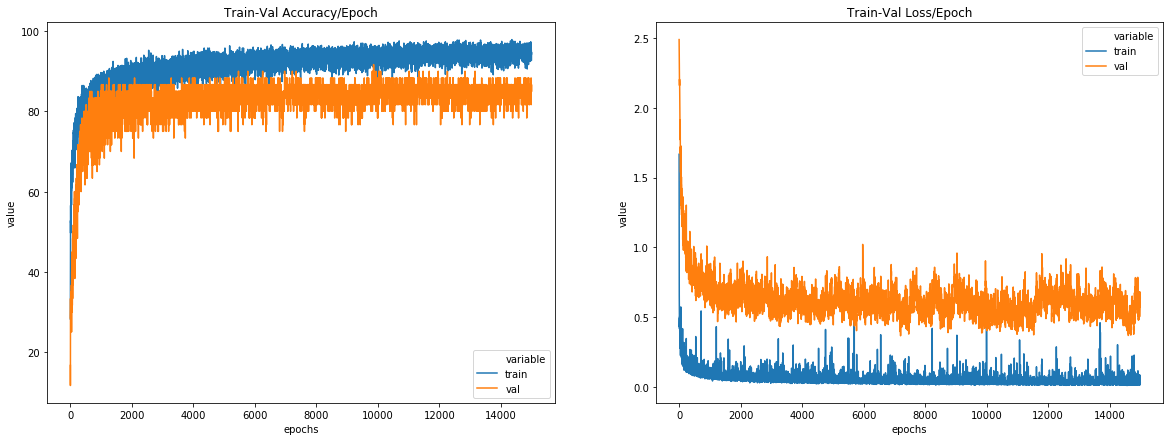

In [33]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

# Results

In [34]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

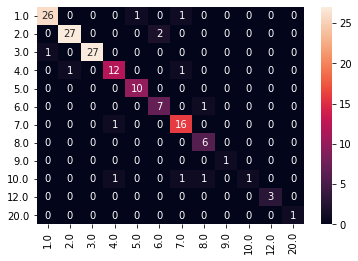

In [38]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [39]:
print(classification_report(y_test, y_pred_list_new))

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95        28
         1.0       0.96      0.93      0.95        29
         2.0       1.00      0.96      0.98        28
         3.0       0.86      0.86      0.86        14
         4.0       0.91      1.00      0.95        10
         5.0       0.78      0.88      0.82         8
         6.0       0.84      0.94      0.89        17
         7.0       0.75      1.00      0.86         6
         8.0       1.00      1.00      1.00         1
         9.0       1.00      0.25      0.40         4
        10.0       1.00      1.00      1.00         3
        11.0       1.00      1.00      1.00         1

    accuracy                           0.92       149
   macro avg       0.92      0.90      0.89       149
weighted avg       0.93      0.92      0.92       149



As we can see, the built neural network architecture has resulted in good results in terms of overall accuracy (92%). In addition, each class has high precision and recall indicating that the model is well generalized.